# TESS Atlas fit for TOI 181

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 181.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-181.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-181.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-181.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 181

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 181 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

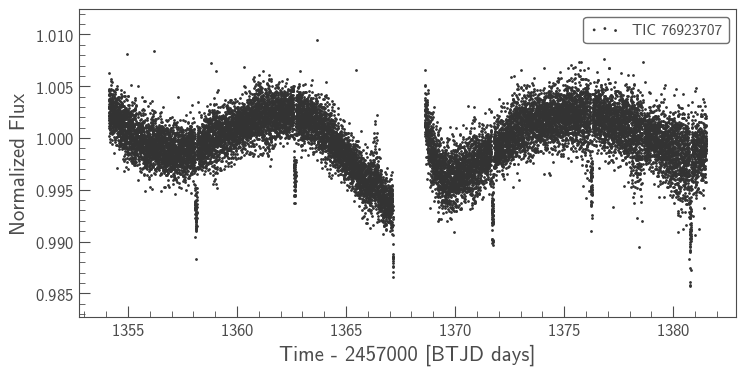

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -43241.5532459338 -> -40829.122388469295


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -33812.55463356827 -> -33803.52053950128


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -33803.52053950128 -> -33650.418514627505


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -33650.418514627505 -> -33650.41839354924


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -33650.41839354924 -> -33649.68051852237


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -33649.68051852237 -> -33649.67309294351


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -33649.67309294351 -> -33643.40987131929


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -33643.409871319294 -> -33643.409871319294


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -33643.40987131929 -> -33643.40987131925


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -33643.40987131925 -> -33643.40987131925


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -33643.40987131925 -> -33643.40987131925


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -33643.40987131925 -> -33643.40987131925


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -33643.40987131925 -> -33643.40987131925


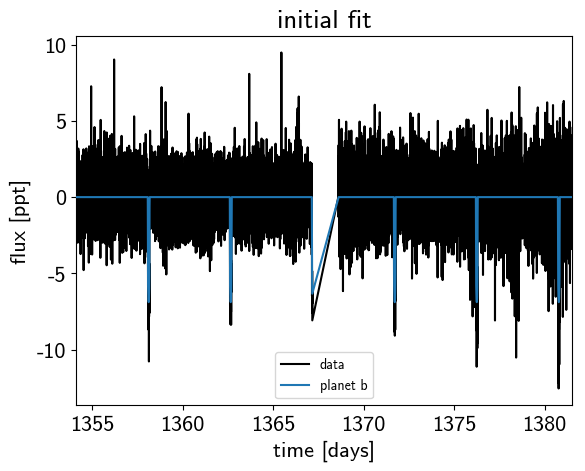

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:02, 39.24draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:09, 10.05draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:22,  4.11draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:22,  3.99draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:18,  4.78draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:26,  3.30draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:22,  3.85draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:28,  3.03draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:27,  3.04draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:25,  3.17draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:21,  3.83draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:04<00:24,  3.33draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:19,  3.97draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:24,  3.24draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:19,  3.96draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:06<00:22,  3.44draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:18,  3.96draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:06<00:20,  3.57draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:18,  3.97draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:07<00:21,  3.38draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:07<00:17,  4.06draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:07<00:20,  3.40draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:08<00:19,  3.52draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:08<00:18,  3.58draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:08<00:18,  3.58draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:09<00:16,  3.79draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:09<00:21,  2.97draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:10<00:19,  3.18draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:10<00:16,  3.60draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:10<00:17,  3.38draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:11<00:18,  3.17draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:11<00:16,  3.47draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:11<00:14,  3.70draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:11<00:12,  4.31draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:12<00:15,  3.37draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:12<00:14,  3.53draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:13<00:13,  3.65draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:13<00:10,  4.45draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:13<00:13,  3.58draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:14<00:11,  4.11draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:14<00:13,  3.30draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:14<00:10,  4.08draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:15<00:12,  3.46draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:15<00:10,  4.15draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:15<00:11,  3.50draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:15<00:09,  4.13draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:16<00:11,  3.54draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:16<00:09,  4.12draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:16<00:11,  3.22draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:17<00:10,  3.29draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:17<00:08,  3.94draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:17<00:09,  3.37draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:18<00:09,  3.27draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:18<00:08,  3.58draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:18<00:08,  3.40draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:18<00:07,  3.67draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:19<00:08,  3.30draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:19<00:07,  3.76draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:19<00:07,  3.52draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:19<00:06,  3.83draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:20<00:06,  3.59draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:20<00:05,  3.91draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:20<00:06,  3.62draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:21<00:05,  3.84draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:21<00:05,  3.70draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:21<00:04,  3.90draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:21<00:04,  3.68draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:22<00:04,  4.03draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:22<00:04,  3.41draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:22<00:03,  4.04draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:22<00:04,  3.46draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:23<00:03,  4.05draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:23<00:03,  3.34draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:23<00:02,  3.88draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:24<00:02,  3.45draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:24<00:02,  4.04draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:24<00:02,  3.51draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:24<00:01,  4.21draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:25<00:01,  3.58draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:25<00:01,  4.25draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:25<00:01,  3.62draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:26<00:01,  2.89draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:26<00:00,  2.50draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:27<00:00,  2.00draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:28<00:00,  1.38draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:04, 21.20draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:09,  9.47draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:01<00:13,  6.81draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:01<00:15,  5.72draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:02<00:16,  5.14draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:02<00:22,  3.69draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:18,  4.53draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:03<00:22,  3.63draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:03<00:23,  3.49draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:03<00:19,  4.00draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:25,  3.15draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:04<00:22,  3.40draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:04<00:18,  4.21draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:05<00:16,  4.61draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:05<00:18,  4.08draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:05<00:21,  3.47draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:06<00:20,  3.49draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:06<00:16,  4.26draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:06<00:14,  4.57draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:07<00:13,  4.82draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:07<00:11,  5.48draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:07<00:17,  3.69draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:07<00:13,  4.53draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:08<00:17,  3.63draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:08<00:15,  4.05draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:08<00:15,  3.80draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:08<00:12,  4.75draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:09<00:14,  4.04draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:09<00:12,  4.56draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:09<00:13,  3.96draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:09<00:11,  4.52draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:10<00:13,  3.92draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:10<00:11,  4.52draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:10<00:13,  3.89draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:10<00:10,  4.55draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:11<00:10,  4.69draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:11<00:09,  5.11draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:11<00:11,  4.13draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:11<00:09,  4.64draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:12<00:10,  4.04draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:12<00:09,  4.52draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:12<00:10,  3.99draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:12<00:09,  4.47draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:13<00:10,  3.97draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:13<00:07,  4.99draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:13<00:09,  4.05draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:13<00:07,  4.78draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:14<00:08,  3.96draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:14<00:07,  4.71draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:14<00:08,  3.91draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:14<00:06,  4.69draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:15<00:08,  3.87draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:15<00:06,  4.69draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:15<00:07,  3.84draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:15<00:05,  5.02draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:16<00:06,  3.91draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:16<00:05,  4.78draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:16<00:06,  3.86draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:16<00:04,  4.69draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:17<00:06,  3.54draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:17<00:05,  4.15draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:17<00:04,  4.40draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:17<00:05,  3.77draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:18<00:04,  3.97draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:18<00:05,  3.13draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:19<00:04,  3.15draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:19<00:03,  3.36draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:20<00:03,  3.51draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:20<00:02,  3.50draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:21<00:02,  3.40draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:21<00:02,  2.84draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:22<00:01,  3.01draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:22<00:01,  2.98draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:23<00:00,  3.41draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:23<00:00,  2.83draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:25<00:00,  1.16draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<01:44,  1.94draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<01:16,  2.63draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:01<01:15,  2.65draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:00,  3.30draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:01<01:06,  2.98draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:01<00:52,  3.76draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:01<00:40,  4.78draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:02<00:53,  3.62draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:02<00:51,  3.72draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:03<00:43,  4.35draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:03<00:43,  4.38draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:03<00:41,  4.53draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:04<00:45,  4.12draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:04<00:45,  4.06draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:04<00:33,  5.40draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:04<00:26,  6.86draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:05<00:30,  5.79draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:05<00:27,  6.29draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:05<00:33,  5.21draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:05<00:33,  5.22draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:06<00:25,  6.58draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:06<00:21,  7.97draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:06<00:21,  7.68draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:06<00:24,  6.63draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:07<00:23,  6.89draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:07<00:28,  5.80draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:07<00:32,  5.00draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:07<00:28,  5.62draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:07<00:27,  5.75draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:08<00:22,  7.13draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:08<00:25,  6.04draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:08<00:21,  7.20draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:08<00:19,  7.80draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:08<00:18,  8.09draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:09<00:15,  9.34draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:09<00:13, 10.99draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:09<00:19,  7.11draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:10<00:21,  6.59draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:10<00:19,  7.08draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:10<00:16,  8.30draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:10<00:16,  8.07draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:10<00:16,  7.90draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:11<00:26,  4.99draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:11<00:25,  5.12draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:11<00:31,  4.11draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:11<00:24,  5.17draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:12<00:20,  6.16draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:12<00:18,  6.66draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:12<00:21,  5.85draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:12<00:16,  7.34draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:12<00:13,  8.60draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:13<00:19,  6.09draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:13<00:19,  6.01draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:14<00:29,  3.91draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:14<00:25,  4.42draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:14<00:20,  5.29draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:14<00:19,  5.68draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:14<00:15,  6.86draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:15<00:15,  7.09draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:15<00:14,  7.31draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:15<00:13,  7.87draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:15<00:14,  7.12draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:15<00:12,  7.89draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:16<00:10,  9.10draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:16<00:14,  6.42draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:16<00:16,  5.93draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:17<00:20,  4.53draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:17<00:19,  4.79draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:17<00:15,  6.02draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:17<00:17,  5.16draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:18<00:13,  6.25draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:18<00:18,  4.53draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:18<00:14,  5.83draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:19<00:16,  4.97draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:19<00:18,  4.32draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:19<00:18,  4.39draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:20<00:22,  3.50draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:20<00:18,  4.27draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:20<00:16,  4.56draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:21<00:18,  4.04draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:21<00:18,  3.98draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:22<00:18,  3.86draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:22<00:14,  4.64draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:22<00:18,  3.63draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:22<00:15,  4.34draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:23<00:13,  4.83draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:23<00:14,  4.26draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:23<00:14,  4.24draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:24<00:16,  3.61draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:24<00:14,  4.01draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:24<00:15,  3.89draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:24<00:11,  4.97draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:24<00:10,  5.13draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:25<00:08,  6.59draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:25<00:06,  8.18draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:25<00:06,  8.26draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:25<00:08,  5.96draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:26<00:07,  6.31draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:26<00:05,  7.65draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:26<00:04,  8.87draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:26<00:06,  6.14draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:27<00:07,  5.16draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:27<00:07,  5.44draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:27<00:06,  6.27draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:27<00:05,  6.42draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:27<00:05,  6.57draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:28<00:04,  6.88draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:28<00:06,  4.72draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:28<00:05,  5.77draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:28<00:04,  6.14draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:29<00:05,  5.14draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:29<00:04,  5.84draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:30<00:04,  4.73draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:30<00:03,  5.56draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:30<00:05,  4.16draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [00:30<00:04,  4.75draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:31<00:05,  3.75draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:31<00:03,  4.82draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:31<00:02,  6.40draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:32<00:02,  4.55draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:32<00:02,  4.11draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:33<00:03,  2.94draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:33<00:02,  3.05draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:34<00:02,  2.64draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:34<00:02,  2.40draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:35<00:01,  2.84draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:35<00:01,  2.52draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:35<00:00,  3.00draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:36<00:00,  2.60draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:36<00:00,  3.32draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:08, 44.99draws/s]

Sampling 2 chains:   2%|▏         | 9/404 [00:00<00:13, 28.81draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:00<00:13, 28.11draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:00<00:14, 27.64draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:00<00:14, 27.37draws/s]

Sampling 2 chains:   5%|▌         | 22/404 [00:00<00:17, 21.94draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:01<00:17, 21.90draws/s]

Sampling 2 chains:   7%|▋         | 28/404 [00:01<00:18, 19.96draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:01<00:18, 20.05draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:01<00:16, 21.94draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:01<00:15, 22.92draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:01<00:15, 22.84draws/s]

Sampling 2 chains:  11%|█▏        | 46/404 [00:01<00:13, 25.80draws/s]

Sampling 2 chains:  12%|█▏        | 50/404 [00:02<00:12, 28.18draws/s]

Sampling 2 chains:  14%|█▎        | 55/404 [00:02<00:11, 31.42draws/s]

Sampling 2 chains:  15%|█▌        | 61/404 [00:02<00:09, 36.19draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:02<00:11, 30.01draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:02<00:10, 30.46draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:02<00:12, 25.84draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:02<00:11, 27.26draws/s]

Sampling 2 chains:  21%|██        | 84/404 [00:03<00:10, 30.76draws/s]

Sampling 2 chains:  22%|██▏       | 89/404 [00:03<00:09, 33.34draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:03<00:09, 32.92draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:03<00:11, 25.88draws/s]

Sampling 2 chains:  25%|██▌       | 102/404 [00:03<00:10, 29.53draws/s]

Sampling 2 chains:  26%|██▌       | 106/404 [00:03<00:12, 24.31draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:04<00:12, 23.41draws/s]

Sampling 2 chains:  28%|██▊       | 113/404 [00:04<00:11, 25.15draws/s]

Sampling 2 chains:  29%|██▊       | 116/404 [00:04<00:12, 23.46draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:04<00:10, 26.46draws/s]

Sampling 2 chains:  30%|███       | 123/404 [00:04<00:12, 22.99draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:04<00:10, 26.22draws/s]

Sampling 2 chains:  33%|███▎      | 132/404 [00:04<00:09, 27.72draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:05<00:10, 25.90draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:05<00:10, 24.41draws/s]

Sampling 2 chains:  35%|███▌      | 143/404 [00:05<00:11, 23.22draws/s]

Sampling 2 chains:  36%|███▋      | 147/404 [00:05<00:10, 24.99draws/s]

Sampling 2 chains:  38%|███▊      | 152/404 [00:05<00:08, 29.22draws/s]

Sampling 2 chains:  39%|███▊      | 156/404 [00:05<00:08, 28.43draws/s]

Sampling 2 chains:  40%|███▉      | 160/404 [00:05<00:08, 27.39draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:06<00:08, 28.85draws/s]

Sampling 2 chains:  42%|████▏     | 169/404 [00:06<00:07, 31.07draws/s]

Sampling 2 chains:  43%|████▎     | 173/404 [00:06<00:07, 32.67draws/s]

Sampling 2 chains:  44%|████▍     | 177/404 [00:06<00:07, 29.91draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:06<00:06, 33.17draws/s]

Sampling 2 chains:  46%|████▌     | 186/404 [00:06<00:08, 26.69draws/s]

Sampling 2 chains:  47%|████▋     | 191/404 [00:06<00:06, 30.77draws/s]

Sampling 2 chains:  49%|████▊     | 196/404 [00:06<00:06, 33.90draws/s]

Sampling 2 chains:  50%|████▉     | 200/404 [00:07<00:06, 30.93draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:07<00:05, 34.27draws/s]

Sampling 2 chains:  52%|█████▏    | 210/404 [00:07<00:05, 34.92draws/s]

Sampling 2 chains:  53%|█████▎    | 214/404 [00:07<00:05, 32.87draws/s]

Sampling 2 chains:  54%|█████▍    | 219/404 [00:07<00:05, 34.12draws/s]

Sampling 2 chains:  55%|█████▌    | 223/404 [00:07<00:05, 30.67draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [00:08<00:06, 26.45draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:08<00:06, 25.32draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:08<00:06, 24.82draws/s]

Sampling 2 chains:  58%|█████▊    | 236/404 [00:08<00:06, 24.17draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:08<00:06, 26.81draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:08<00:06, 25.18draws/s]

Sampling 2 chains:  61%|██████    | 246/404 [00:08<00:06, 26.12draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:08<00:06, 24.77draws/s]

Sampling 2 chains:  63%|██████▎   | 253/404 [00:09<00:06, 24.73draws/s]

Sampling 2 chains:  64%|██████▍   | 258/404 [00:09<00:05, 28.84draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [00:09<00:04, 29.59draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [00:09<00:04, 29.86draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [00:09<00:04, 29.36draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:09<00:04, 28.33draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:09<00:04, 26.79draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [00:09<00:03, 30.32draws/s]

Sampling 2 chains:  71%|███████▏  | 288/404 [00:10<00:03, 31.67draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:10<00:03, 33.93draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [00:10<00:03, 35.23draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:10<00:02, 36.45draws/s]

Sampling 2 chains:  76%|███████▌  | 306/404 [00:10<00:02, 36.12draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [00:10<00:02, 35.77draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [00:10<00:02, 30.65draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [00:11<00:02, 30.40draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [00:11<00:02, 32.65draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [00:11<00:02, 30.54draws/s]

Sampling 2 chains:  82%|████████▏ | 332/404 [00:11<00:02, 31.49draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [00:11<00:01, 34.90draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [00:11<00:02, 30.48draws/s]

Sampling 2 chains:  86%|████████▌ | 347/404 [00:11<00:01, 35.37draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:11<00:01, 36.27draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [00:12<00:01, 34.82draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [00:12<00:01, 34.02draws/s]

Sampling 2 chains:  90%|█████████ | 365/404 [00:12<00:01, 35.70draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [00:12<00:00, 38.33draws/s]

Sampling 2 chains:  93%|█████████▎| 375/404 [00:12<00:00, 35.84draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [00:12<00:00, 31.10draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [00:12<00:00, 27.76draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:13<00:00, 22.40draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [00:13<00:01, 11.51draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [00:14<00:01,  9.10draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [00:14<00:01,  9.92draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [00:14<00:00,  9.20draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [00:14<00:00,  7.65draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [00:14<00:00,  8.51draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [00:15<00:00,  9.76draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [00:15<00:00, 10.74draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:15<00:00, 26.35draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/804 [00:00<00:35, 22.49draws/s]

Sampling 2 chains:   1%|          | 8/804 [00:00<00:32, 24.66draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:00<00:30, 25.79draws/s]

Sampling 2 chains:   2%|▏         | 13/804 [00:00<00:33, 23.56draws/s]

Sampling 2 chains:   2%|▏         | 16/804 [00:00<00:37, 20.81draws/s]

Sampling 2 chains:   2%|▏         | 18/804 [00:00<00:57, 13.76draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:01<00:55, 14.03draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:01<00:52, 14.90draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:01<00:50, 15.34draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:01<01:06, 11.76draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:01<01:02, 12.32draws/s]

Sampling 2 chains:   4%|▎         | 30/804 [00:01<00:56, 13.68draws/s]

Sampling 2 chains:   4%|▍         | 33/804 [00:01<00:50, 15.26draws/s]

Sampling 2 chains:   5%|▍         | 37/804 [00:02<00:42, 17.96draws/s]

Sampling 2 chains:   5%|▍         | 40/804 [00:02<01:06, 11.51draws/s]

Sampling 2 chains:   5%|▌         | 42/804 [00:02<00:59, 12.89draws/s]

Sampling 2 chains:   5%|▌         | 44/804 [00:02<00:54, 13.94draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:02<00:50, 14.87draws/s]

Sampling 2 chains:   6%|▌         | 48/804 [00:03<01:13, 10.33draws/s]

Sampling 2 chains:   6%|▋         | 51/804 [00:03<01:03, 11.83draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:03<00:55, 13.42draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:03<00:56, 13.19draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:03<00:45, 16.24draws/s]

Sampling 2 chains:   8%|▊         | 62/804 [00:03<00:39, 18.59draws/s]

Sampling 2 chains:   8%|▊         | 67/804 [00:04<00:34, 21.60draws/s]

Sampling 2 chains:   9%|▊         | 70/804 [00:04<00:32, 22.79draws/s]

Sampling 2 chains:   9%|▉         | 73/804 [00:04<00:30, 24.06draws/s]

Sampling 2 chains:  10%|▉         | 78/804 [00:04<00:29, 24.75draws/s]

Sampling 2 chains:  10%|█         | 81/804 [00:04<00:32, 22.33draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:04<00:31, 23.17draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:04<00:34, 20.77draws/s]

Sampling 2 chains:  11%|█         | 90/804 [00:05<00:40, 17.67draws/s]

Sampling 2 chains:  11%|█▏        | 92/804 [00:05<00:40, 17.79draws/s]

Sampling 2 chains:  12%|█▏        | 94/804 [00:05<00:38, 18.29draws/s]

Sampling 2 chains:  12%|█▏        | 96/804 [00:05<00:41, 17.25draws/s]

Sampling 2 chains:  13%|█▎        | 101/804 [00:05<00:33, 21.22draws/s]

Sampling 2 chains:  13%|█▎        | 105/804 [00:05<00:28, 24.28draws/s]

Sampling 2 chains:  14%|█▎        | 109/804 [00:05<00:25, 27.16draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:05<00:23, 29.80draws/s]

Sampling 2 chains:  15%|█▍        | 117/804 [00:06<00:23, 29.14draws/s]

Sampling 2 chains:  15%|█▌        | 121/804 [00:06<00:22, 30.85draws/s]

Sampling 2 chains:  16%|█▌        | 126/804 [00:06<00:19, 34.03draws/s]

Sampling 2 chains:  16%|█▋        | 132/804 [00:06<00:17, 38.19draws/s]

Sampling 2 chains:  17%|█▋        | 137/804 [00:06<00:17, 37.42draws/s]

Sampling 2 chains:  18%|█▊        | 141/804 [00:06<00:18, 36.75draws/s]

Sampling 2 chains:  18%|█▊        | 145/804 [00:06<00:18, 35.91draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:06<00:17, 36.54draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:07<00:18, 35.06draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:07<00:23, 27.43draws/s]

Sampling 2 chains:  20%|██        | 162/804 [00:07<00:27, 23.48draws/s]

Sampling 2 chains:  21%|██        | 166/804 [00:07<00:24, 26.33draws/s]

Sampling 2 chains:  21%|██        | 170/804 [00:07<00:22, 27.64draws/s]

Sampling 2 chains:  22%|██▏       | 174/804 [00:07<00:22, 27.48draws/s]

Sampling 2 chains:  22%|██▏       | 177/804 [00:08<00:27, 22.86draws/s]

Sampling 2 chains:  22%|██▏       | 180/804 [00:08<00:25, 24.08draws/s]

Sampling 2 chains:  23%|██▎       | 183/804 [00:08<00:26, 23.26draws/s]

Sampling 2 chains:  23%|██▎       | 186/804 [00:08<00:25, 24.24draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:08<00:23, 26.01draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:08<00:22, 27.70draws/s]

Sampling 2 chains:  25%|██▍       | 199/804 [00:08<00:19, 31.76draws/s]

Sampling 2 chains:  25%|██▌       | 203/804 [00:08<00:17, 33.59draws/s]

Sampling 2 chains:  26%|██▌       | 207/804 [00:08<00:17, 34.10draws/s]

Sampling 2 chains:  26%|██▌       | 211/804 [00:09<00:18, 32.19draws/s]

Sampling 2 chains:  27%|██▋       | 215/804 [00:09<00:19, 30.41draws/s]

Sampling 2 chains:  27%|██▋       | 219/804 [00:09<00:17, 32.66draws/s]

Sampling 2 chains:  28%|██▊       | 223/804 [00:09<00:20, 27.93draws/s]

Sampling 2 chains:  28%|██▊       | 227/804 [00:09<00:22, 26.03draws/s]

Sampling 2 chains:  29%|██▊       | 230/804 [00:09<00:21, 26.91draws/s]

Sampling 2 chains:  29%|██▉       | 233/804 [00:09<00:21, 26.62draws/s]

Sampling 2 chains:  29%|██▉       | 236/804 [00:10<00:23, 24.54draws/s]

Sampling 2 chains:  30%|██▉       | 239/804 [00:10<00:21, 25.75draws/s]

Sampling 2 chains:  30%|███       | 242/804 [00:10<00:22, 25.45draws/s]

Sampling 2 chains:  30%|███       | 245/804 [00:10<00:22, 24.35draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:10<00:22, 24.69draws/s]

Sampling 2 chains:  31%|███       | 251/804 [00:10<00:21, 25.37draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [00:10<00:20, 26.44draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [00:10<00:18, 29.31draws/s]

Sampling 2 chains:  33%|███▎      | 262/804 [00:11<00:20, 26.32draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [00:11<00:18, 28.77draws/s]

Sampling 2 chains:  34%|███▎      | 270/804 [00:11<00:19, 28.06draws/s]

Sampling 2 chains:  34%|███▍      | 275/804 [00:11<00:19, 27.77draws/s]

Sampling 2 chains:  35%|███▍      | 278/804 [00:11<00:21, 24.55draws/s]

Sampling 2 chains:  35%|███▍      | 281/804 [00:11<00:26, 19.56draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [00:12<00:23, 21.83draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:12<00:23, 21.70draws/s]

Sampling 2 chains:  36%|███▌      | 290/804 [00:12<00:23, 22.10draws/s]

Sampling 2 chains:  36%|███▋      | 293/804 [00:12<00:22, 23.13draws/s]

Sampling 2 chains:  37%|███▋      | 297/804 [00:12<00:20, 24.81draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:12<00:30, 16.51draws/s]

Sampling 2 chains:  38%|███▊      | 303/804 [00:12<00:28, 17.45draws/s]

Sampling 2 chains:  38%|███▊      | 306/804 [00:13<00:28, 17.34draws/s]

Sampling 2 chains:  38%|███▊      | 309/804 [00:13<00:24, 19.82draws/s]

Sampling 2 chains:  39%|███▉      | 312/804 [00:13<00:31, 15.62draws/s]

Sampling 2 chains:  39%|███▉      | 314/804 [00:13<00:32, 15.01draws/s]

Sampling 2 chains:  39%|███▉      | 317/804 [00:13<00:30, 15.92draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [00:13<00:26, 17.97draws/s]

Sampling 2 chains:  40%|████      | 323/804 [00:14<00:25, 18.61draws/s]

Sampling 2 chains:  41%|████      | 326/804 [00:14<00:22, 20.94draws/s]

Sampling 2 chains:  41%|████      | 330/804 [00:14<00:20, 23.62draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [00:14<00:18, 25.02draws/s]

Sampling 2 chains:  42%|████▏     | 337/804 [00:14<00:16, 28.13draws/s]

Sampling 2 chains:  43%|████▎     | 342/804 [00:14<00:14, 32.31draws/s]

Sampling 2 chains:  43%|████▎     | 347/804 [00:14<00:13, 34.61draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [00:14<00:12, 37.50draws/s]

Sampling 2 chains:  44%|████▍     | 357/804 [00:15<00:12, 34.54draws/s]

Sampling 2 chains:  45%|████▍     | 361/804 [00:15<00:13, 31.67draws/s]

Sampling 2 chains:  45%|████▌     | 365/804 [00:15<00:13, 32.35draws/s]

Sampling 2 chains:  46%|████▌     | 370/804 [00:15<00:12, 34.76draws/s]

Sampling 2 chains:  47%|████▋     | 374/804 [00:15<00:12, 35.63draws/s]

Sampling 2 chains:  47%|████▋     | 379/804 [00:15<00:11, 37.61draws/s]

Sampling 2 chains:  48%|████▊     | 383/804 [00:15<00:11, 35.99draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [00:15<00:12, 34.27draws/s]

Sampling 2 chains:  49%|████▉     | 392/804 [00:16<00:11, 36.83draws/s]

Sampling 2 chains:  49%|████▉     | 396/804 [00:16<00:10, 37.37draws/s]

Sampling 2 chains:  50%|████▉     | 400/804 [00:16<00:11, 35.84draws/s]

Sampling 2 chains:  50%|█████     | 405/804 [00:16<00:10, 38.96draws/s]

Sampling 2 chains:  51%|█████     | 410/804 [00:16<00:09, 41.18draws/s]

Sampling 2 chains:  52%|█████▏    | 415/804 [00:16<00:10, 38.12draws/s]

Sampling 2 chains:  52%|█████▏    | 419/804 [00:16<00:11, 33.18draws/s]

Sampling 2 chains:  53%|█████▎    | 423/804 [00:16<00:11, 33.75draws/s]

Sampling 2 chains:  53%|█████▎    | 427/804 [00:17<00:11, 32.67draws/s]

Sampling 2 chains:  54%|█████▎    | 431/804 [00:17<00:11, 32.46draws/s]

Sampling 2 chains:  54%|█████▍    | 436/804 [00:17<00:10, 35.38draws/s]

Sampling 2 chains:  55%|█████▍    | 440/804 [00:17<00:10, 36.16draws/s]

Sampling 2 chains:  55%|█████▌    | 444/804 [00:17<00:09, 36.18draws/s]

Sampling 2 chains:  56%|█████▌    | 448/804 [00:17<00:09, 36.99draws/s]

Sampling 2 chains:  56%|█████▌    | 452/804 [00:17<00:09, 36.73draws/s]

Sampling 2 chains:  57%|█████▋    | 456/804 [00:17<00:10, 32.55draws/s]

Sampling 2 chains:  57%|█████▋    | 460/804 [00:17<00:10, 31.42draws/s]

Sampling 2 chains:  58%|█████▊    | 464/804 [00:18<00:11, 30.33draws/s]

Sampling 2 chains:  58%|█████▊    | 468/804 [00:18<00:11, 28.92draws/s]

Sampling 2 chains:  59%|█████▉    | 473/804 [00:18<00:10, 30.68draws/s]

Sampling 2 chains:  59%|█████▉    | 477/804 [00:18<00:12, 27.13draws/s]

Sampling 2 chains:  60%|█████▉    | 480/804 [00:18<00:11, 27.42draws/s]

Sampling 2 chains:  60%|██████    | 485/804 [00:18<00:10, 30.37draws/s]

Sampling 2 chains:  61%|██████    | 489/804 [00:18<00:09, 32.72draws/s]

Sampling 2 chains:  61%|██████▏   | 494/804 [00:19<00:08, 34.93draws/s]

Sampling 2 chains:  62%|██████▏   | 498/804 [00:19<00:09, 32.88draws/s]

Sampling 2 chains:  62%|██████▏   | 502/804 [00:19<00:08, 34.73draws/s]

Sampling 2 chains:  63%|██████▎   | 506/804 [00:19<00:08, 35.56draws/s]

Sampling 2 chains:  63%|██████▎   | 510/804 [00:19<00:09, 32.25draws/s]

Sampling 2 chains:  64%|██████▍   | 514/804 [00:19<00:09, 31.22draws/s]

Sampling 2 chains:  64%|██████▍   | 518/804 [00:19<00:08, 33.36draws/s]

Sampling 2 chains:  65%|██████▍   | 522/804 [00:19<00:08, 34.57draws/s]

Sampling 2 chains:  65%|██████▌   | 526/804 [00:20<00:08, 31.00draws/s]

Sampling 2 chains:  66%|██████▌   | 531/804 [00:20<00:08, 32.40draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [00:20<00:07, 35.60draws/s]

Sampling 2 chains:  67%|██████▋   | 541/804 [00:20<00:07, 37.47draws/s]

Sampling 2 chains:  68%|██████▊   | 545/804 [00:20<00:07, 34.24draws/s]

Sampling 2 chains:  68%|██████▊   | 549/804 [00:20<00:07, 32.96draws/s]

Sampling 2 chains:  69%|██████▉   | 553/804 [00:20<00:09, 26.32draws/s]

Sampling 2 chains:  69%|██████▉   | 557/804 [00:21<00:08, 27.52draws/s]

Sampling 2 chains:  70%|██████▉   | 562/804 [00:21<00:08, 29.86draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [00:21<00:06, 34.40draws/s]

Sampling 2 chains:  71%|███████▏  | 573/804 [00:21<00:06, 37.92draws/s]

Sampling 2 chains:  72%|███████▏  | 578/804 [00:21<00:05, 39.29draws/s]

Sampling 2 chains:  73%|███████▎  | 583/804 [00:21<00:05, 40.14draws/s]

Sampling 2 chains:  73%|███████▎  | 588/804 [00:21<00:05, 39.03draws/s]

Sampling 2 chains:  74%|███████▍  | 593/804 [00:21<00:05, 38.93draws/s]

Sampling 2 chains:  75%|███████▍  | 599/804 [00:21<00:04, 42.42draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [00:22<00:04, 46.00draws/s]

Sampling 2 chains:  76%|███████▌  | 611/804 [00:22<00:04, 45.56draws/s]

Sampling 2 chains:  77%|███████▋  | 617/804 [00:22<00:03, 47.23draws/s]

Sampling 2 chains:  77%|███████▋  | 622/804 [00:22<00:03, 47.82draws/s]

Sampling 2 chains:  78%|███████▊  | 627/804 [00:22<00:04, 42.42draws/s]

Sampling 2 chains:  79%|███████▊  | 632/804 [00:22<00:03, 43.28draws/s]

Sampling 2 chains:  79%|███████▉  | 637/804 [00:22<00:04, 37.78draws/s]

Sampling 2 chains:  80%|███████▉  | 643/804 [00:23<00:04, 38.68draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [00:23<00:04, 37.08draws/s]

Sampling 2 chains:  81%|████████  | 652/804 [00:23<00:05, 27.67draws/s]

Sampling 2 chains:  82%|████████▏ | 656/804 [00:23<00:05, 25.11draws/s]

Sampling 2 chains:  82%|████████▏ | 659/804 [00:23<00:06, 23.27draws/s]

Sampling 2 chains:  82%|████████▏ | 662/804 [00:23<00:05, 24.50draws/s]

Sampling 2 chains:  83%|████████▎ | 665/804 [00:23<00:05, 25.56draws/s]

Sampling 2 chains:  83%|████████▎ | 668/804 [00:24<00:05, 26.12draws/s]

Sampling 2 chains:  84%|████████▎ | 672/804 [00:24<00:04, 28.67draws/s]

Sampling 2 chains:  84%|████████▍ | 676/804 [00:24<00:04, 29.95draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [00:24<00:04, 28.64draws/s]

Sampling 2 chains:  85%|████████▌ | 684/804 [00:24<00:03, 30.53draws/s]

Sampling 2 chains:  86%|████████▌ | 688/804 [00:24<00:04, 26.56draws/s]

Sampling 2 chains:  86%|████████▌ | 692/804 [00:24<00:04, 27.04draws/s]

Sampling 2 chains:  87%|████████▋ | 696/804 [00:25<00:03, 27.56draws/s]

Sampling 2 chains:  87%|████████▋ | 700/804 [00:25<00:03, 26.70draws/s]

Sampling 2 chains:  87%|████████▋ | 703/804 [00:25<00:04, 20.67draws/s]

Sampling 2 chains:  88%|████████▊ | 706/804 [00:25<00:05, 16.38draws/s]

Sampling 2 chains:  88%|████████▊ | 708/804 [00:25<00:06, 14.24draws/s]

Sampling 2 chains:  88%|████████▊ | 710/804 [00:26<00:06, 13.83draws/s]

Sampling 2 chains:  89%|████████▉ | 714/804 [00:26<00:05, 15.34draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [00:26<00:06, 14.58draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [00:26<00:05, 15.07draws/s]

Sampling 2 chains:  90%|████████▉ | 720/804 [00:26<00:05, 15.92draws/s]

Sampling 2 chains:  90%|████████▉ | 722/804 [00:26<00:06, 12.96draws/s]

Sampling 2 chains:  90%|█████████ | 724/804 [00:27<00:06, 11.96draws/s]

Sampling 2 chains:  90%|█████████ | 726/804 [00:27<00:06, 11.40draws/s]

Sampling 2 chains:  91%|█████████ | 729/804 [00:27<00:05, 13.25draws/s]

Sampling 2 chains:  91%|█████████ | 731/804 [00:27<00:05, 13.18draws/s]

Sampling 2 chains:  91%|█████████ | 733/804 [00:27<00:05, 13.74draws/s]

Sampling 2 chains:  92%|█████████▏| 736/804 [00:27<00:04, 15.30draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [00:27<00:05, 13.12draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [00:28<00:04, 13.44draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [00:28<00:04, 15.18draws/s]

Sampling 2 chains:  93%|█████████▎| 746/804 [00:28<00:03, 16.55draws/s]

Sampling 2 chains:  93%|█████████▎| 748/804 [00:28<00:03, 15.81draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [00:28<00:03, 13.96draws/s]

Sampling 2 chains:  94%|█████████▎| 753/804 [00:28<00:03, 15.43draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [00:28<00:03, 16.26draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [00:29<00:02, 17.58draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [00:29<00:02, 16.57draws/s]

Sampling 2 chains:  95%|█████████▍| 762/804 [00:29<00:02, 15.75draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [00:29<00:02, 16.44draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [00:29<00:01, 18.51draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [00:29<00:01, 20.22draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [00:30<00:01, 16.77draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [00:30<00:01, 17.18draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [00:30<00:01, 16.07draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [00:30<00:01, 15.24draws/s]

Sampling 2 chains:  97%|█████████▋| 781/804 [00:30<00:01, 11.87draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [00:31<00:02,  8.58draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [00:31<00:01,  9.67draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [00:31<00:01, 11.19draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [00:31<00:01,  9.62draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [00:31<00:01,  9.91draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [00:32<00:01,  7.62draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [00:32<00:01,  7.50draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [00:32<00:00,  8.71draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [00:32<00:00,  9.77draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [00:32<00:00, 11.64draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:32<00:00, 24.37draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/4404 [00:00<01:42, 42.76draws/s]

Sampling 2 chains:   0%|          | 7/4404 [00:00<02:29, 29.50draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:00<03:45, 19.48draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:00<04:53, 14.96draws/s]

Sampling 2 chains:   0%|          | 13/4404 [00:00<05:35, 13.07draws/s]

Sampling 2 chains:   0%|          | 15/4404 [00:01<07:01, 10.42draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:01<08:02,  9.09draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:01<07:48,  9.36draws/s]

Sampling 2 chains:   0%|          | 22/4404 [00:01<06:11, 11.79draws/s]

Sampling 2 chains:   1%|          | 24/4404 [00:01<06:29, 11.25draws/s]

Sampling 2 chains:   1%|          | 27/4404 [00:02<05:37, 12.97draws/s]

Sampling 2 chains:   1%|          | 29/4404 [00:02<06:07, 11.91draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:02<05:49, 12.50draws/s]

Sampling 2 chains:   1%|          | 33/4404 [00:02<06:42, 10.85draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:03<09:34,  7.60draws/s]

Sampling 2 chains:   1%|          | 37/4404 [00:03<08:59,  8.09draws/s]

Sampling 2 chains:   1%|          | 39/4404 [00:03<08:02,  9.05draws/s]

Sampling 2 chains:   1%|          | 41/4404 [00:03<06:59, 10.40draws/s]

Sampling 2 chains:   1%|          | 43/4404 [00:03<06:24, 11.35draws/s]

Sampling 2 chains:   1%|          | 47/4404 [00:03<05:16, 13.76draws/s]

Sampling 2 chains:   1%|          | 49/4404 [00:04<05:41, 12.75draws/s]

Sampling 2 chains:   1%|          | 52/4404 [00:04<04:44, 15.31draws/s]

Sampling 2 chains:   1%|▏         | 56/4404 [00:04<04:16, 16.96draws/s]

Sampling 2 chains:   1%|▏         | 59/4404 [00:04<04:16, 16.93draws/s]

Sampling 2 chains:   1%|▏         | 62/4404 [00:04<03:53, 18.56draws/s]

Sampling 2 chains:   1%|▏         | 66/4404 [00:04<03:21, 21.58draws/s]

Sampling 2 chains:   2%|▏         | 69/4404 [00:04<03:23, 21.34draws/s]

Sampling 2 chains:   2%|▏         | 72/4404 [00:04<03:06, 23.27draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:05<03:07, 23.06draws/s]

Sampling 2 chains:   2%|▏         | 78/4404 [00:05<02:59, 24.11draws/s]

Sampling 2 chains:   2%|▏         | 82/4404 [00:05<03:04, 23.44draws/s]

Sampling 2 chains:   2%|▏         | 86/4404 [00:05<02:52, 25.00draws/s]

Sampling 2 chains:   2%|▏         | 91/4404 [00:05<02:35, 27.79draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:05<02:31, 28.43draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:05<02:25, 29.57draws/s]

Sampling 2 chains:   2%|▏         | 104/4404 [00:06<02:23, 29.96draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:06<02:19, 30.78draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:06<02:43, 26.18draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:06<03:06, 23.06draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:06<03:11, 22.38draws/s]

Sampling 2 chains:   3%|▎         | 121/4404 [00:06<03:09, 22.56draws/s]

Sampling 2 chains:   3%|▎         | 125/4404 [00:06<02:53, 24.70draws/s]

Sampling 2 chains:   3%|▎         | 130/4404 [00:07<02:38, 27.03draws/s]

Sampling 2 chains:   3%|▎         | 133/4404 [00:07<02:53, 24.66draws/s]

Sampling 2 chains:   3%|▎         | 136/4404 [00:07<02:46, 25.71draws/s]

Sampling 2 chains:   3%|▎         | 139/4404 [00:07<02:52, 24.67draws/s]

Sampling 2 chains:   3%|▎         | 142/4404 [00:07<02:58, 23.89draws/s]

Sampling 2 chains:   3%|▎         | 145/4404 [00:07<03:10, 22.31draws/s]

Sampling 2 chains:   3%|▎         | 148/4404 [00:07<03:35, 19.71draws/s]

Sampling 2 chains:   3%|▎         | 151/4404 [00:08<04:27, 15.91draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:08<04:30, 15.69draws/s]

Sampling 2 chains:   4%|▎         | 156/4404 [00:08<04:52, 14.52draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:08<04:39, 15.22draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:08<04:20, 16.30draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:08<04:07, 17.15draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:09<03:44, 18.86draws/s]

Sampling 2 chains:   4%|▍         | 168/4404 [00:09<03:33, 19.88draws/s]

Sampling 2 chains:   4%|▍         | 171/4404 [00:09<03:16, 21.53draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:09<02:58, 23.74draws/s]

Sampling 2 chains:   4%|▍         | 179/4404 [00:09<02:42, 25.94draws/s]

Sampling 2 chains:   4%|▍         | 184/4404 [00:09<02:20, 29.95draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:09<02:21, 29.89draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:09<02:11, 32.05draws/s]

Sampling 2 chains:   4%|▍         | 196/4404 [00:10<02:13, 31.49draws/s]

Sampling 2 chains:   5%|▍         | 200/4404 [00:10<02:05, 33.54draws/s]

Sampling 2 chains:   5%|▍         | 204/4404 [00:10<02:37, 26.69draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:10<02:51, 24.50draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:10<03:16, 21.29draws/s]

Sampling 2 chains:   5%|▍         | 213/4404 [00:10<03:14, 21.59draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:10<03:02, 22.90draws/s]

Sampling 2 chains:   5%|▍         | 219/4404 [00:11<03:03, 22.79draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:11<02:58, 23.41draws/s]

Sampling 2 chains:   5%|▌         | 225/4404 [00:11<02:56, 23.65draws/s]

Sampling 2 chains:   5%|▌         | 229/4404 [00:11<02:39, 26.19draws/s]

Sampling 2 chains:   5%|▌         | 233/4404 [00:11<02:32, 27.36draws/s]

Sampling 2 chains:   5%|▌         | 237/4404 [00:11<02:17, 30.22draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [00:11<02:17, 30.37draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [00:11<02:26, 28.45draws/s]

Sampling 2 chains:   6%|▌         | 248/4404 [00:12<02:44, 25.29draws/s]

Sampling 2 chains:   6%|▌         | 251/4404 [00:12<03:03, 22.68draws/s]

Sampling 2 chains:   6%|▌         | 254/4404 [00:12<03:01, 22.82draws/s]

Sampling 2 chains:   6%|▌         | 258/4404 [00:12<02:58, 23.20draws/s]

Sampling 2 chains:   6%|▌         | 261/4404 [00:12<03:31, 19.63draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:12<03:20, 20.60draws/s]

Sampling 2 chains:   6%|▌         | 269/4404 [00:13<02:56, 23.40draws/s]

Sampling 2 chains:   6%|▌         | 272/4404 [00:13<03:14, 21.30draws/s]

Sampling 2 chains:   6%|▋         | 276/4404 [00:13<02:50, 24.17draws/s]

Sampling 2 chains:   6%|▋         | 279/4404 [00:13<02:41, 25.59draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [00:13<02:54, 23.61draws/s]

Sampling 2 chains:   6%|▋         | 285/4404 [00:13<02:59, 22.89draws/s]

Sampling 2 chains:   7%|▋         | 289/4404 [00:13<02:41, 25.42draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [00:13<02:37, 26.17draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:14<02:30, 27.26draws/s]

Sampling 2 chains:   7%|▋         | 301/4404 [00:14<02:19, 29.50draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [00:14<02:15, 30.29draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [00:14<02:06, 32.49draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [00:14<02:56, 23.22draws/s]

Sampling 2 chains:   7%|▋         | 316/4404 [00:14<02:58, 22.94draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:15<03:05, 21.98draws/s]

Sampling 2 chains:   7%|▋         | 322/4404 [00:15<02:52, 23.71draws/s]

Sampling 2 chains:   7%|▋         | 325/4404 [00:15<02:42, 25.11draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [00:15<02:26, 27.74draws/s]

Sampling 2 chains:   8%|▊         | 334/4404 [00:15<02:08, 31.64draws/s]

Sampling 2 chains:   8%|▊         | 338/4404 [00:15<02:12, 30.72draws/s]

Sampling 2 chains:   8%|▊         | 342/4404 [00:15<02:15, 29.99draws/s]

Sampling 2 chains:   8%|▊         | 346/4404 [00:15<02:13, 30.46draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:15<02:04, 32.59draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:16<02:42, 24.88draws/s]

Sampling 2 chains:   8%|▊         | 357/4404 [00:16<03:08, 21.47draws/s]

Sampling 2 chains:   8%|▊         | 360/4404 [00:16<03:03, 22.00draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:16<03:02, 22.16draws/s]

Sampling 2 chains:   8%|▊         | 366/4404 [00:16<03:04, 21.91draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:16<03:07, 21.53draws/s]

Sampling 2 chains:   8%|▊         | 372/4404 [00:17<03:08, 21.44draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [00:17<02:58, 22.53draws/s]

Sampling 2 chains:   9%|▊         | 378/4404 [00:17<02:51, 23.45draws/s]

Sampling 2 chains:   9%|▊         | 382/4404 [00:17<02:40, 25.07draws/s]

Sampling 2 chains:   9%|▊         | 385/4404 [00:17<02:33, 26.14draws/s]

Sampling 2 chains:   9%|▉         | 388/4404 [00:17<02:39, 25.23draws/s]

Sampling 2 chains:   9%|▉         | 392/4404 [00:17<02:21, 28.26draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:17<02:31, 26.42draws/s]

Sampling 2 chains:   9%|▉         | 398/4404 [00:18<03:02, 21.96draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:18<03:02, 21.88draws/s]

Sampling 2 chains:   9%|▉         | 404/4404 [00:18<03:09, 21.07draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [00:18<02:58, 22.45draws/s]

Sampling 2 chains:   9%|▉         | 411/4404 [00:18<02:50, 23.48draws/s]

Sampling 2 chains:   9%|▉         | 414/4404 [00:18<02:47, 23.76draws/s]

Sampling 2 chains:   9%|▉         | 418/4404 [00:18<02:45, 24.11draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:19<02:55, 22.75draws/s]

Sampling 2 chains:  10%|▉         | 424/4404 [00:19<02:43, 24.39draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:19<02:48, 23.58draws/s]

Sampling 2 chains:  10%|▉         | 430/4404 [00:19<02:40, 24.71draws/s]

Sampling 2 chains:  10%|▉         | 434/4404 [00:19<02:29, 26.50draws/s]

Sampling 2 chains:  10%|▉         | 437/4404 [00:19<02:26, 27.13draws/s]

Sampling 2 chains:  10%|▉         | 440/4404 [00:19<02:23, 27.72draws/s]

Sampling 2 chains:  10%|█         | 445/4404 [00:19<02:07, 30.94draws/s]

Sampling 2 chains:  10%|█         | 449/4404 [00:20<02:18, 28.65draws/s]

Sampling 2 chains:  10%|█         | 454/4404 [00:20<02:01, 32.59draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [00:20<01:52, 34.95draws/s]

Sampling 2 chains:  11%|█         | 463/4404 [00:20<02:10, 30.21draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [00:20<02:11, 29.90draws/s]

Sampling 2 chains:  11%|█         | 471/4404 [00:20<02:45, 23.76draws/s]

Sampling 2 chains:  11%|█         | 474/4404 [00:20<02:41, 24.28draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [00:21<02:46, 23.57draws/s]

Sampling 2 chains:  11%|█         | 482/4404 [00:21<02:30, 26.14draws/s]

Sampling 2 chains:  11%|█         | 485/4404 [00:21<02:29, 26.26draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [00:21<02:24, 27.07draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [00:21<02:22, 27.40draws/s]

Sampling 2 chains:  11%|█▏        | 496/4404 [00:21<02:19, 27.96draws/s]

Sampling 2 chains:  11%|█▏        | 499/4404 [00:21<02:53, 22.55draws/s]

Sampling 2 chains:  11%|█▏        | 502/4404 [00:22<02:40, 24.28draws/s]

Sampling 2 chains:  11%|█▏        | 505/4404 [00:22<02:32, 25.63draws/s]

Sampling 2 chains:  12%|█▏        | 508/4404 [00:22<02:32, 25.56draws/s]

Sampling 2 chains:  12%|█▏        | 511/4404 [00:22<02:30, 25.86draws/s]

Sampling 2 chains:  12%|█▏        | 514/4404 [00:22<02:25, 26.75draws/s]

Sampling 2 chains:  12%|█▏        | 517/4404 [00:22<02:24, 26.99draws/s]

Sampling 2 chains:  12%|█▏        | 521/4404 [00:22<02:15, 28.62draws/s]

Sampling 2 chains:  12%|█▏        | 524/4404 [00:22<02:40, 24.15draws/s]

Sampling 2 chains:  12%|█▏        | 527/4404 [00:22<02:50, 22.73draws/s]

Sampling 2 chains:  12%|█▏        | 530/4404 [00:23<02:58, 21.68draws/s]

Sampling 2 chains:  12%|█▏        | 533/4404 [00:23<02:53, 22.25draws/s]

Sampling 2 chains:  12%|█▏        | 537/4404 [00:23<02:36, 24.67draws/s]

Sampling 2 chains:  12%|█▏        | 542/4404 [00:23<02:22, 27.11draws/s]

Sampling 2 chains:  12%|█▏        | 545/4404 [00:23<02:23, 26.90draws/s]

Sampling 2 chains:  12%|█▏        | 548/4404 [00:23<02:32, 25.30draws/s]

Sampling 2 chains:  13%|█▎        | 551/4404 [00:23<02:28, 25.96draws/s]

Sampling 2 chains:  13%|█▎        | 557/4404 [00:24<02:08, 29.84draws/s]

Sampling 2 chains:  13%|█▎        | 561/4404 [00:24<02:14, 28.47draws/s]

Sampling 2 chains:  13%|█▎        | 565/4404 [00:24<02:34, 24.81draws/s]

Sampling 2 chains:  13%|█▎        | 570/4404 [00:24<02:13, 28.70draws/s]

Sampling 2 chains:  13%|█▎        | 574/4404 [00:24<02:13, 28.68draws/s]

Sampling 2 chains:  13%|█▎        | 578/4404 [00:24<02:37, 24.23draws/s]

Sampling 2 chains:  13%|█▎        | 581/4404 [00:25<02:48, 22.75draws/s]

Sampling 2 chains:  13%|█▎        | 585/4404 [00:25<02:41, 23.66draws/s]

Sampling 2 chains:  13%|█▎        | 590/4404 [00:25<02:23, 26.54draws/s]

Sampling 2 chains:  13%|█▎        | 593/4404 [00:25<02:19, 27.26draws/s]

Sampling 2 chains:  14%|█▎        | 597/4404 [00:25<02:12, 28.78draws/s]

Sampling 2 chains:  14%|█▎        | 601/4404 [00:25<02:10, 29.12draws/s]

Sampling 2 chains:  14%|█▎        | 605/4404 [00:25<02:00, 31.48draws/s]

Sampling 2 chains:  14%|█▍        | 611/4404 [00:25<01:55, 32.74draws/s]

Sampling 2 chains:  14%|█▍        | 615/4404 [00:26<02:10, 29.10draws/s]

Sampling 2 chains:  14%|█▍        | 619/4404 [00:26<02:00, 31.39draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [00:26<02:17, 27.50draws/s]

Sampling 2 chains:  14%|█▍        | 626/4404 [00:26<02:28, 25.50draws/s]

Sampling 2 chains:  14%|█▍        | 629/4404 [00:26<02:34, 24.37draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [00:26<02:42, 23.23draws/s]

Sampling 2 chains:  14%|█▍        | 635/4404 [00:26<02:40, 23.51draws/s]

Sampling 2 chains:  14%|█▍        | 638/4404 [00:27<02:47, 22.49draws/s]

Sampling 2 chains:  15%|█▍        | 641/4404 [00:27<02:48, 22.37draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [00:27<03:13, 19.47draws/s]

Sampling 2 chains:  15%|█▍        | 648/4404 [00:27<02:57, 21.19draws/s]

Sampling 2 chains:  15%|█▍        | 651/4404 [00:27<02:46, 22.59draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [00:27<02:48, 22.20draws/s]

Sampling 2 chains:  15%|█▍        | 658/4404 [00:27<02:30, 24.86draws/s]

Sampling 2 chains:  15%|█▌        | 661/4404 [00:28<02:55, 21.36draws/s]

Sampling 2 chains:  15%|█▌        | 664/4404 [00:28<02:42, 23.06draws/s]

Sampling 2 chains:  15%|█▌        | 668/4404 [00:28<02:33, 24.33draws/s]

Sampling 2 chains:  15%|█▌        | 674/4404 [00:28<02:14, 27.71draws/s]

Sampling 2 chains:  15%|█▌        | 680/4404 [00:28<02:00, 30.85draws/s]

Sampling 2 chains:  16%|█▌        | 684/4404 [00:28<02:35, 23.85draws/s]

Sampling 2 chains:  16%|█▌        | 687/4404 [00:29<02:56, 21.03draws/s]

Sampling 2 chains:  16%|█▌        | 690/4404 [00:29<02:44, 22.62draws/s]

Sampling 2 chains:  16%|█▌        | 693/4404 [00:29<02:57, 20.90draws/s]

Sampling 2 chains:  16%|█▌        | 696/4404 [00:29<03:08, 19.65draws/s]

Sampling 2 chains:  16%|█▌        | 699/4404 [00:29<03:40, 16.84draws/s]

Sampling 2 chains:  16%|█▌        | 701/4404 [00:29<03:53, 15.88draws/s]

Sampling 2 chains:  16%|█▌        | 703/4404 [00:30<03:52, 15.93draws/s]

Sampling 2 chains:  16%|█▌        | 705/4404 [00:30<04:09, 14.81draws/s]

Sampling 2 chains:  16%|█▌        | 709/4404 [00:30<03:34, 17.22draws/s]

Sampling 2 chains:  16%|█▌        | 712/4404 [00:30<03:12, 19.22draws/s]

Sampling 2 chains:  16%|█▌        | 715/4404 [00:30<02:56, 20.96draws/s]

Sampling 2 chains:  16%|█▋        | 720/4404 [00:30<02:38, 23.26draws/s]

Sampling 2 chains:  16%|█▋        | 723/4404 [00:30<02:50, 21.54draws/s]

Sampling 2 chains:  16%|█▋        | 726/4404 [00:31<02:37, 23.34draws/s]

Sampling 2 chains:  17%|█▋        | 729/4404 [00:31<02:51, 21.37draws/s]

Sampling 2 chains:  17%|█▋        | 732/4404 [00:31<02:43, 22.44draws/s]

Sampling 2 chains:  17%|█▋        | 735/4404 [00:31<02:35, 23.64draws/s]

Sampling 2 chains:  17%|█▋        | 738/4404 [00:31<02:49, 21.68draws/s]

Sampling 2 chains:  17%|█▋        | 742/4404 [00:31<02:34, 23.67draws/s]

Sampling 2 chains:  17%|█▋        | 746/4404 [00:31<02:28, 24.70draws/s]

Sampling 2 chains:  17%|█▋        | 749/4404 [00:32<02:39, 22.96draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [00:32<02:37, 23.23draws/s]

Sampling 2 chains:  17%|█▋        | 756/4404 [00:32<02:41, 22.54draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [00:32<02:53, 21.06draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [00:32<02:57, 20.48draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [00:32<02:49, 21.48draws/s]

Sampling 2 chains:  17%|█▋        | 768/4404 [00:32<03:02, 19.90draws/s]

Sampling 2 chains:  18%|█▊        | 771/4404 [00:33<02:56, 20.55draws/s]

Sampling 2 chains:  18%|█▊        | 774/4404 [00:33<02:49, 21.46draws/s]

Sampling 2 chains:  18%|█▊        | 777/4404 [00:33<02:36, 23.21draws/s]

Sampling 2 chains:  18%|█▊        | 780/4404 [00:33<02:46, 21.82draws/s]

Sampling 2 chains:  18%|█▊        | 783/4404 [00:33<02:44, 21.97draws/s]

Sampling 2 chains:  18%|█▊        | 786/4404 [00:33<02:37, 23.00draws/s]

Sampling 2 chains:  18%|█▊        | 789/4404 [00:33<02:30, 24.09draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [00:33<02:43, 22.09draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [00:34<02:17, 26.19draws/s]

Sampling 2 chains:  18%|█▊        | 800/4404 [00:34<02:23, 25.06draws/s]

Sampling 2 chains:  18%|█▊        | 804/4404 [00:34<02:25, 24.75draws/s]

Sampling 2 chains:  18%|█▊        | 807/4404 [00:34<02:21, 25.41draws/s]

Sampling 2 chains:  18%|█▊        | 810/4404 [00:34<02:20, 25.64draws/s]

Sampling 2 chains:  18%|█▊        | 813/4404 [00:34<02:15, 26.47draws/s]

Sampling 2 chains:  19%|█▊        | 817/4404 [00:34<02:19, 25.80draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [00:35<02:15, 26.37draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [00:35<02:10, 27.42draws/s]

Sampling 2 chains:  19%|█▉        | 828/4404 [00:35<02:42, 22.07draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [00:35<02:50, 20.94draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [00:35<02:55, 20.36draws/s]

Sampling 2 chains:  19%|█▉        | 837/4404 [00:35<02:50, 20.89draws/s]

Sampling 2 chains:  19%|█▉        | 840/4404 [00:35<02:48, 21.09draws/s]

Sampling 2 chains:  19%|█▉        | 843/4404 [00:36<02:40, 22.14draws/s]

Sampling 2 chains:  19%|█▉        | 846/4404 [00:36<02:37, 22.63draws/s]

Sampling 2 chains:  19%|█▉        | 849/4404 [00:36<02:29, 23.79draws/s]

Sampling 2 chains:  19%|█▉        | 852/4404 [00:36<02:26, 24.25draws/s]

Sampling 2 chains:  19%|█▉        | 855/4404 [00:36<02:41, 21.92draws/s]

Sampling 2 chains:  20%|█▉        | 860/4404 [00:36<02:32, 23.17draws/s]

Sampling 2 chains:  20%|█▉        | 863/4404 [00:36<02:53, 20.41draws/s]

Sampling 2 chains:  20%|█▉        | 866/4404 [00:37<02:46, 21.29draws/s]

Sampling 2 chains:  20%|█▉        | 870/4404 [00:37<02:25, 24.33draws/s]

Sampling 2 chains:  20%|█▉        | 873/4404 [00:37<02:29, 23.60draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [00:37<02:45, 21.32draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [00:37<03:05, 18.96draws/s]

Sampling 2 chains:  20%|██        | 883/4404 [00:37<03:07, 18.80draws/s]

Sampling 2 chains:  20%|██        | 885/4404 [00:38<03:55, 14.95draws/s]

Sampling 2 chains:  20%|██        | 889/4404 [00:38<03:14, 18.04draws/s]

Sampling 2 chains:  20%|██        | 892/4404 [00:38<03:46, 15.53draws/s]

Sampling 2 chains:  20%|██        | 894/4404 [00:38<03:34, 16.37draws/s]

Sampling 2 chains:  20%|██        | 896/4404 [00:38<04:17, 13.62draws/s]

Sampling 2 chains:  20%|██        | 898/4404 [00:38<04:13, 13.81draws/s]

Sampling 2 chains:  20%|██        | 902/4404 [00:39<03:45, 15.50draws/s]

Sampling 2 chains:  21%|██        | 904/4404 [00:39<04:52, 11.98draws/s]

Sampling 2 chains:  21%|██        | 907/4404 [00:39<04:16, 13.66draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [00:39<04:37, 12.59draws/s]

Sampling 2 chains:  21%|██        | 912/4404 [00:39<04:09, 14.00draws/s]

Sampling 2 chains:  21%|██        | 914/4404 [00:39<03:53, 14.97draws/s]

Sampling 2 chains:  21%|██        | 916/4404 [00:40<04:08, 14.04draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [00:40<03:48, 15.28draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [00:40<03:07, 18.57draws/s]

Sampling 2 chains:  21%|██        | 926/4404 [00:40<03:05, 18.78draws/s]

Sampling 2 chains:  21%|██        | 929/4404 [00:40<03:02, 19.05draws/s]

Sampling 2 chains:  21%|██        | 932/4404 [00:40<02:45, 20.97draws/s]

Sampling 2 chains:  21%|██        | 935/4404 [00:41<02:57, 19.57draws/s]

Sampling 2 chains:  21%|██▏       | 938/4404 [00:41<03:14, 17.81draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [00:41<03:40, 15.70draws/s]

Sampling 2 chains:  21%|██▏       | 943/4404 [00:41<03:10, 18.18draws/s]

Sampling 2 chains:  21%|██▏       | 946/4404 [00:41<03:07, 18.49draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [00:41<03:11, 18.00draws/s]

Sampling 2 chains:  22%|██▏       | 952/4404 [00:41<02:51, 20.12draws/s]

Sampling 2 chains:  22%|██▏       | 955/4404 [00:42<02:35, 22.22draws/s]

Sampling 2 chains:  22%|██▏       | 958/4404 [00:42<02:25, 23.66draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [00:42<02:16, 25.27draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [00:42<02:09, 26.45draws/s]

Sampling 2 chains:  22%|██▏       | 970/4404 [00:42<02:14, 25.58draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [00:42<02:10, 26.32draws/s]

Sampling 2 chains:  22%|██▏       | 976/4404 [00:42<02:07, 26.81draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [00:42<02:14, 25.39draws/s]

Sampling 2 chains:  22%|██▏       | 982/4404 [00:43<02:10, 26.19draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [00:43<02:12, 25.85draws/s]

Sampling 2 chains:  22%|██▏       | 988/4404 [00:43<02:18, 24.64draws/s]

Sampling 2 chains:  23%|██▎       | 991/4404 [00:43<02:18, 24.65draws/s]

Sampling 2 chains:  23%|██▎       | 994/4404 [00:43<02:11, 25.90draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [00:43<02:08, 26.46draws/s]

Sampling 2 chains:  23%|██▎       | 1000/4404 [00:43<02:05, 27.22draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [00:43<02:14, 25.33draws/s]

Sampling 2 chains:  23%|██▎       | 1006/4404 [00:43<02:15, 25.05draws/s]

Sampling 2 chains:  23%|██▎       | 1011/4404 [00:44<02:03, 27.51draws/s]

Sampling 2 chains:  23%|██▎       | 1014/4404 [00:44<02:03, 27.49draws/s]

Sampling 2 chains:  23%|██▎       | 1017/4404 [00:44<02:15, 25.02draws/s]

Sampling 2 chains:  23%|██▎       | 1020/4404 [00:44<02:10, 26.02draws/s]

Sampling 2 chains:  23%|██▎       | 1023/4404 [00:44<02:17, 24.55draws/s]

Sampling 2 chains:  23%|██▎       | 1026/4404 [00:44<02:12, 25.49draws/s]

Sampling 2 chains:  23%|██▎       | 1029/4404 [00:44<02:13, 25.34draws/s]

Sampling 2 chains:  23%|██▎       | 1032/4404 [00:44<02:08, 26.24draws/s]

Sampling 2 chains:  24%|██▎       | 1035/4404 [00:45<02:05, 26.92draws/s]

Sampling 2 chains:  24%|██▎       | 1039/4404 [00:45<02:03, 27.34draws/s]

Sampling 2 chains:  24%|██▎       | 1042/4404 [00:45<02:27, 22.81draws/s]

Sampling 2 chains:  24%|██▎       | 1045/4404 [00:45<02:18, 24.33draws/s]

Sampling 2 chains:  24%|██▍       | 1048/4404 [00:45<02:18, 24.30draws/s]

Sampling 2 chains:  24%|██▍       | 1051/4404 [00:45<02:16, 24.50draws/s]

Sampling 2 chains:  24%|██▍       | 1054/4404 [00:45<02:16, 24.61draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [00:45<02:15, 24.64draws/s]

Sampling 2 chains:  24%|██▍       | 1060/4404 [00:46<02:26, 22.86draws/s]

Sampling 2 chains:  24%|██▍       | 1063/4404 [00:46<02:29, 22.32draws/s]

Sampling 2 chains:  24%|██▍       | 1066/4404 [00:46<02:37, 21.25draws/s]

Sampling 2 chains:  24%|██▍       | 1070/4404 [00:46<02:18, 24.09draws/s]

Sampling 2 chains:  24%|██▍       | 1074/4404 [00:46<02:04, 26.71draws/s]

Sampling 2 chains:  24%|██▍       | 1078/4404 [00:46<01:54, 28.93draws/s]

Sampling 2 chains:  25%|██▍       | 1082/4404 [00:46<02:11, 25.18draws/s]

Sampling 2 chains:  25%|██▍       | 1085/4404 [00:47<02:07, 26.12draws/s]

Sampling 2 chains:  25%|██▍       | 1089/4404 [00:47<02:20, 23.53draws/s]

Sampling 2 chains:  25%|██▍       | 1092/4404 [00:47<02:15, 24.42draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [00:47<02:19, 23.69draws/s]

Sampling 2 chains:  25%|██▍       | 1098/4404 [00:47<02:27, 22.40draws/s]

Sampling 2 chains:  25%|██▌       | 1101/4404 [00:47<02:31, 21.82draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [00:47<02:23, 23.08draws/s]

Sampling 2 chains:  25%|██▌       | 1107/4404 [00:48<02:16, 24.13draws/s]

Sampling 2 chains:  25%|██▌       | 1111/4404 [00:48<02:03, 26.74draws/s]

Sampling 2 chains:  25%|██▌       | 1114/4404 [00:48<02:02, 26.93draws/s]

Sampling 2 chains:  25%|██▌       | 1118/4404 [00:48<02:03, 26.53draws/s]

Sampling 2 chains:  25%|██▌       | 1121/4404 [00:48<02:03, 26.67draws/s]

Sampling 2 chains:  26%|██▌       | 1124/4404 [00:48<02:05, 26.21draws/s]

Sampling 2 chains:  26%|██▌       | 1127/4404 [00:48<02:01, 27.03draws/s]

Sampling 2 chains:  26%|██▌       | 1130/4404 [00:48<02:13, 24.54draws/s]

Sampling 2 chains:  26%|██▌       | 1134/4404 [00:49<01:59, 27.36draws/s]

Sampling 2 chains:  26%|██▌       | 1138/4404 [00:49<02:03, 26.41draws/s]

Sampling 2 chains:  26%|██▌       | 1142/4404 [00:49<01:51, 29.35draws/s]

Sampling 2 chains:  26%|██▌       | 1147/4404 [00:49<01:37, 33.38draws/s]

Sampling 2 chains:  26%|██▌       | 1151/4404 [00:49<01:34, 34.43draws/s]

Sampling 2 chains:  26%|██▌       | 1156/4404 [00:49<01:32, 35.08draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [00:49<01:34, 34.24draws/s]

Sampling 2 chains:  26%|██▋       | 1164/4404 [00:49<01:43, 31.21draws/s]

Sampling 2 chains:  27%|██▋       | 1168/4404 [00:50<02:03, 26.30draws/s]

Sampling 2 chains:  27%|██▋       | 1172/4404 [00:50<02:03, 26.10draws/s]

Sampling 2 chains:  27%|██▋       | 1175/4404 [00:50<02:02, 26.45draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [00:50<01:58, 27.14draws/s]

Sampling 2 chains:  27%|██▋       | 1181/4404 [00:50<02:11, 24.53draws/s]

Sampling 2 chains:  27%|██▋       | 1186/4404 [00:50<02:00, 26.68draws/s]

Sampling 2 chains:  27%|██▋       | 1191/4404 [00:50<02:01, 26.40draws/s]

Sampling 2 chains:  27%|██▋       | 1195/4404 [00:51<01:59, 26.94draws/s]

Sampling 2 chains:  27%|██▋       | 1198/4404 [00:51<01:55, 27.70draws/s]

Sampling 2 chains:  27%|██▋       | 1201/4404 [00:51<01:54, 28.04draws/s]

Sampling 2 chains:  27%|██▋       | 1204/4404 [00:51<02:00, 26.49draws/s]

Sampling 2 chains:  27%|██▋       | 1207/4404 [00:51<01:57, 27.18draws/s]

Sampling 2 chains:  27%|██▋       | 1210/4404 [00:51<02:15, 23.53draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [00:51<01:59, 26.72draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [00:51<01:50, 28.81draws/s]

Sampling 2 chains:  28%|██▊       | 1223/4404 [00:52<01:39, 32.02draws/s]

Sampling 2 chains:  28%|██▊       | 1227/4404 [00:52<01:35, 33.22draws/s]

Sampling 2 chains:  28%|██▊       | 1231/4404 [00:52<01:45, 30.10draws/s]

Sampling 2 chains:  28%|██▊       | 1235/4404 [00:52<01:52, 28.21draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [00:52<01:43, 30.60draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [00:52<01:46, 29.69draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [00:52<01:34, 33.40draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [00:52<01:45, 29.75draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [00:53<01:56, 26.96draws/s]

Sampling 2 chains:  29%|██▊       | 1259/4404 [00:53<02:09, 24.29draws/s]

Sampling 2 chains:  29%|██▊       | 1262/4404 [00:53<02:34, 20.27draws/s]

Sampling 2 chains:  29%|██▊       | 1265/4404 [00:53<02:52, 18.22draws/s]

Sampling 2 chains:  29%|██▉       | 1269/4404 [00:53<02:35, 20.18draws/s]

Sampling 2 chains:  29%|██▉       | 1272/4404 [00:53<02:21, 22.10draws/s]

Sampling 2 chains:  29%|██▉       | 1275/4404 [00:54<02:21, 22.10draws/s]

Sampling 2 chains:  29%|██▉       | 1278/4404 [00:54<02:10, 23.97draws/s]

Sampling 2 chains:  29%|██▉       | 1282/4404 [00:54<02:06, 24.68draws/s]

Sampling 2 chains:  29%|██▉       | 1285/4404 [00:54<02:03, 25.24draws/s]

Sampling 2 chains:  29%|██▉       | 1288/4404 [00:54<01:59, 26.08draws/s]

Sampling 2 chains:  29%|██▉       | 1291/4404 [00:54<02:08, 24.24draws/s]

Sampling 2 chains:  29%|██▉       | 1294/4404 [00:54<02:22, 21.76draws/s]

Sampling 2 chains:  29%|██▉       | 1297/4404 [00:55<02:16, 22.72draws/s]

Sampling 2 chains:  30%|██▉       | 1300/4404 [00:55<02:19, 22.26draws/s]

Sampling 2 chains:  30%|██▉       | 1303/4404 [00:55<02:08, 24.05draws/s]

Sampling 2 chains:  30%|██▉       | 1306/4404 [00:55<02:22, 21.67draws/s]

Sampling 2 chains:  30%|██▉       | 1309/4404 [00:55<02:17, 22.48draws/s]

Sampling 2 chains:  30%|██▉       | 1312/4404 [00:55<02:24, 21.47draws/s]

Sampling 2 chains:  30%|██▉       | 1315/4404 [00:55<02:12, 23.29draws/s]

Sampling 2 chains:  30%|██▉       | 1318/4404 [00:55<02:04, 24.70draws/s]

Sampling 2 chains:  30%|██▉       | 1321/4404 [00:56<02:12, 23.35draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [00:56<02:04, 24.74draws/s]

Sampling 2 chains:  30%|███       | 1329/4404 [00:56<01:56, 26.36draws/s]

Sampling 2 chains:  30%|███       | 1332/4404 [00:56<02:09, 23.71draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [00:56<02:02, 25.13draws/s]

Sampling 2 chains:  30%|███       | 1338/4404 [00:56<02:11, 23.24draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [00:56<02:13, 23.01draws/s]

Sampling 2 chains:  31%|███       | 1344/4404 [00:57<02:15, 22.60draws/s]

Sampling 2 chains:  31%|███       | 1348/4404 [00:57<02:02, 24.94draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [00:57<02:01, 25.20draws/s]

Sampling 2 chains:  31%|███       | 1354/4404 [00:57<02:00, 25.27draws/s]

Sampling 2 chains:  31%|███       | 1358/4404 [00:57<01:57, 25.99draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [00:57<01:53, 26.78draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [00:57<01:43, 29.47draws/s]

Sampling 2 chains:  31%|███       | 1369/4404 [00:57<01:36, 31.51draws/s]

Sampling 2 chains:  31%|███       | 1373/4404 [00:58<01:48, 27.88draws/s]

Sampling 2 chains:  31%|███       | 1376/4404 [00:58<01:48, 27.90draws/s]

Sampling 2 chains:  31%|███▏      | 1380/4404 [00:58<01:49, 27.60draws/s]

Sampling 2 chains:  31%|███▏      | 1383/4404 [00:58<01:58, 25.54draws/s]

Sampling 2 chains:  31%|███▏      | 1386/4404 [00:58<02:02, 24.58draws/s]

Sampling 2 chains:  32%|███▏      | 1389/4404 [00:58<02:00, 25.03draws/s]

Sampling 2 chains:  32%|███▏      | 1392/4404 [00:58<01:58, 25.42draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [00:58<01:56, 25.81draws/s]

Sampling 2 chains:  32%|███▏      | 1398/4404 [00:58<01:53, 26.60draws/s]

Sampling 2 chains:  32%|███▏      | 1401/4404 [00:59<01:51, 26.86draws/s]

Sampling 2 chains:  32%|███▏      | 1404/4404 [00:59<01:52, 26.72draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [00:59<01:52, 26.70draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [00:59<01:54, 26.21draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [00:59<01:57, 25.47draws/s]

Sampling 2 chains:  32%|███▏      | 1419/4404 [00:59<01:57, 25.51draws/s]

Sampling 2 chains:  32%|███▏      | 1422/4404 [00:59<01:53, 26.37draws/s]

Sampling 2 chains:  32%|███▏      | 1425/4404 [01:00<02:01, 24.44draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [01:00<01:58, 25.08draws/s]

Sampling 2 chains:  32%|███▏      | 1431/4404 [01:00<02:09, 23.03draws/s]

Sampling 2 chains:  33%|███▎      | 1435/4404 [01:00<01:58, 25.09draws/s]

Sampling 2 chains:  33%|███▎      | 1440/4404 [01:00<01:45, 28.03draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [01:00<01:45, 28.18draws/s]

Sampling 2 chains:  33%|███▎      | 1447/4404 [01:00<01:43, 28.59draws/s]

Sampling 2 chains:  33%|███▎      | 1450/4404 [01:00<01:55, 25.67draws/s]

Sampling 2 chains:  33%|███▎      | 1453/4404 [01:01<02:05, 23.55draws/s]

Sampling 2 chains:  33%|███▎      | 1457/4404 [01:01<01:59, 24.61draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [01:01<02:04, 23.71draws/s]

Sampling 2 chains:  33%|███▎      | 1463/4404 [01:01<02:01, 24.17draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [01:01<01:55, 25.38draws/s]

Sampling 2 chains:  33%|███▎      | 1469/4404 [01:01<02:02, 23.93draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [01:01<02:06, 23.19draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [01:02<02:09, 22.69draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [01:02<02:13, 21.98draws/s]

Sampling 2 chains:  34%|███▎      | 1482/4404 [01:02<01:56, 25.07draws/s]

Sampling 2 chains:  34%|███▎      | 1485/4404 [01:02<02:01, 23.96draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [01:02<01:57, 24.86draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [01:02<01:50, 26.26draws/s]

Sampling 2 chains:  34%|███▍      | 1497/4404 [01:02<02:23, 20.26draws/s]

Sampling 2 chains:  34%|███▍      | 1500/4404 [01:03<02:47, 17.35draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [01:03<02:59, 16.19draws/s]

Sampling 2 chains:  34%|███▍      | 1505/4404 [01:03<03:05, 15.65draws/s]

Sampling 2 chains:  34%|███▍      | 1508/4404 [01:03<02:45, 17.49draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [01:03<02:32, 18.94draws/s]

Sampling 2 chains:  34%|███▍      | 1514/4404 [01:03<02:22, 20.22draws/s]

Sampling 2 chains:  34%|███▍      | 1517/4404 [01:04<02:23, 20.08draws/s]

Sampling 2 chains:  35%|███▍      | 1520/4404 [01:04<02:31, 19.01draws/s]

Sampling 2 chains:  35%|███▍      | 1522/4404 [01:04<02:29, 19.25draws/s]

Sampling 2 chains:  35%|███▍      | 1524/4404 [01:04<02:35, 18.50draws/s]

Sampling 2 chains:  35%|███▍      | 1529/4404 [01:04<02:14, 21.44draws/s]

Sampling 2 chains:  35%|███▍      | 1534/4404 [01:04<02:02, 23.40draws/s]

Sampling 2 chains:  35%|███▍      | 1538/4404 [01:04<01:56, 24.66draws/s]

Sampling 2 chains:  35%|███▌      | 1542/4404 [01:05<01:51, 25.74draws/s]

Sampling 2 chains:  35%|███▌      | 1546/4404 [01:05<01:52, 25.35draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [01:05<01:46, 26.79draws/s]

Sampling 2 chains:  35%|███▌      | 1555/4404 [01:05<01:37, 29.14draws/s]

Sampling 2 chains:  35%|███▌      | 1562/4404 [01:05<01:22, 34.46draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [01:05<01:20, 35.29draws/s]

Sampling 2 chains:  36%|███▌      | 1571/4404 [01:05<01:19, 35.61draws/s]

Sampling 2 chains:  36%|███▌      | 1575/4404 [01:06<01:51, 25.34draws/s]

Sampling 2 chains:  36%|███▌      | 1579/4404 [01:06<02:12, 21.30draws/s]

Sampling 2 chains:  36%|███▌      | 1582/4404 [01:06<02:39, 17.68draws/s]

Sampling 2 chains:  36%|███▌      | 1585/4404 [01:06<02:33, 18.37draws/s]

Sampling 2 chains:  36%|███▌      | 1588/4404 [01:07<03:00, 15.63draws/s]

Sampling 2 chains:  36%|███▌      | 1591/4404 [01:07<02:34, 18.17draws/s]

Sampling 2 chains:  36%|███▌      | 1594/4404 [01:07<02:21, 19.80draws/s]

Sampling 2 chains:  36%|███▋      | 1597/4404 [01:07<02:27, 19.00draws/s]

Sampling 2 chains:  36%|███▋      | 1600/4404 [01:07<02:34, 18.15draws/s]

Sampling 2 chains:  36%|███▋      | 1603/4404 [01:07<02:48, 16.65draws/s]

Sampling 2 chains:  36%|███▋      | 1606/4404 [01:07<02:26, 19.14draws/s]

Sampling 2 chains:  37%|███▋      | 1609/4404 [01:08<02:21, 19.69draws/s]

Sampling 2 chains:  37%|███▋      | 1612/4404 [01:08<02:35, 17.96draws/s]

Sampling 2 chains:  37%|███▋      | 1615/4404 [01:08<02:18, 20.19draws/s]

Sampling 2 chains:  37%|███▋      | 1618/4404 [01:08<02:23, 19.42draws/s]

Sampling 2 chains:  37%|███▋      | 1621/4404 [01:08<02:29, 18.57draws/s]

Sampling 2 chains:  37%|███▋      | 1624/4404 [01:08<02:16, 20.43draws/s]

Sampling 2 chains:  37%|███▋      | 1628/4404 [01:08<01:56, 23.75draws/s]

Sampling 2 chains:  37%|███▋      | 1631/4404 [01:09<02:18, 20.07draws/s]

Sampling 2 chains:  37%|███▋      | 1634/4404 [01:09<02:10, 21.23draws/s]

Sampling 2 chains:  37%|███▋      | 1637/4404 [01:09<02:08, 21.45draws/s]

Sampling 2 chains:  37%|███▋      | 1640/4404 [01:09<02:09, 21.31draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [01:09<02:03, 22.35draws/s]

Sampling 2 chains:  37%|███▋      | 1646/4404 [01:09<01:56, 23.68draws/s]

Sampling 2 chains:  37%|███▋      | 1649/4404 [01:09<01:54, 24.07draws/s]

Sampling 2 chains:  38%|███▊      | 1653/4404 [01:10<01:43, 26.58draws/s]

Sampling 2 chains:  38%|███▊      | 1656/4404 [01:10<01:39, 27.48draws/s]

Sampling 2 chains:  38%|███▊      | 1660/4404 [01:10<01:32, 29.75draws/s]

Sampling 2 chains:  38%|███▊      | 1664/4404 [01:10<01:36, 28.40draws/s]

Sampling 2 chains:  38%|███▊      | 1668/4404 [01:10<01:35, 28.75draws/s]

Sampling 2 chains:  38%|███▊      | 1671/4404 [01:10<01:35, 28.69draws/s]

Sampling 2 chains:  38%|███▊      | 1674/4404 [01:10<01:41, 26.80draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [01:10<01:41, 26.87draws/s]

Sampling 2 chains:  38%|███▊      | 1680/4404 [01:10<01:38, 27.65draws/s]

Sampling 2 chains:  38%|███▊      | 1684/4404 [01:11<01:34, 28.90draws/s]

Sampling 2 chains:  38%|███▊      | 1688/4404 [01:11<01:33, 29.09draws/s]

Sampling 2 chains:  38%|███▊      | 1693/4404 [01:11<01:29, 30.36draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [01:11<01:25, 31.48draws/s]

Sampling 2 chains:  39%|███▊      | 1701/4404 [01:11<01:28, 30.66draws/s]

Sampling 2 chains:  39%|███▊      | 1705/4404 [01:11<01:25, 31.54draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [01:11<01:35, 28.14draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [01:12<01:45, 25.63draws/s]

Sampling 2 chains:  39%|███▉      | 1715/4404 [01:12<01:41, 26.46draws/s]

Sampling 2 chains:  39%|███▉      | 1718/4404 [01:12<01:45, 25.40draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [01:12<01:54, 23.52draws/s]

Sampling 2 chains:  39%|███▉      | 1724/4404 [01:12<02:04, 21.47draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [01:12<02:10, 20.54draws/s]

Sampling 2 chains:  39%|███▉      | 1730/4404 [01:12<02:09, 20.69draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [01:13<02:02, 21.82draws/s]

Sampling 2 chains:  39%|███▉      | 1736/4404 [01:13<01:57, 22.64draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [01:13<01:58, 22.48draws/s]

Sampling 2 chains:  40%|███▉      | 1742/4404 [01:13<01:53, 23.40draws/s]

Sampling 2 chains:  40%|███▉      | 1745/4404 [01:13<01:56, 22.90draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [01:13<01:49, 24.28draws/s]

Sampling 2 chains:  40%|███▉      | 1751/4404 [01:13<01:44, 25.50draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [01:13<01:42, 25.75draws/s]

Sampling 2 chains:  40%|███▉      | 1757/4404 [01:13<01:44, 25.35draws/s]

Sampling 2 chains:  40%|███▉      | 1760/4404 [01:14<01:48, 24.32draws/s]

Sampling 2 chains:  40%|████      | 1763/4404 [01:14<01:43, 25.44draws/s]

Sampling 2 chains:  40%|████      | 1767/4404 [01:14<01:40, 26.25draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [01:14<01:42, 25.70draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [01:14<01:48, 24.22draws/s]

Sampling 2 chains:  40%|████      | 1777/4404 [01:14<01:36, 27.10draws/s]

Sampling 2 chains:  40%|████      | 1780/4404 [01:14<01:42, 25.72draws/s]

Sampling 2 chains:  40%|████      | 1783/4404 [01:14<01:39, 26.22draws/s]

Sampling 2 chains:  41%|████      | 1786/4404 [01:15<01:52, 23.22draws/s]

Sampling 2 chains:  41%|████      | 1789/4404 [01:15<01:52, 23.18draws/s]

Sampling 2 chains:  41%|████      | 1792/4404 [01:15<02:03, 21.23draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [01:15<01:52, 23.12draws/s]

Sampling 2 chains:  41%|████      | 1798/4404 [01:15<01:54, 22.72draws/s]

Sampling 2 chains:  41%|████      | 1801/4404 [01:15<01:56, 22.34draws/s]

Sampling 2 chains:  41%|████      | 1804/4404 [01:15<01:52, 23.14draws/s]

Sampling 2 chains:  41%|████      | 1808/4404 [01:16<01:45, 24.50draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [01:16<01:45, 24.57draws/s]

Sampling 2 chains:  41%|████      | 1814/4404 [01:16<01:41, 25.59draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [01:16<01:46, 24.36draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [01:16<01:46, 24.24draws/s]

Sampling 2 chains:  41%|████▏     | 1824/4404 [01:16<01:37, 26.37draws/s]

Sampling 2 chains:  41%|████▏     | 1827/4404 [01:16<01:47, 24.02draws/s]

Sampling 2 chains:  42%|████▏     | 1830/4404 [01:16<01:52, 22.78draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [01:17<01:57, 21.96draws/s]

Sampling 2 chains:  42%|████▏     | 1836/4404 [01:17<01:48, 23.76draws/s]

Sampling 2 chains:  42%|████▏     | 1840/4404 [01:17<01:43, 24.72draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [01:17<01:51, 22.96draws/s]

Sampling 2 chains:  42%|████▏     | 1846/4404 [01:17<02:10, 19.64draws/s]

Sampling 2 chains:  42%|████▏     | 1849/4404 [01:17<01:58, 21.56draws/s]

Sampling 2 chains:  42%|████▏     | 1852/4404 [01:18<02:14, 19.04draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [01:18<01:57, 21.60draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [01:18<01:54, 22.29draws/s]

Sampling 2 chains:  42%|████▏     | 1862/4404 [01:18<01:53, 22.49draws/s]

Sampling 2 chains:  42%|████▏     | 1865/4404 [01:18<01:51, 22.74draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [01:18<01:36, 26.15draws/s]

Sampling 2 chains:  43%|████▎     | 1873/4404 [01:18<01:34, 26.92draws/s]

Sampling 2 chains:  43%|████▎     | 1876/4404 [01:18<01:45, 24.01draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [01:19<01:35, 26.54draws/s]

Sampling 2 chains:  43%|████▎     | 1885/4404 [01:19<01:23, 29.99draws/s]

Sampling 2 chains:  43%|████▎     | 1889/4404 [01:19<01:27, 28.65draws/s]

Sampling 2 chains:  43%|████▎     | 1893/4404 [01:19<01:25, 29.34draws/s]

Sampling 2 chains:  43%|████▎     | 1897/4404 [01:19<01:19, 31.49draws/s]

Sampling 2 chains:  43%|████▎     | 1901/4404 [01:19<01:19, 31.61draws/s]

Sampling 2 chains:  43%|████▎     | 1905/4404 [01:19<01:29, 27.93draws/s]

Sampling 2 chains:  43%|████▎     | 1909/4404 [01:20<01:37, 25.71draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [01:20<01:36, 25.93draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [01:20<01:54, 21.69draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [01:20<01:47, 23.21draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [01:20<01:33, 26.50draws/s]

Sampling 2 chains:  44%|████▎     | 1925/4404 [01:20<01:31, 27.19draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [01:20<01:19, 31.04draws/s]

Sampling 2 chains:  44%|████▍     | 1934/4404 [01:20<01:25, 28.92draws/s]

Sampling 2 chains:  44%|████▍     | 1938/4404 [01:21<01:29, 27.64draws/s]

Sampling 2 chains:  44%|████▍     | 1941/4404 [01:21<01:35, 25.77draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [01:21<01:26, 28.51draws/s]

Sampling 2 chains:  44%|████▍     | 1949/4404 [01:21<01:23, 29.34draws/s]

Sampling 2 chains:  44%|████▍     | 1953/4404 [01:21<01:21, 29.94draws/s]

Sampling 2 chains:  44%|████▍     | 1957/4404 [01:21<01:15, 32.30draws/s]

Sampling 2 chains:  45%|████▍     | 1961/4404 [01:21<01:11, 34.12draws/s]

Sampling 2 chains:  45%|████▍     | 1965/4404 [01:21<01:13, 33.09draws/s]

Sampling 2 chains:  45%|████▍     | 1969/4404 [01:22<01:19, 30.63draws/s]

Sampling 2 chains:  45%|████▍     | 1973/4404 [01:22<01:31, 26.55draws/s]

Sampling 2 chains:  45%|████▍     | 1977/4404 [01:22<01:32, 26.10draws/s]

Sampling 2 chains:  45%|████▍     | 1981/4404 [01:22<01:25, 28.30draws/s]

Sampling 2 chains:  45%|████▌     | 1984/4404 [01:22<01:33, 25.85draws/s]

Sampling 2 chains:  45%|████▌     | 1987/4404 [01:22<01:34, 25.53draws/s]

Sampling 2 chains:  45%|████▌     | 1991/4404 [01:22<01:25, 28.29draws/s]

Sampling 2 chains:  45%|████▌     | 1994/4404 [01:23<01:29, 26.85draws/s]

Sampling 2 chains:  45%|████▌     | 1997/4404 [01:23<01:26, 27.69draws/s]

Sampling 2 chains:  45%|████▌     | 2003/4404 [01:23<01:16, 31.24draws/s]

Sampling 2 chains:  46%|████▌     | 2007/4404 [01:23<01:16, 31.25draws/s]

Sampling 2 chains:  46%|████▌     | 2011/4404 [01:23<01:20, 29.88draws/s]

Sampling 2 chains:  46%|████▌     | 2015/4404 [01:23<01:15, 31.59draws/s]

Sampling 2 chains:  46%|████▌     | 2019/4404 [01:23<01:11, 33.58draws/s]

Sampling 2 chains:  46%|████▌     | 2023/4404 [01:23<01:12, 32.96draws/s]

Sampling 2 chains:  46%|████▌     | 2027/4404 [01:24<01:27, 27.30draws/s]

Sampling 2 chains:  46%|████▌     | 2030/4404 [01:24<01:32, 25.61draws/s]

Sampling 2 chains:  46%|████▌     | 2034/4404 [01:24<01:29, 26.57draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [01:24<01:21, 29.03draws/s]

Sampling 2 chains:  46%|████▋     | 2042/4404 [01:24<01:27, 27.03draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [01:24<01:28, 26.51draws/s]

Sampling 2 chains:  47%|████▋     | 2048/4404 [01:24<01:31, 25.77draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [01:25<01:35, 24.64draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [01:25<01:30, 25.95draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [01:25<01:22, 28.58draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [01:25<01:12, 32.30draws/s]

Sampling 2 chains:  47%|████▋     | 2068/4404 [01:25<01:11, 32.69draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [01:25<01:05, 35.34draws/s]

Sampling 2 chains:  47%|████▋     | 2077/4404 [01:25<01:04, 35.91draws/s]

Sampling 2 chains:  47%|████▋     | 2081/4404 [01:25<01:02, 36.90draws/s]

Sampling 2 chains:  47%|████▋     | 2085/4404 [01:25<01:06, 34.67draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [01:26<01:08, 33.67draws/s]

Sampling 2 chains:  48%|████▊     | 2093/4404 [01:26<01:14, 30.83draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [01:26<01:10, 32.65draws/s]

Sampling 2 chains:  48%|████▊     | 2102/4404 [01:26<01:09, 33.19draws/s]

Sampling 2 chains:  48%|████▊     | 2106/4404 [01:26<01:13, 31.43draws/s]

Sampling 2 chains:  48%|████▊     | 2110/4404 [01:26<01:25, 26.83draws/s]

Sampling 2 chains:  48%|████▊     | 2113/4404 [01:26<01:23, 27.41draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [01:27<01:21, 28.09draws/s]

Sampling 2 chains:  48%|████▊     | 2119/4404 [01:27<01:27, 26.17draws/s]

Sampling 2 chains:  48%|████▊     | 2123/4404 [01:27<01:33, 24.52draws/s]

Sampling 2 chains:  48%|████▊     | 2126/4404 [01:27<01:36, 23.59draws/s]

Sampling 2 chains:  48%|████▊     | 2130/4404 [01:27<01:31, 24.79draws/s]

Sampling 2 chains:  48%|████▊     | 2134/4404 [01:27<01:32, 24.50draws/s]

Sampling 2 chains:  49%|████▊     | 2137/4404 [01:27<01:30, 24.95draws/s]

Sampling 2 chains:  49%|████▊     | 2140/4404 [01:28<01:37, 23.19draws/s]

Sampling 2 chains:  49%|████▊     | 2143/4404 [01:28<01:35, 23.77draws/s]

Sampling 2 chains:  49%|████▊     | 2146/4404 [01:28<01:29, 25.09draws/s]

Sampling 2 chains:  49%|████▉     | 2149/4404 [01:28<01:27, 25.71draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [01:28<01:25, 26.31draws/s]

Sampling 2 chains:  49%|████▉     | 2156/4404 [01:28<01:23, 27.01draws/s]

Sampling 2 chains:  49%|████▉     | 2159/4404 [01:28<01:30, 24.71draws/s]

Sampling 2 chains:  49%|████▉     | 2162/4404 [01:28<01:32, 24.12draws/s]

Sampling 2 chains:  49%|████▉     | 2166/4404 [01:29<01:25, 26.13draws/s]

Sampling 2 chains:  49%|████▉     | 2170/4404 [01:29<01:20, 27.60draws/s]

Sampling 2 chains:  49%|████▉     | 2173/4404 [01:29<01:21, 27.39draws/s]

Sampling 2 chains:  49%|████▉     | 2176/4404 [01:29<01:26, 25.76draws/s]

Sampling 2 chains:  49%|████▉     | 2179/4404 [01:29<01:23, 26.68draws/s]

Sampling 2 chains:  50%|████▉     | 2183/4404 [01:29<01:25, 25.88draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [01:29<01:23, 26.51draws/s]

Sampling 2 chains:  50%|████▉     | 2190/4404 [01:29<01:26, 25.47draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [01:30<01:22, 26.80draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [01:30<01:31, 24.10draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [01:30<01:27, 25.11draws/s]

Sampling 2 chains:  50%|█████     | 2204/4404 [01:30<01:19, 27.59draws/s]

Sampling 2 chains:  50%|█████     | 2208/4404 [01:30<01:18, 27.83draws/s]

Sampling 2 chains:  50%|█████     | 2211/4404 [01:30<01:17, 28.12draws/s]

Sampling 2 chains:  50%|█████     | 2214/4404 [01:30<01:26, 25.18draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [01:30<01:19, 27.43draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [01:31<01:30, 24.07draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [01:31<01:27, 24.93draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [01:31<01:23, 26.11draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [01:31<01:34, 23.08draws/s]

Sampling 2 chains:  51%|█████     | 2233/4404 [01:31<01:33, 23.34draws/s]

Sampling 2 chains:  51%|█████     | 2238/4404 [01:31<01:20, 27.02draws/s]

Sampling 2 chains:  51%|█████     | 2241/4404 [01:31<01:22, 26.08draws/s]

Sampling 2 chains:  51%|█████     | 2244/4404 [01:32<01:29, 24.13draws/s]

Sampling 2 chains:  51%|█████     | 2247/4404 [01:32<01:27, 24.78draws/s]

Sampling 2 chains:  51%|█████     | 2251/4404 [01:32<01:18, 27.59draws/s]

Sampling 2 chains:  51%|█████     | 2255/4404 [01:32<01:12, 29.73draws/s]

Sampling 2 chains:  51%|█████▏    | 2259/4404 [01:32<01:07, 31.87draws/s]

Sampling 2 chains:  51%|█████▏    | 2263/4404 [01:32<01:03, 33.89draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [01:32<00:58, 36.69draws/s]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [01:32<00:55, 38.30draws/s]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [01:32<00:54, 38.77draws/s]

Sampling 2 chains:  52%|█████▏    | 2282/4404 [01:33<00:58, 36.24draws/s]

Sampling 2 chains:  52%|█████▏    | 2286/4404 [01:33<01:01, 34.68draws/s]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [01:33<00:59, 35.71draws/s]

Sampling 2 chains:  52%|█████▏    | 2294/4404 [01:33<01:06, 31.69draws/s]

Sampling 2 chains:  52%|█████▏    | 2298/4404 [01:33<01:11, 29.39draws/s]

Sampling 2 chains:  52%|█████▏    | 2302/4404 [01:33<01:10, 29.83draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [01:33<01:19, 26.54draws/s]

Sampling 2 chains:  52%|█████▏    | 2309/4404 [01:34<01:25, 24.46draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [01:34<01:28, 23.55draws/s]

Sampling 2 chains:  53%|█████▎    | 2315/4404 [01:34<01:33, 22.27draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [01:34<01:49, 19.09draws/s]

Sampling 2 chains:  53%|█████▎    | 2321/4404 [01:34<01:47, 19.34draws/s]

Sampling 2 chains:  53%|█████▎    | 2325/4404 [01:34<01:36, 21.55draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [01:34<01:30, 22.95draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [01:35<01:24, 24.47draws/s]

Sampling 2 chains:  53%|█████▎    | 2335/4404 [01:35<01:22, 25.05draws/s]

Sampling 2 chains:  53%|█████▎    | 2338/4404 [01:35<01:34, 21.85draws/s]

Sampling 2 chains:  53%|█████▎    | 2341/4404 [01:35<01:29, 23.08draws/s]

Sampling 2 chains:  53%|█████▎    | 2344/4404 [01:35<01:32, 22.36draws/s]

Sampling 2 chains:  53%|█████▎    | 2347/4404 [01:35<01:37, 21.12draws/s]

Sampling 2 chains:  53%|█████▎    | 2350/4404 [01:35<01:32, 22.21draws/s]

Sampling 2 chains:  53%|█████▎    | 2354/4404 [01:36<01:22, 24.89draws/s]

Sampling 2 chains:  54%|█████▎    | 2357/4404 [01:36<01:20, 25.48draws/s]

Sampling 2 chains:  54%|█████▎    | 2361/4404 [01:36<01:20, 25.28draws/s]

Sampling 2 chains:  54%|█████▎    | 2364/4404 [01:36<01:21, 24.88draws/s]

Sampling 2 chains:  54%|█████▍    | 2368/4404 [01:36<01:22, 24.63draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [01:36<01:18, 25.84draws/s]

Sampling 2 chains:  54%|█████▍    | 2375/4404 [01:36<01:14, 27.24draws/s]

Sampling 2 chains:  54%|█████▍    | 2378/4404 [01:36<01:15, 26.85draws/s]

Sampling 2 chains:  54%|█████▍    | 2381/4404 [01:37<01:25, 23.54draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [01:37<01:19, 25.53draws/s]

Sampling 2 chains:  54%|█████▍    | 2390/4404 [01:37<01:11, 28.35draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [01:37<01:11, 28.14draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [01:37<01:10, 28.62draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [01:37<01:20, 24.99draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [01:37<01:12, 27.46draws/s]

Sampling 2 chains:  55%|█████▍    | 2408/4404 [01:37<01:11, 27.84draws/s]

Sampling 2 chains:  55%|█████▍    | 2411/4404 [01:38<01:10, 28.16draws/s]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [01:38<01:20, 24.70draws/s]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [01:38<01:12, 27.52draws/s]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [01:38<01:21, 24.36draws/s]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [01:38<01:27, 22.64draws/s]

Sampling 2 chains:  55%|█████▌    | 2428/4404 [01:38<01:31, 21.59draws/s]

Sampling 2 chains:  55%|█████▌    | 2431/4404 [01:38<01:24, 23.36draws/s]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [01:39<01:29, 22.12draws/s]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [01:39<01:24, 23.28draws/s]

Sampling 2 chains:  55%|█████▌    | 2440/4404 [01:39<01:20, 24.29draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [01:39<01:22, 23.87draws/s]

Sampling 2 chains:  56%|█████▌    | 2446/4404 [01:39<01:17, 25.36draws/s]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [01:39<01:18, 24.93draws/s]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [01:39<01:10, 27.53draws/s]

Sampling 2 chains:  56%|█████▌    | 2458/4404 [01:39<01:05, 29.67draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [01:40<00:58, 33.12draws/s]

Sampling 2 chains:  56%|█████▌    | 2467/4404 [01:40<01:01, 31.55draws/s]

Sampling 2 chains:  56%|█████▌    | 2471/4404 [01:40<01:03, 30.57draws/s]

Sampling 2 chains:  56%|█████▌    | 2475/4404 [01:40<01:09, 27.93draws/s]

Sampling 2 chains:  56%|█████▋    | 2478/4404 [01:40<01:08, 28.02draws/s]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [01:40<01:08, 28.19draws/s]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [01:40<01:13, 26.07draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [01:41<01:19, 24.03draws/s]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [01:41<01:30, 21.08draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [01:41<01:26, 22.06draws/s]

Sampling 2 chains:  57%|█████▋    | 2497/4404 [01:41<01:31, 20.91draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [01:41<01:33, 20.39draws/s]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [01:41<01:35, 19.92draws/s]

Sampling 2 chains:  57%|█████▋    | 2506/4404 [01:41<01:38, 19.18draws/s]

Sampling 2 chains:  57%|█████▋    | 2508/4404 [01:42<01:48, 17.41draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [01:42<01:46, 17.86draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [01:42<01:35, 19.80draws/s]

Sampling 2 chains:  57%|█████▋    | 2516/4404 [01:42<01:28, 21.34draws/s]

Sampling 2 chains:  57%|█████▋    | 2519/4404 [01:42<01:28, 21.38draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [01:42<01:54, 16.37draws/s]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [01:42<01:52, 16.76draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [01:43<01:43, 18.22draws/s]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [01:43<01:38, 19.06draws/s]

Sampling 2 chains:  58%|█████▊    | 2533/4404 [01:43<01:34, 19.83draws/s]

Sampling 2 chains:  58%|█████▊    | 2536/4404 [01:43<01:25, 21.93draws/s]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [01:43<01:18, 23.75draws/s]

Sampling 2 chains:  58%|█████▊    | 2542/4404 [01:43<01:15, 24.50draws/s]

Sampling 2 chains:  58%|█████▊    | 2545/4404 [01:43<01:25, 21.83draws/s]

Sampling 2 chains:  58%|█████▊    | 2548/4404 [01:43<01:20, 22.97draws/s]

Sampling 2 chains:  58%|█████▊    | 2551/4404 [01:44<01:20, 23.04draws/s]

Sampling 2 chains:  58%|█████▊    | 2554/4404 [01:44<01:19, 23.16draws/s]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [01:44<01:21, 22.54draws/s]

Sampling 2 chains:  58%|█████▊    | 2560/4404 [01:44<01:21, 22.63draws/s]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [01:44<01:22, 22.18draws/s]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [01:44<01:15, 24.34draws/s]

Sampling 2 chains:  58%|█████▊    | 2570/4404 [01:44<01:13, 24.85draws/s]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [01:45<01:11, 25.76draws/s]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [01:45<01:05, 27.79draws/s]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [01:45<01:05, 27.97draws/s]

Sampling 2 chains:  59%|█████▊    | 2584/4404 [01:45<01:13, 24.65draws/s]

Sampling 2 chains:  59%|█████▊    | 2587/4404 [01:45<01:09, 25.99draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [01:45<01:08, 26.62draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [01:45<01:03, 28.69draws/s]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [01:45<01:03, 28.46draws/s]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [01:45<01:07, 26.62draws/s]

Sampling 2 chains:  59%|█████▉    | 2604/4404 [01:46<01:03, 28.55draws/s]

Sampling 2 chains:  59%|█████▉    | 2607/4404 [01:46<01:05, 27.33draws/s]

Sampling 2 chains:  59%|█████▉    | 2611/4404 [01:46<01:02, 28.48draws/s]

Sampling 2 chains:  59%|█████▉    | 2614/4404 [01:46<01:09, 25.66draws/s]

Sampling 2 chains:  59%|█████▉    | 2617/4404 [01:46<01:14, 24.10draws/s]

Sampling 2 chains:  59%|█████▉    | 2620/4404 [01:46<01:14, 23.89draws/s]

Sampling 2 chains:  60%|█████▉    | 2623/4404 [01:46<01:10, 25.18draws/s]

Sampling 2 chains:  60%|█████▉    | 2626/4404 [01:46<01:11, 24.86draws/s]

Sampling 2 chains:  60%|█████▉    | 2629/4404 [01:47<01:08, 26.00draws/s]

Sampling 2 chains:  60%|█████▉    | 2632/4404 [01:47<01:10, 25.06draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [01:47<01:06, 26.50draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [01:47<01:13, 24.11draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [01:47<01:10, 25.17draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [01:47<01:08, 25.61draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [01:47<01:14, 23.72draws/s]

Sampling 2 chains:  60%|██████    | 2652/4404 [01:47<01:06, 26.49draws/s]

Sampling 2 chains:  60%|██████    | 2656/4404 [01:48<01:06, 26.36draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [01:48<01:05, 26.73draws/s]

Sampling 2 chains:  60%|██████    | 2663/4404 [01:48<01:06, 26.08draws/s]

Sampling 2 chains:  61%|██████    | 2667/4404 [01:48<01:05, 26.50draws/s]

Sampling 2 chains:  61%|██████    | 2672/4404 [01:48<00:58, 29.75draws/s]

Sampling 2 chains:  61%|██████    | 2676/4404 [01:48<01:01, 28.14draws/s]

Sampling 2 chains:  61%|██████    | 2679/4404 [01:49<01:19, 21.76draws/s]

Sampling 2 chains:  61%|██████    | 2683/4404 [01:49<01:15, 22.92draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [01:49<01:13, 23.27draws/s]

Sampling 2 chains:  61%|██████    | 2689/4404 [01:49<01:11, 23.98draws/s]

Sampling 2 chains:  61%|██████    | 2692/4404 [01:49<01:14, 23.09draws/s]

Sampling 2 chains:  61%|██████    | 2695/4404 [01:49<01:09, 24.58draws/s]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [01:49<01:01, 27.50draws/s]

Sampling 2 chains:  61%|██████▏   | 2703/4404 [01:49<00:57, 29.66draws/s]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [01:50<00:59, 28.30draws/s]

Sampling 2 chains:  62%|██████▏   | 2710/4404 [01:50<01:00, 28.01draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [01:50<01:09, 24.15draws/s]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [01:50<00:58, 28.62draws/s]

Sampling 2 chains:  62%|██████▏   | 2724/4404 [01:50<00:59, 28.26draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [01:50<01:19, 21.09draws/s]

Sampling 2 chains:  62%|██████▏   | 2731/4404 [01:51<01:17, 21.46draws/s]

Sampling 2 chains:  62%|██████▏   | 2734/4404 [01:51<01:22, 20.15draws/s]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [01:51<01:19, 20.91draws/s]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [01:51<01:28, 18.80draws/s]

Sampling 2 chains:  62%|██████▏   | 2743/4404 [01:51<01:28, 18.74draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [01:51<01:21, 20.35draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [01:52<01:20, 20.61draws/s]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [01:52<01:26, 19.03draws/s]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [01:52<01:24, 19.49draws/s]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [01:52<01:32, 17.71draws/s]

Sampling 2 chains:  63%|██████▎   | 2761/4404 [01:52<01:38, 16.63draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [01:52<01:27, 18.71draws/s]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [01:52<01:25, 19.21draws/s]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [01:53<01:28, 18.44draws/s]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [01:53<01:25, 19.17draws/s]

Sampling 2 chains:  63%|██████▎   | 2776/4404 [01:53<01:35, 17.00draws/s]

Sampling 2 chains:  63%|██████▎   | 2780/4404 [01:53<01:19, 20.54draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [01:53<01:13, 22.04draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [01:53<01:22, 19.64draws/s]

Sampling 2 chains:  63%|██████▎   | 2789/4404 [01:53<01:16, 21.25draws/s]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [01:54<01:13, 21.95draws/s]

Sampling 2 chains:  63%|██████▎   | 2796/4404 [01:54<01:10, 22.88draws/s]

Sampling 2 chains:  64%|██████▎   | 2800/4404 [01:54<01:02, 25.59draws/s]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [01:54<01:03, 25.18draws/s]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [01:54<00:58, 27.09draws/s]

Sampling 2 chains:  64%|██████▍   | 2810/4404 [01:54<00:57, 27.76draws/s]

Sampling 2 chains:  64%|██████▍   | 2814/4404 [01:54<00:53, 29.65draws/s]

Sampling 2 chains:  64%|██████▍   | 2818/4404 [01:54<00:51, 30.83draws/s]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [01:55<00:49, 32.12draws/s]

Sampling 2 chains:  64%|██████▍   | 2826/4404 [01:55<00:55, 28.19draws/s]

Sampling 2 chains:  64%|██████▍   | 2830/4404 [01:55<00:52, 30.23draws/s]

Sampling 2 chains:  64%|██████▍   | 2834/4404 [01:55<00:54, 28.74draws/s]

Sampling 2 chains:  64%|██████▍   | 2837/4404 [01:55<00:59, 26.30draws/s]

Sampling 2 chains:  64%|██████▍   | 2840/4404 [01:55<01:05, 23.96draws/s]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [01:55<01:08, 22.86draws/s]

Sampling 2 chains:  65%|██████▍   | 2847/4404 [01:56<01:00, 25.80draws/s]

Sampling 2 chains:  65%|██████▍   | 2850/4404 [01:56<00:58, 26.45draws/s]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [01:56<00:58, 26.55draws/s]

Sampling 2 chains:  65%|██████▍   | 2856/4404 [01:56<00:58, 26.29draws/s]

Sampling 2 chains:  65%|██████▍   | 2859/4404 [01:56<01:06, 23.25draws/s]

Sampling 2 chains:  65%|██████▍   | 2862/4404 [01:56<01:07, 22.70draws/s]

Sampling 2 chains:  65%|██████▌   | 2866/4404 [01:56<01:02, 24.57draws/s]

Sampling 2 chains:  65%|██████▌   | 2869/4404 [01:56<00:59, 25.83draws/s]

Sampling 2 chains:  65%|██████▌   | 2873/4404 [01:57<00:56, 26.86draws/s]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [01:57<00:55, 27.73draws/s]

Sampling 2 chains:  65%|██████▌   | 2879/4404 [01:57<00:59, 25.69draws/s]

Sampling 2 chains:  65%|██████▌   | 2883/4404 [01:57<01:01, 24.73draws/s]

Sampling 2 chains:  66%|██████▌   | 2886/4404 [01:57<01:00, 24.92draws/s]

Sampling 2 chains:  66%|██████▌   | 2889/4404 [01:57<01:00, 24.95draws/s]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [01:57<00:57, 26.23draws/s]

Sampling 2 chains:  66%|██████▌   | 2896/4404 [01:58<01:01, 24.40draws/s]

Sampling 2 chains:  66%|██████▌   | 2899/4404 [01:58<01:08, 22.00draws/s]

Sampling 2 chains:  66%|██████▌   | 2902/4404 [01:58<01:12, 20.79draws/s]

Sampling 2 chains:  66%|██████▌   | 2905/4404 [01:58<01:23, 17.93draws/s]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [01:58<01:32, 16.19draws/s]

Sampling 2 chains:  66%|██████▌   | 2909/4404 [01:58<01:37, 15.36draws/s]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [01:58<01:34, 15.84draws/s]

Sampling 2 chains:  66%|██████▌   | 2913/4404 [01:59<01:38, 15.09draws/s]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [01:59<01:28, 16.82draws/s]

Sampling 2 chains:  66%|██████▋   | 2918/4404 [01:59<01:24, 17.53draws/s]

Sampling 2 chains:  66%|██████▋   | 2921/4404 [01:59<01:14, 19.92draws/s]

Sampling 2 chains:  66%|██████▋   | 2924/4404 [01:59<01:16, 19.28draws/s]

Sampling 2 chains:  66%|██████▋   | 2927/4404 [01:59<01:12, 20.49draws/s]

Sampling 2 chains:  67%|██████▋   | 2931/4404 [01:59<01:07, 21.89draws/s]

Sampling 2 chains:  67%|██████▋   | 2934/4404 [02:00<01:04, 22.96draws/s]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [02:00<00:59, 24.64draws/s]

Sampling 2 chains:  67%|██████▋   | 2940/4404 [02:00<01:01, 23.64draws/s]

Sampling 2 chains:  67%|██████▋   | 2943/4404 [02:00<01:03, 22.99draws/s]

Sampling 2 chains:  67%|██████▋   | 2946/4404 [02:00<01:06, 21.93draws/s]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [02:00<01:06, 21.88draws/s]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [02:00<01:01, 23.79draws/s]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [02:00<01:05, 22.22draws/s]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [02:01<01:08, 21.18draws/s]

Sampling 2 chains:  67%|██████▋   | 2961/4404 [02:01<01:05, 22.04draws/s]

Sampling 2 chains:  67%|██████▋   | 2964/4404 [02:01<01:00, 23.94draws/s]

Sampling 2 chains:  67%|██████▋   | 2967/4404 [02:01<01:02, 23.15draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [02:01<01:03, 22.65draws/s]

Sampling 2 chains:  68%|██████▊   | 2973/4404 [02:01<01:03, 22.60draws/s]

Sampling 2 chains:  68%|██████▊   | 2976/4404 [02:01<01:00, 23.48draws/s]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [02:02<01:07, 21.08draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [02:02<01:03, 22.46draws/s]

Sampling 2 chains:  68%|██████▊   | 2992/4404 [02:02<00:54, 25.98draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [02:02<00:54, 26.08draws/s]

Sampling 2 chains:  68%|██████▊   | 2998/4404 [02:02<00:56, 24.82draws/s]

Sampling 2 chains:  68%|██████▊   | 3001/4404 [02:02<01:00, 23.06draws/s]

Sampling 2 chains:  68%|██████▊   | 3004/4404 [02:02<01:01, 22.95draws/s]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [02:03<01:02, 22.46draws/s]

Sampling 2 chains:  68%|██████▊   | 3010/4404 [02:03<01:20, 17.32draws/s]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [02:03<01:27, 15.90draws/s]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [02:03<01:30, 15.39draws/s]

Sampling 2 chains:  69%|██████▊   | 3017/4404 [02:03<01:20, 17.26draws/s]

Sampling 2 chains:  69%|██████▊   | 3019/4404 [02:03<01:22, 16.82draws/s]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [02:04<01:22, 16.71draws/s]

Sampling 2 chains:  69%|██████▊   | 3023/4404 [02:04<01:21, 16.86draws/s]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [02:04<01:20, 17.10draws/s]

Sampling 2 chains:  69%|██████▊   | 3027/4404 [02:04<01:17, 17.66draws/s]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [02:04<01:17, 17.63draws/s]

Sampling 2 chains:  69%|██████▉   | 3031/4404 [02:04<01:23, 16.39draws/s]

Sampling 2 chains:  69%|██████▉   | 3033/4404 [02:04<01:25, 15.99draws/s]

Sampling 2 chains:  69%|██████▉   | 3037/4404 [02:04<01:16, 17.80draws/s]

Sampling 2 chains:  69%|██████▉   | 3041/4404 [02:05<01:07, 20.14draws/s]

Sampling 2 chains:  69%|██████▉   | 3044/4404 [02:05<01:07, 20.20draws/s]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [02:05<01:11, 18.91draws/s]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [02:05<01:03, 21.45draws/s]

Sampling 2 chains:  69%|██████▉   | 3054/4404 [02:05<01:03, 21.10draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [02:05<01:05, 20.68draws/s]

Sampling 2 chains:  69%|██████▉   | 3060/4404 [02:05<01:02, 21.34draws/s]

Sampling 2 chains:  70%|██████▉   | 3063/4404 [02:06<01:05, 20.57draws/s]

Sampling 2 chains:  70%|██████▉   | 3066/4404 [02:06<01:01, 21.82draws/s]

Sampling 2 chains:  70%|██████▉   | 3069/4404 [02:06<01:01, 21.63draws/s]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [02:06<00:58, 22.89draws/s]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [02:06<00:59, 22.42draws/s]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [02:06<00:55, 24.01draws/s]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [02:06<00:57, 23.00draws/s]

Sampling 2 chains:  70%|███████   | 3084/4404 [02:06<00:58, 22.68draws/s]

Sampling 2 chains:  70%|███████   | 3087/4404 [02:07<01:00, 21.87draws/s]

Sampling 2 chains:  70%|███████   | 3091/4404 [02:07<00:55, 23.70draws/s]

Sampling 2 chains:  70%|███████   | 3094/4404 [02:07<00:59, 22.18draws/s]

Sampling 2 chains:  70%|███████   | 3098/4404 [02:07<00:56, 23.30draws/s]

Sampling 2 chains:  70%|███████   | 3101/4404 [02:07<00:54, 23.93draws/s]

Sampling 2 chains:  70%|███████   | 3104/4404 [02:07<00:53, 24.40draws/s]

Sampling 2 chains:  71%|███████   | 3107/4404 [02:07<00:51, 25.34draws/s]

Sampling 2 chains:  71%|███████   | 3110/4404 [02:08<00:59, 21.86draws/s]

Sampling 2 chains:  71%|███████   | 3113/4404 [02:08<00:56, 22.90draws/s]

Sampling 2 chains:  71%|███████   | 3116/4404 [02:08<00:59, 21.62draws/s]

Sampling 2 chains:  71%|███████   | 3119/4404 [02:08<01:01, 20.95draws/s]

Sampling 2 chains:  71%|███████   | 3123/4404 [02:08<00:56, 22.51draws/s]

Sampling 2 chains:  71%|███████   | 3126/4404 [02:08<00:52, 24.20draws/s]

Sampling 2 chains:  71%|███████   | 3131/4404 [02:08<00:45, 28.17draws/s]

Sampling 2 chains:  71%|███████   | 3135/4404 [02:09<00:45, 27.96draws/s]

Sampling 2 chains:  71%|███████▏  | 3139/4404 [02:09<00:44, 28.65draws/s]

Sampling 2 chains:  71%|███████▏  | 3143/4404 [02:09<00:42, 29.57draws/s]

Sampling 2 chains:  71%|███████▏  | 3147/4404 [02:09<00:41, 30.19draws/s]

Sampling 2 chains:  72%|███████▏  | 3151/4404 [02:09<00:40, 30.98draws/s]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [02:09<00:43, 28.54draws/s]

Sampling 2 chains:  72%|███████▏  | 3158/4404 [02:09<00:43, 28.67draws/s]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [02:09<00:43, 28.36draws/s]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [02:09<00:39, 31.07draws/s]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [02:10<00:40, 30.75draws/s]

Sampling 2 chains:  72%|███████▏  | 3173/4404 [02:10<00:39, 30.79draws/s]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [02:10<00:44, 27.58draws/s]

Sampling 2 chains:  72%|███████▏  | 3181/4404 [02:10<00:41, 29.70draws/s]

Sampling 2 chains:  72%|███████▏  | 3185/4404 [02:10<00:45, 26.66draws/s]

Sampling 2 chains:  72%|███████▏  | 3188/4404 [02:10<00:49, 24.78draws/s]

Sampling 2 chains:  72%|███████▏  | 3191/4404 [02:11<00:56, 21.32draws/s]

Sampling 2 chains:  73%|███████▎  | 3195/4404 [02:11<00:50, 24.12draws/s]

Sampling 2 chains:  73%|███████▎  | 3198/4404 [02:11<00:47, 25.60draws/s]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [02:11<00:49, 24.53draws/s]

Sampling 2 chains:  73%|███████▎  | 3205/4404 [02:11<00:44, 26.91draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [02:11<00:47, 25.05draws/s]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [02:11<00:45, 26.10draws/s]

Sampling 2 chains:  73%|███████▎  | 3215/4404 [02:11<00:45, 26.08draws/s]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [02:12<00:43, 27.03draws/s]

Sampling 2 chains:  73%|███████▎  | 3221/4404 [02:12<00:49, 24.03draws/s]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [02:12<00:46, 25.49draws/s]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [02:12<00:44, 26.27draws/s]

Sampling 2 chains:  73%|███████▎  | 3231/4404 [02:12<00:42, 27.49draws/s]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [02:12<00:39, 29.94draws/s]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [02:12<00:37, 31.39draws/s]

Sampling 2 chains:  74%|███████▎  | 3243/4404 [02:12<00:35, 32.58draws/s]

Sampling 2 chains:  74%|███████▎  | 3247/4404 [02:13<00:39, 29.54draws/s]

Sampling 2 chains:  74%|███████▍  | 3251/4404 [02:13<00:41, 28.12draws/s]

Sampling 2 chains:  74%|███████▍  | 3254/4404 [02:13<00:41, 27.99draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [02:13<00:41, 27.88draws/s]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [02:13<00:37, 30.31draws/s]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [02:13<00:36, 31.54draws/s]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [02:13<00:34, 32.72draws/s]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [02:13<00:38, 29.18draws/s]

Sampling 2 chains:  74%|███████▍  | 3277/4404 [02:14<00:40, 28.04draws/s]

Sampling 2 chains:  74%|███████▍  | 3280/4404 [02:14<00:41, 27.02draws/s]

Sampling 2 chains:  75%|███████▍  | 3283/4404 [02:14<00:47, 23.37draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [02:14<00:45, 24.65draws/s]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [02:14<00:53, 20.74draws/s]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [02:14<00:54, 20.47draws/s]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [02:14<00:49, 22.35draws/s]

Sampling 2 chains:  75%|███████▍  | 3298/4404 [02:15<00:46, 23.91draws/s]

Sampling 2 chains:  75%|███████▍  | 3301/4404 [02:15<00:51, 21.33draws/s]

Sampling 2 chains:  75%|███████▌  | 3304/4404 [02:15<00:47, 23.05draws/s]

Sampling 2 chains:  75%|███████▌  | 3307/4404 [02:15<00:48, 22.67draws/s]

Sampling 2 chains:  75%|███████▌  | 3310/4404 [02:15<00:47, 23.09draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [02:15<00:43, 25.16draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [02:15<00:41, 26.10draws/s]

Sampling 2 chains:  75%|███████▌  | 3322/4404 [02:15<00:37, 28.76draws/s]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [02:16<00:37, 28.84draws/s]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [02:16<00:38, 27.81draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [02:16<00:35, 30.24draws/s]

Sampling 2 chains:  76%|███████▌  | 3339/4404 [02:16<00:32, 32.59draws/s]

Sampling 2 chains:  76%|███████▌  | 3343/4404 [02:16<00:31, 34.11draws/s]

Sampling 2 chains:  76%|███████▌  | 3347/4404 [02:16<00:32, 32.49draws/s]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [02:16<00:33, 31.23draws/s]

Sampling 2 chains:  76%|███████▌  | 3355/4404 [02:16<00:34, 30.54draws/s]

Sampling 2 chains:  76%|███████▋  | 3359/4404 [02:17<00:32, 32.42draws/s]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [02:17<00:30, 34.10draws/s]

Sampling 2 chains:  76%|███████▋  | 3367/4404 [02:17<00:37, 27.81draws/s]

Sampling 2 chains:  77%|███████▋  | 3371/4404 [02:17<00:34, 29.73draws/s]

Sampling 2 chains:  77%|███████▋  | 3375/4404 [02:17<00:39, 26.29draws/s]

Sampling 2 chains:  77%|███████▋  | 3379/4404 [02:17<00:36, 27.95draws/s]

Sampling 2 chains:  77%|███████▋  | 3382/4404 [02:17<00:39, 26.03draws/s]

Sampling 2 chains:  77%|███████▋  | 3386/4404 [02:18<00:35, 28.90draws/s]

Sampling 2 chains:  77%|███████▋  | 3390/4404 [02:18<00:38, 26.29draws/s]

Sampling 2 chains:  77%|███████▋  | 3393/4404 [02:18<00:39, 25.52draws/s]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [02:18<00:38, 26.49draws/s]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [02:18<00:36, 27.43draws/s]

Sampling 2 chains:  77%|███████▋  | 3403/4404 [02:18<00:36, 27.44draws/s]

Sampling 2 chains:  77%|███████▋  | 3406/4404 [02:18<00:47, 20.83draws/s]

Sampling 2 chains:  77%|███████▋  | 3409/4404 [02:19<00:44, 22.21draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [02:19<00:41, 23.90draws/s]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [02:19<00:40, 24.50draws/s]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [02:19<00:45, 21.51draws/s]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [02:19<00:41, 23.44draws/s]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [02:19<00:39, 24.85draws/s]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [02:19<00:36, 26.92draws/s]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [02:19<00:33, 29.00draws/s]

Sampling 2 chains:  78%|███████▊  | 3437/4404 [02:20<00:33, 28.53draws/s]

Sampling 2 chains:  78%|███████▊  | 3442/4404 [02:20<00:31, 30.55draws/s]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [02:20<00:31, 30.47draws/s]

Sampling 2 chains:  78%|███████▊  | 3450/4404 [02:20<00:29, 32.60draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [02:20<00:30, 31.63draws/s]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [02:20<00:29, 32.44draws/s]

Sampling 2 chains:  79%|███████▊  | 3462/4404 [02:20<00:27, 33.90draws/s]

Sampling 2 chains:  79%|███████▊  | 3466/4404 [02:20<00:29, 31.57draws/s]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [02:21<00:32, 28.54draws/s]

Sampling 2 chains:  79%|███████▉  | 3473/4404 [02:21<00:35, 26.15draws/s]

Sampling 2 chains:  79%|███████▉  | 3477/4404 [02:21<00:33, 27.29draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [02:21<00:34, 26.87draws/s]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [02:21<00:35, 25.66draws/s]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [02:21<00:42, 21.68draws/s]

Sampling 2 chains:  79%|███████▉  | 3489/4404 [02:21<00:42, 21.51draws/s]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [02:22<00:43, 20.95draws/s]

Sampling 2 chains:  79%|███████▉  | 3495/4404 [02:22<00:48, 18.56draws/s]

Sampling 2 chains:  79%|███████▉  | 3498/4404 [02:22<00:45, 20.13draws/s]

Sampling 2 chains:  80%|███████▉  | 3503/4404 [02:22<00:38, 23.38draws/s]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [02:22<00:36, 24.45draws/s]

Sampling 2 chains:  80%|███████▉  | 3509/4404 [02:22<00:41, 21.45draws/s]

Sampling 2 chains:  80%|███████▉  | 3512/4404 [02:22<00:42, 21.12draws/s]

Sampling 2 chains:  80%|███████▉  | 3515/4404 [02:23<00:40, 21.99draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [02:23<00:38, 22.92draws/s]

Sampling 2 chains:  80%|███████▉  | 3521/4404 [02:23<00:39, 22.39draws/s]

Sampling 2 chains:  80%|████████  | 3525/4404 [02:23<00:35, 24.43draws/s]

Sampling 2 chains:  80%|████████  | 3528/4404 [02:23<00:34, 25.72draws/s]

Sampling 2 chains:  80%|████████  | 3534/4404 [02:23<00:28, 30.07draws/s]

Sampling 2 chains:  80%|████████  | 3538/4404 [02:23<00:26, 32.28draws/s]

Sampling 2 chains:  80%|████████  | 3542/4404 [02:24<00:31, 27.39draws/s]

Sampling 2 chains:  81%|████████  | 3546/4404 [02:24<00:32, 26.22draws/s]

Sampling 2 chains:  81%|████████  | 3550/4404 [02:24<00:29, 29.01draws/s]

Sampling 2 chains:  81%|████████  | 3554/4404 [02:24<00:27, 31.26draws/s]

Sampling 2 chains:  81%|████████  | 3558/4404 [02:24<00:27, 30.37draws/s]

Sampling 2 chains:  81%|████████  | 3562/4404 [02:24<00:27, 30.56draws/s]

Sampling 2 chains:  81%|████████  | 3566/4404 [02:24<00:28, 29.33draws/s]

Sampling 2 chains:  81%|████████  | 3570/4404 [02:25<00:32, 25.95draws/s]

Sampling 2 chains:  81%|████████  | 3573/4404 [02:25<00:35, 23.30draws/s]

Sampling 2 chains:  81%|████████  | 3576/4404 [02:25<00:57, 14.44draws/s]

Sampling 2 chains:  81%|████████  | 3578/4404 [02:25<01:05, 12.61draws/s]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [02:26<01:14, 11.05draws/s]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [02:26<01:15, 10.89draws/s]

Sampling 2 chains:  81%|████████▏ | 3584/4404 [02:26<01:15, 10.80draws/s]

Sampling 2 chains:  81%|████████▏ | 3586/4404 [02:26<01:21, 10.02draws/s]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [02:26<01:12, 11.21draws/s]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [02:26<01:22,  9.91draws/s]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [02:27<01:13, 11.10draws/s]

Sampling 2 chains:  82%|████████▏ | 3594/4404 [02:27<01:06, 12.11draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [02:27<01:03, 12.82draws/s]

Sampling 2 chains:  82%|████████▏ | 3598/4404 [02:27<01:11, 11.30draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [02:27<01:06, 12.15draws/s]

Sampling 2 chains:  82%|████████▏ | 3602/4404 [02:28<01:18, 10.28draws/s]

Sampling 2 chains:  82%|████████▏ | 3604/4404 [02:28<01:18, 10.18draws/s]

Sampling 2 chains:  82%|████████▏ | 3606/4404 [02:28<01:14, 10.64draws/s]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [02:28<01:15, 10.59draws/s]

Sampling 2 chains:  82%|████████▏ | 3610/4404 [02:28<01:17, 10.28draws/s]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [02:29<01:26,  9.19draws/s]

Sampling 2 chains:  82%|████████▏ | 3613/4404 [02:29<01:25,  9.25draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [02:29<01:16, 10.36draws/s]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [02:29<01:09, 11.29draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [02:29<00:59, 13.22draws/s]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [02:29<01:15, 10.42draws/s]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [02:30<01:25,  9.14draws/s]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [02:30<01:21,  9.56draws/s]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [02:30<01:20,  9.69draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [02:30<01:18,  9.87draws/s]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [02:30<01:12, 10.71draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [02:31<01:15, 10.24draws/s]

Sampling 2 chains:  83%|████████▎ | 3636/4404 [02:31<01:15, 10.11draws/s]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [02:31<01:16,  9.97draws/s]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [02:31<01:18,  9.76draws/s]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [02:31<01:19,  9.63draws/s]

Sampling 2 chains:  83%|████████▎ | 3643/4404 [02:32<01:17,  9.81draws/s]

Sampling 2 chains:  83%|████████▎ | 3645/4404 [02:32<01:10, 10.72draws/s]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [02:32<01:04, 11.80draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [02:32<01:07, 11.24draws/s]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [02:32<01:09, 10.77draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [02:33<01:19,  9.38draws/s]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [02:33<01:12, 10.27draws/s]

Sampling 2 chains:  83%|████████▎ | 3658/4404 [02:33<01:06, 11.28draws/s]

Sampling 2 chains:  83%|████████▎ | 3660/4404 [02:33<01:04, 11.47draws/s]

Sampling 2 chains:  83%|████████▎ | 3662/4404 [02:33<01:01, 12.14draws/s]

Sampling 2 chains:  83%|████████▎ | 3664/4404 [02:33<00:58, 12.76draws/s]

Sampling 2 chains:  83%|████████▎ | 3666/4404 [02:33<00:57, 12.76draws/s]

Sampling 2 chains:  83%|████████▎ | 3668/4404 [02:34<01:01, 11.98draws/s]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [02:34<01:03, 11.58draws/s]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [02:34<01:06, 11.08draws/s]

Sampling 2 chains:  83%|████████▎ | 3674/4404 [02:34<01:08, 10.58draws/s]

Sampling 2 chains:  83%|████████▎ | 3676/4404 [02:34<01:08, 10.60draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [02:35<01:02, 11.58draws/s]

Sampling 2 chains:  84%|████████▎ | 3680/4404 [02:35<01:03, 11.32draws/s]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [02:35<01:09, 10.41draws/s]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [02:35<01:05, 11.02draws/s]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [02:35<01:01, 11.61draws/s]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [02:35<00:55, 12.87draws/s]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [02:36<00:59, 11.99draws/s]

Sampling 2 chains:  84%|████████▍ | 3692/4404 [02:36<00:59, 12.05draws/s]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [02:36<01:02, 11.27draws/s]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [02:36<00:58, 12.01draws/s]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [02:36<01:04, 11.01draws/s]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [02:36<01:01, 11.43draws/s]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [02:37<01:00, 11.57draws/s]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [02:37<00:58, 11.91draws/s]

Sampling 2 chains:  84%|████████▍ | 3706/4404 [02:37<00:53, 13.17draws/s]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [02:37<00:49, 14.20draws/s]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [02:37<00:49, 13.89draws/s]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [02:37<00:50, 13.70draws/s]

Sampling 2 chains:  84%|████████▍ | 3714/4404 [02:37<00:50, 13.62draws/s]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [02:38<00:50, 13.55draws/s]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [02:38<01:01, 11.23draws/s]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [02:38<00:52, 12.91draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [02:38<00:47, 14.40draws/s]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [02:38<00:53, 12.74draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [02:38<00:47, 14.26draws/s]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [02:39<00:48, 13.97draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [02:39<00:44, 15.31draws/s]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [02:39<00:45, 14.65draws/s]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [02:39<00:53, 12.64draws/s]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [02:39<00:49, 13.39draws/s]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [02:39<00:42, 15.78draws/s]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [02:39<00:42, 15.70draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [02:39<00:41, 16.06draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [02:40<00:41, 15.93draws/s]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [02:40<00:39, 16.68draws/s]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [02:40<00:40, 16.28draws/s]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [02:40<00:35, 18.42draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [02:40<00:34, 18.50draws/s]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [02:40<00:36, 17.50draws/s]

Sampling 2 chains:  85%|████████▌ | 3762/4404 [02:40<00:36, 17.83draws/s]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [02:41<00:37, 17.09draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [02:41<00:36, 17.56draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [02:41<00:31, 20.18draws/s]

Sampling 2 chains:  86%|████████▌ | 3776/4404 [02:41<00:26, 23.51draws/s]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [02:41<00:26, 23.46draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [02:41<00:26, 23.83draws/s]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [02:41<00:28, 21.98draws/s]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [02:42<00:24, 24.77draws/s]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [02:42<00:23, 25.89draws/s]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [02:42<00:24, 25.01draws/s]

Sampling 2 chains:  86%|████████▋ | 3800/4404 [02:42<00:22, 26.47draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [02:42<00:25, 23.45draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [02:42<00:27, 21.70draws/s]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [02:42<00:28, 20.68draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [02:43<00:31, 18.84draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [02:43<00:29, 19.97draws/s]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [02:43<00:28, 20.84draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [02:43<00:27, 21.52draws/s]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [02:43<00:26, 22.02draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [02:43<00:25, 22.35draws/s]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [02:43<00:25, 22.62draws/s]

Sampling 2 chains:  87%|████████▋ | 3834/4404 [02:44<00:22, 25.34draws/s]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [02:44<00:21, 26.70draws/s]

Sampling 2 chains:  87%|████████▋ | 3842/4404 [02:44<00:20, 27.78draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [02:44<00:21, 26.24draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [02:44<00:23, 23.31draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [02:44<00:25, 21.67draws/s]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [02:44<00:24, 22.12draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [02:44<00:24, 22.47draws/s]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [02:45<00:25, 21.16draws/s]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [02:45<00:23, 23.11draws/s]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [02:45<00:30, 17.73draws/s]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [02:45<00:32, 16.62draws/s]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [02:45<00:32, 16.32draws/s]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [02:46<00:30, 17.16draws/s]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [02:46<00:27, 19.37draws/s]

Sampling 2 chains:  88%|████████▊ | 3880/4404 [02:46<00:39, 13.41draws/s]

Sampling 2 chains:  88%|████████▊ | 3882/4404 [02:46<00:46, 11.16draws/s]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [02:46<00:47, 10.97draws/s]

Sampling 2 chains:  88%|████████▊ | 3886/4404 [02:47<00:55,  9.27draws/s]

Sampling 2 chains:  88%|████████▊ | 3888/4404 [02:47<00:54,  9.49draws/s]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [02:47<00:49, 10.37draws/s]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [02:47<00:49, 10.25draws/s]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [02:47<00:46, 10.98draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [02:48<00:43, 11.57draws/s]

Sampling 2 chains:  89%|████████▊ | 3898/4404 [02:48<00:45, 11.04draws/s]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [02:48<00:47, 10.70draws/s]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [02:48<00:42, 11.86draws/s]

Sampling 2 chains:  89%|████████▊ | 3904/4404 [02:48<00:40, 12.23draws/s]

Sampling 2 chains:  89%|████████▊ | 3906/4404 [02:48<00:39, 12.51draws/s]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [02:49<00:42, 11.70draws/s]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [02:49<00:37, 13.34draws/s]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [02:49<00:33, 14.58draws/s]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [02:49<00:30, 15.85draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [02:49<00:31, 15.65draws/s]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [02:49<00:33, 14.67draws/s]

Sampling 2 chains:  89%|████████▉ | 3921/4404 [02:49<00:37, 12.99draws/s]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [02:50<00:32, 14.63draws/s]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [02:50<00:28, 16.66draws/s]

Sampling 2 chains:  89%|████████▉ | 3930/4404 [02:50<00:26, 17.71draws/s]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [02:50<00:25, 18.45draws/s]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [02:50<00:26, 17.45draws/s]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [02:50<00:29, 15.56draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [02:51<00:27, 17.11draws/s]

Sampling 2 chains:  90%|████████▉ | 3943/4404 [02:51<00:28, 16.39draws/s]

Sampling 2 chains:  90%|████████▉ | 3945/4404 [02:51<00:28, 15.94draws/s]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [02:51<00:31, 14.61draws/s]

Sampling 2 chains:  90%|████████▉ | 3949/4404 [02:51<00:32, 13.91draws/s]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [02:51<00:31, 14.26draws/s]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [02:51<00:28, 16.00draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [02:52<00:31, 14.21draws/s]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [02:52<00:33, 13.20draws/s]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [02:52<00:32, 13.70draws/s]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [02:52<00:30, 14.32draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [02:52<00:30, 14.48draws/s]

Sampling 2 chains:  90%|█████████ | 3968/4404 [02:52<00:26, 16.15draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [02:52<00:26, 16.30draws/s]

Sampling 2 chains:  90%|█████████ | 3973/4404 [02:53<00:31, 13.69draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [02:53<00:30, 14.03draws/s]

Sampling 2 chains:  90%|█████████ | 3977/4404 [02:53<00:32, 13.09draws/s]

Sampling 2 chains:  90%|█████████ | 3979/4404 [02:53<00:31, 13.62draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [02:53<00:32, 12.84draws/s]

Sampling 2 chains:  90%|█████████ | 3983/4404 [02:53<00:31, 13.39draws/s]

Sampling 2 chains:  90%|█████████ | 3985/4404 [02:54<00:30, 13.81draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [02:54<00:26, 15.62draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [02:54<00:26, 15.41draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [02:54<00:27, 14.78draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [02:54<00:27, 14.79draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [02:54<00:30, 13.46draws/s]

Sampling 2 chains:  91%|█████████ | 3998/4404 [02:54<00:27, 14.53draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [02:55<00:28, 13.98draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [02:55<00:26, 14.94draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [02:55<00:27, 14.47draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [02:55<00:27, 14.25draws/s]

Sampling 2 chains:  91%|█████████ | 4008/4404 [02:55<00:26, 15.20draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [02:55<00:30, 12.96draws/s]

Sampling 2 chains:  91%|█████████ | 4012/4404 [02:56<00:32, 12.01draws/s]

Sampling 2 chains:  91%|█████████ | 4014/4404 [02:56<00:34, 11.38draws/s]

Sampling 2 chains:  91%|█████████ | 4016/4404 [02:56<00:35, 10.99draws/s]

Sampling 2 chains:  91%|█████████ | 4018/4404 [02:56<00:35, 10.73draws/s]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [02:56<00:33, 11.39draws/s]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [02:56<00:36, 10.49draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [02:57<00:33, 11.25draws/s]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [02:57<00:32, 11.81draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [02:57<00:33, 11.16draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [02:57<00:32, 11.35draws/s]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [02:57<00:29, 12.77draws/s]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [02:57<00:23, 15.70draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [02:58<00:20, 17.45draws/s]

Sampling 2 chains:  92%|█████████▏| 4043/4404 [02:58<00:19, 18.74draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [02:58<00:21, 16.81draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [02:58<00:21, 16.44draws/s]

Sampling 2 chains:  92%|█████████▏| 4051/4404 [02:58<00:19, 17.98draws/s]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [02:58<00:19, 17.85draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [02:58<00:20, 17.03draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [02:59<00:23, 15.01draws/s]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [02:59<00:24, 13.82draws/s]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [02:59<00:23, 14.25draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [02:59<00:22, 15.07draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [02:59<00:20, 16.23draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [02:59<00:21, 15.31draws/s]

Sampling 2 chains:  92%|█████████▏| 4071/4404 [02:59<00:21, 15.29draws/s]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [03:00<00:22, 14.77draws/s]

Sampling 2 chains:  93%|█████████▎| 4075/4404 [03:00<00:25, 13.06draws/s]

Sampling 2 chains:  93%|█████████▎| 4077/4404 [03:00<00:27, 12.06draws/s]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [03:00<00:23, 13.74draws/s]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [03:00<00:22, 14.15draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [03:01<00:20, 15.52draws/s]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [03:01<00:23, 13.36draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [03:01<00:23, 13.47draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [03:01<00:22, 13.58draws/s]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [03:01<00:19, 15.69draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [03:01<00:19, 15.62draws/s]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [03:01<00:18, 16.83draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [03:02<00:16, 17.80draws/s]

Sampling 2 chains:  93%|█████████▎| 4107/4404 [03:02<00:16, 18.54draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [03:02<00:15, 19.09draws/s]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [03:02<00:14, 19.48draws/s]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [03:02<00:14, 19.75draws/s]

Sampling 2 chains:  94%|█████████▎| 4119/4404 [03:02<00:17, 16.71draws/s]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [03:03<00:20, 14.08draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [03:03<00:22, 12.65draws/s]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [03:03<00:23, 11.86draws/s]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [03:03<00:22, 12.36draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [03:03<00:23, 11.67draws/s]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [03:04<00:22, 12.23draws/s]

Sampling 2 chains:  94%|█████████▍| 4133/4404 [03:04<00:23, 11.61draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [03:04<00:24, 11.20draws/s]

Sampling 2 chains:  94%|█████████▍| 4137/4404 [03:04<00:22, 11.85draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [03:04<00:19, 13.57draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [03:04<00:19, 13.62draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [03:04<00:19, 13.59draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [03:05<00:20, 12.39draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [03:05<00:20, 12.71draws/s]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [03:05<00:19, 12.94draws/s]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [03:05<00:19, 13.10draws/s]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [03:05<00:20, 12.05draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [03:06<00:21, 11.41draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [03:06<00:18, 12.97draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [03:06<00:20, 11.67draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [03:06<00:19, 12.38draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [03:06<00:16, 14.07draws/s]

Sampling 2 chains:  95%|█████████▍| 4167/4404 [03:06<00:17, 13.93draws/s]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [03:06<00:18, 12.57draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [03:07<00:18, 12.88draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [03:07<00:15, 14.49draws/s]

Sampling 2 chains:  95%|█████████▍| 4176/4404 [03:07<00:15, 14.27draws/s]

Sampling 2 chains:  95%|█████████▍| 4178/4404 [03:07<00:15, 14.14draws/s]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [03:07<00:17, 12.72draws/s]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [03:07<00:17, 12.96draws/s]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [03:08<00:16, 13.17draws/s]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [03:08<00:16, 13.24draws/s]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [03:08<00:16, 13.34draws/s]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [03:08<00:15, 13.44draws/s]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [03:08<00:15, 14.05draws/s]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [03:08<00:14, 13.99draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [03:08<00:12, 16.12draws/s]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [03:09<00:13, 15.46draws/s]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [03:09<00:12, 15.54draws/s]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [03:09<00:11, 17.51draws/s]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [03:09<00:10, 19.13draws/s]

Sampling 2 chains:  96%|█████████▌| 4212/4404 [03:09<00:09, 20.54draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [03:09<00:09, 20.60draws/s]

Sampling 2 chains:  96%|█████████▌| 4218/4404 [03:09<00:09, 18.79draws/s]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [03:10<00:10, 18.29draws/s]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [03:10<00:12, 14.91draws/s]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [03:10<00:13, 13.18draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [03:10<00:16, 10.43draws/s]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [03:11<00:16, 10.41draws/s]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [03:11<00:16, 10.43draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [03:11<00:15, 11.27draws/s]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [03:11<00:15, 10.99draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [03:11<00:17,  9.38draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [03:12<00:17,  9.67draws/s]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [03:12<00:18,  8.68draws/s]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [03:12<00:17,  9.11draws/s]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [03:12<00:16,  9.80draws/s]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [03:12<00:15,  9.98draws/s]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [03:13<00:15, 10.10draws/s]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [03:13<00:13, 11.00draws/s]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [03:13<00:12, 11.73draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [03:13<00:13, 11.31draws/s]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [03:13<00:13, 11.07draws/s]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [03:13<00:13, 10.90draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [03:14<00:13, 10.77draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [03:14<00:12, 11.56draws/s]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [03:14<00:12, 11.19draws/s]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [03:14<00:11, 11.88draws/s]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [03:14<00:10, 12.39draws/s]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [03:14<00:09, 13.25draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [03:15<00:09, 13.48draws/s]

Sampling 2 chains:  97%|█████████▋| 4276/4404 [03:15<00:09, 13.64draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [03:15<00:09, 12.97draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [03:15<00:08, 14.63draws/s]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [03:15<00:07, 15.68draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [03:15<00:08, 13.57draws/s]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [03:16<00:09, 12.42draws/s]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [03:16<00:08, 13.25draws/s]

Sampling 2 chains:  97%|█████████▋| 4293/4404 [03:16<00:09, 12.25draws/s]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [03:16<00:08, 12.68draws/s]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [03:16<00:08, 12.99draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [03:16<00:07, 13.23draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [03:17<00:06, 14.84draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [03:17<00:07, 13.09draws/s]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [03:17<00:07, 13.26draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [03:17<00:07, 13.33draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [03:17<00:06, 13.44draws/s]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [03:17<00:07, 12.33draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [03:18<00:08, 10.79draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [03:18<00:07, 11.60draws/s]

Sampling 2 chains:  98%|█████████▊| 4319/4404 [03:18<00:06, 12.61draws/s]

Sampling 2 chains:  98%|█████████▊| 4321/4404 [03:18<00:06, 13.04draws/s]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [03:18<00:06, 13.37draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [03:18<00:05, 14.00draws/s]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [03:19<00:04, 15.54draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [03:19<00:04, 16.85draws/s]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [03:19<00:04, 15.89draws/s]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [03:19<00:04, 15.31draws/s]

Sampling 2 chains:  99%|█████████▊| 4339/4404 [03:19<00:04, 15.39draws/s]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [03:19<00:04, 13.59draws/s]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [03:19<00:04, 13.80draws/s]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [03:20<00:03, 15.41draws/s]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [03:20<00:04, 13.66draws/s]

Sampling 2 chains:  99%|█████████▉| 4351/4404 [03:20<00:03, 14.36draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [03:20<00:03, 13.01draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [03:20<00:03, 13.72draws/s]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [03:21<00:03, 12.58draws/s]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [03:21<00:03, 11.86draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [03:21<00:03, 11.40draws/s]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [03:21<00:03, 12.06draws/s]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [03:21<00:03, 11.51draws/s]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [03:21<00:02, 12.11draws/s]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [03:22<00:02, 13.79draws/s]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [03:22<00:02, 12.57draws/s]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [03:22<00:02, 12.94draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [03:22<00:02, 10.30draws/s]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [03:22<00:02, 11.16draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [03:22<00:01, 12.55draws/s]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [03:23<00:01, 13.44draws/s]

Sampling 2 chains: 100%|█████████▉| 4385/4404 [03:23<00:01, 12.99draws/s]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [03:23<00:01, 11.72draws/s]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [03:23<00:01, 12.52draws/s]

Sampling 2 chains: 100%|█████████▉| 4391/4404 [03:23<00:01, 12.67draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [03:23<00:00, 12.71draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [03:24<00:00, 13.65draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [03:24<00:00, 14.21draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [03:24<00:00, 13.44draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [03:24<00:00, 13.25draws/s]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [03:24<00:00, 13.18draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [03:24<00:00, 21.51draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/1004 [00:00<00:20, 48.36draws/s]

Sampling 2 chains:   1%|          | 9/1004 [00:00<00:23, 42.12draws/s]

Sampling 2 chains:   1%|          | 12/1004 [00:00<00:26, 37.20draws/s]

Sampling 2 chains:   2%|▏         | 17/1004 [00:00<00:26, 37.90draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:00<00:25, 38.11draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:00<00:30, 32.31draws/s]

Sampling 2 chains:   3%|▎         | 30/1004 [00:00<00:30, 31.51draws/s]

Sampling 2 chains:   3%|▎         | 34/1004 [00:01<00:30, 32.32draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:01<00:28, 33.92draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:01<00:31, 30.22draws/s]

Sampling 2 chains:   5%|▍         | 46/1004 [00:01<00:32, 29.12draws/s]

Sampling 2 chains:   5%|▍         | 50/1004 [00:01<00:34, 27.71draws/s]

Sampling 2 chains:   5%|▌         | 54/1004 [00:01<00:36, 26.36draws/s]

Sampling 2 chains:   6%|▌         | 59/1004 [00:01<00:32, 29.31draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:02<00:30, 30.52draws/s]

Sampling 2 chains:   7%|▋         | 67/1004 [00:02<00:30, 30.30draws/s]

Sampling 2 chains:   7%|▋         | 72/1004 [00:02<00:27, 33.61draws/s]

Sampling 2 chains:   8%|▊         | 76/1004 [00:02<00:32, 28.75draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:02<00:33, 27.21draws/s]

Sampling 2 chains:   8%|▊         | 83/1004 [00:02<00:38, 23.77draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:03<00:53, 17.23draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:03<00:58, 15.70draws/s]

Sampling 2 chains:   9%|▉         | 92/1004 [00:03<00:50, 18.15draws/s]

Sampling 2 chains:   9%|▉         | 95/1004 [00:03<00:45, 20.14draws/s]

Sampling 2 chains:  10%|▉         | 98/1004 [00:03<00:43, 21.01draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:03<00:36, 24.49draws/s]

Sampling 2 chains:  11%|█         | 106/1004 [00:03<00:33, 26.84draws/s]

Sampling 2 chains:  11%|█         | 110/1004 [00:04<00:34, 25.84draws/s]

Sampling 2 chains:  11%|█▏        | 113/1004 [00:04<00:33, 26.80draws/s]

Sampling 2 chains:  12%|█▏        | 117/1004 [00:04<00:30, 29.46draws/s]

Sampling 2 chains:  12%|█▏        | 121/1004 [00:04<00:31, 27.88draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:04<00:27, 31.85draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:04<00:26, 32.64draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:04<00:30, 28.53draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:04<00:32, 26.75draws/s]

Sampling 2 chains:  14%|█▍        | 143/1004 [00:05<00:31, 27.36draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:05<00:31, 27.21draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:05<00:28, 30.06draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:05<00:34, 24.51draws/s]

Sampling 2 chains:  16%|█▌        | 157/1004 [00:05<00:41, 20.48draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:05<00:40, 21.00draws/s]

Sampling 2 chains:  16%|█▌        | 163/1004 [00:06<00:44, 19.11draws/s]

Sampling 2 chains:  17%|█▋        | 166/1004 [00:06<00:40, 20.74draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:06<00:38, 21.49draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:06<00:38, 21.89draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:06<00:37, 22.12draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:06<00:33, 24.40draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [00:06<00:29, 27.56draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:07<00:30, 26.63draws/s]

Sampling 2 chains:  19%|█▉        | 192/1004 [00:07<00:28, 28.15draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [00:07<00:26, 29.94draws/s]

Sampling 2 chains:  20%|█▉        | 200/1004 [00:07<00:28, 28.67draws/s]

Sampling 2 chains:  20%|██        | 203/1004 [00:07<00:27, 29.00draws/s]

Sampling 2 chains:  21%|██        | 207/1004 [00:07<00:27, 29.40draws/s]

Sampling 2 chains:  21%|██        | 210/1004 [00:07<00:28, 27.50draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [00:07<00:28, 28.03draws/s]

Sampling 2 chains:  22%|██▏       | 219/1004 [00:08<00:28, 27.73draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [00:08<00:28, 27.19draws/s]

Sampling 2 chains:  22%|██▏       | 225/1004 [00:08<00:32, 24.06draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [00:08<00:28, 26.90draws/s]

Sampling 2 chains:  23%|██▎       | 234/1004 [00:08<00:25, 30.59draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [00:08<00:24, 31.66draws/s]

Sampling 2 chains:  24%|██▍       | 242/1004 [00:08<00:24, 31.23draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:08<00:22, 32.97draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:09<00:23, 32.36draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:09<00:24, 30.32draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [00:09<00:27, 26.75draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [00:09<00:42, 17.60draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:09<00:43, 17.00draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [00:10<00:42, 17.49draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [00:10<00:35, 20.32draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [00:10<00:32, 22.10draws/s]

Sampling 2 chains:  28%|██▊       | 281/1004 [00:10<00:31, 22.81draws/s]

Sampling 2 chains:  28%|██▊       | 285/1004 [00:10<00:28, 24.87draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:10<00:29, 24.30draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [00:10<00:32, 21.66draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [00:11<00:34, 20.31draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:11<00:39, 17.95draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [00:11<00:37, 18.92draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:11<00:38, 18.41draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:11<00:33, 20.85draws/s]

Sampling 2 chains:  31%|███       | 310/1004 [00:11<00:32, 21.56draws/s]

Sampling 2 chains:  31%|███       | 313/1004 [00:12<00:33, 20.56draws/s]

Sampling 2 chains:  31%|███▏      | 316/1004 [00:12<00:32, 20.93draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [00:12<00:33, 20.22draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [00:12<00:31, 21.39draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [00:12<00:30, 21.95draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [00:12<00:27, 24.44draws/s]

Sampling 2 chains:  33%|███▎      | 332/1004 [00:12<00:28, 23.81draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [00:13<00:29, 22.98draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:13<00:29, 22.46draws/s]

Sampling 2 chains:  34%|███▍      | 342/1004 [00:13<00:28, 23.11draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:13<00:29, 22.50draws/s]

Sampling 2 chains:  35%|███▍      | 349/1004 [00:13<00:26, 24.88draws/s]

Sampling 2 chains:  35%|███▌      | 353/1004 [00:13<00:24, 26.68draws/s]

Sampling 2 chains:  36%|███▌      | 357/1004 [00:13<00:23, 27.43draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [00:13<00:21, 29.66draws/s]

Sampling 2 chains:  36%|███▋      | 366/1004 [00:14<00:21, 30.25draws/s]

Sampling 2 chains:  37%|███▋      | 370/1004 [00:14<00:20, 30.66draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [00:14<00:20, 31.06draws/s]

Sampling 2 chains:  38%|███▊      | 378/1004 [00:14<00:20, 30.02draws/s]

Sampling 2 chains:  38%|███▊      | 382/1004 [00:14<00:22, 27.59draws/s]

Sampling 2 chains:  38%|███▊      | 386/1004 [00:14<00:20, 30.16draws/s]

Sampling 2 chains:  39%|███▉      | 390/1004 [00:14<00:19, 31.68draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [00:15<00:19, 31.53draws/s]

Sampling 2 chains:  40%|███▉      | 399/1004 [00:15<00:18, 33.39draws/s]

Sampling 2 chains:  40%|████      | 404/1004 [00:15<00:18, 31.66draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [00:15<00:20, 28.82draws/s]

Sampling 2 chains:  41%|████      | 411/1004 [00:15<00:21, 27.03draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [00:15<00:20, 28.25draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [00:15<00:22, 26.18draws/s]

Sampling 2 chains:  42%|████▏     | 421/1004 [00:16<00:22, 26.01draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [00:16<00:25, 22.92draws/s]

Sampling 2 chains:  43%|████▎     | 427/1004 [00:16<00:25, 22.27draws/s]

Sampling 2 chains:  43%|████▎     | 431/1004 [00:16<00:23, 24.28draws/s]

Sampling 2 chains:  43%|████▎     | 435/1004 [00:16<00:26, 21.74draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [00:16<00:27, 20.49draws/s]

Sampling 2 chains:  44%|████▍     | 441/1004 [00:17<00:28, 19.62draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [00:17<00:25, 21.63draws/s]

Sampling 2 chains:  45%|████▍     | 447/1004 [00:17<00:27, 20.19draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [00:17<00:28, 19.30draws/s]

Sampling 2 chains:  45%|████▌     | 453/1004 [00:17<00:27, 19.74draws/s]

Sampling 2 chains:  45%|████▌     | 456/1004 [00:17<00:25, 21.52draws/s]

Sampling 2 chains:  46%|████▌     | 459/1004 [00:17<00:26, 20.26draws/s]

Sampling 2 chains:  46%|████▌     | 463/1004 [00:18<00:25, 21.37draws/s]

Sampling 2 chains:  47%|████▋     | 467/1004 [00:18<00:22, 23.77draws/s]

Sampling 2 chains:  47%|████▋     | 470/1004 [00:18<00:26, 20.46draws/s]

Sampling 2 chains:  47%|████▋     | 473/1004 [00:18<00:26, 20.41draws/s]

Sampling 2 chains:  47%|████▋     | 476/1004 [00:18<00:35, 14.72draws/s]

Sampling 2 chains:  48%|████▊     | 478/1004 [00:19<00:37, 14.20draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [00:19<00:37, 14.13draws/s]

Sampling 2 chains:  48%|████▊     | 482/1004 [00:19<00:35, 14.87draws/s]

Sampling 2 chains:  48%|████▊     | 484/1004 [00:19<00:33, 15.52draws/s]

Sampling 2 chains:  48%|████▊     | 486/1004 [00:19<00:32, 15.79draws/s]

Sampling 2 chains:  49%|████▊     | 489/1004 [00:19<00:30, 16.64draws/s]

Sampling 2 chains:  49%|████▉     | 492/1004 [00:19<00:27, 18.31draws/s]

Sampling 2 chains:  49%|████▉     | 496/1004 [00:19<00:25, 19.59draws/s]

Sampling 2 chains:  50%|████▉     | 501/1004 [00:20<00:23, 21.75draws/s]

Sampling 2 chains:  50%|█████     | 506/1004 [00:20<00:19, 25.24draws/s]

Sampling 2 chains:  51%|█████     | 510/1004 [00:20<00:18, 26.22draws/s]

Sampling 2 chains:  51%|█████     | 513/1004 [00:20<00:18, 26.64draws/s]

Sampling 2 chains:  52%|█████▏    | 518/1004 [00:20<00:15, 30.73draws/s]

Sampling 2 chains:  52%|█████▏    | 522/1004 [00:20<00:15, 30.48draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [00:20<00:14, 33.75draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [00:20<00:15, 31.35draws/s]

Sampling 2 chains:  53%|█████▎    | 535/1004 [00:21<00:17, 26.39draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [00:21<00:19, 23.95draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [00:21<00:18, 25.04draws/s]

Sampling 2 chains:  54%|█████▍    | 544/1004 [00:21<00:20, 22.16draws/s]

Sampling 2 chains:  54%|█████▍    | 547/1004 [00:21<00:20, 22.64draws/s]

Sampling 2 chains:  55%|█████▍    | 551/1004 [00:21<00:17, 25.72draws/s]

Sampling 2 chains:  55%|█████▌    | 554/1004 [00:22<00:21, 20.53draws/s]

Sampling 2 chains:  56%|█████▌    | 559/1004 [00:22<00:18, 24.29draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [00:22<00:17, 25.80draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [00:22<00:17, 25.17draws/s]

Sampling 2 chains:  57%|█████▋    | 570/1004 [00:22<00:17, 24.24draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [00:22<00:20, 21.49draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [00:22<00:18, 22.93draws/s]

Sampling 2 chains:  58%|█████▊    | 581/1004 [00:23<00:19, 22.20draws/s]

Sampling 2 chains:  58%|█████▊    | 584/1004 [00:23<00:20, 20.11draws/s]

Sampling 2 chains:  58%|█████▊    | 587/1004 [00:23<00:18, 22.11draws/s]

Sampling 2 chains:  59%|█████▉    | 590/1004 [00:23<00:19, 21.49draws/s]

Sampling 2 chains:  59%|█████▉    | 594/1004 [00:23<00:17, 23.04draws/s]

Sampling 2 chains:  60%|█████▉    | 598/1004 [00:23<00:15, 26.03draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [00:23<00:13, 28.98draws/s]

Sampling 2 chains:  60%|██████    | 606/1004 [00:24<00:14, 27.52draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [00:24<00:16, 23.67draws/s]

Sampling 2 chains:  61%|██████    | 612/1004 [00:24<00:15, 24.71draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [00:24<00:16, 24.20draws/s]

Sampling 2 chains:  62%|██████▏   | 619/1004 [00:24<00:14, 25.87draws/s]

Sampling 2 chains:  62%|██████▏   | 623/1004 [00:24<00:14, 26.67draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [00:24<00:12, 29.52draws/s]

Sampling 2 chains:  63%|██████▎   | 632/1004 [00:25<00:13, 28.53draws/s]

Sampling 2 chains:  63%|██████▎   | 635/1004 [00:25<00:15, 24.00draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [00:25<00:14, 25.40draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [00:25<00:15, 23.92draws/s]

Sampling 2 chains:  64%|██████▍   | 646/1004 [00:25<00:14, 24.96draws/s]

Sampling 2 chains:  65%|██████▍   | 649/1004 [00:25<00:13, 26.17draws/s]

Sampling 2 chains:  65%|██████▍   | 652/1004 [00:25<00:14, 24.45draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [00:26<00:16, 21.44draws/s]

Sampling 2 chains:  66%|██████▌   | 658/1004 [00:26<00:14, 23.34draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [00:26<00:16, 20.49draws/s]

Sampling 2 chains:  66%|██████▌   | 665/1004 [00:26<00:15, 22.31draws/s]

Sampling 2 chains:  67%|██████▋   | 668/1004 [00:26<00:15, 22.05draws/s]

Sampling 2 chains:  67%|██████▋   | 673/1004 [00:26<00:12, 25.54draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [00:26<00:11, 27.73draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [00:26<00:10, 31.85draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [00:27<00:09, 33.45draws/s]

Sampling 2 chains:  69%|██████▊   | 690/1004 [00:27<00:09, 32.86draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [00:27<00:09, 34.12draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [00:27<00:09, 33.76draws/s]

Sampling 2 chains:  70%|███████   | 703/1004 [00:27<00:08, 33.59draws/s]

Sampling 2 chains:  70%|███████   | 707/1004 [00:27<00:09, 30.17draws/s]

Sampling 2 chains:  71%|███████   | 711/1004 [00:27<00:11, 25.91draws/s]

Sampling 2 chains:  71%|███████   | 714/1004 [00:28<00:11, 25.60draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [00:28<00:11, 24.21draws/s]

Sampling 2 chains:  72%|███████▏  | 721/1004 [00:28<00:10, 27.04draws/s]

Sampling 2 chains:  72%|███████▏  | 726/1004 [00:28<00:08, 31.00draws/s]

Sampling 2 chains:  73%|███████▎  | 730/1004 [00:28<00:08, 32.27draws/s]

Sampling 2 chains:  73%|███████▎  | 735/1004 [00:28<00:07, 34.00draws/s]

Sampling 2 chains:  74%|███████▎  | 739/1004 [00:28<00:08, 30.28draws/s]

Sampling 2 chains:  74%|███████▍  | 743/1004 [00:28<00:09, 28.66draws/s]

Sampling 2 chains:  75%|███████▍  | 749/1004 [00:29<00:07, 32.46draws/s]

Sampling 2 chains:  75%|███████▌  | 753/1004 [00:29<00:08, 31.33draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [00:29<00:08, 28.37draws/s]

Sampling 2 chains:  76%|███████▌  | 761/1004 [00:29<00:09, 25.96draws/s]

Sampling 2 chains:  76%|███████▌  | 765/1004 [00:29<00:08, 27.98draws/s]

Sampling 2 chains:  76%|███████▋  | 768/1004 [00:29<00:08, 27.87draws/s]

Sampling 2 chains:  77%|███████▋  | 773/1004 [00:29<00:07, 31.00draws/s]

Sampling 2 chains:  77%|███████▋  | 777/1004 [00:30<00:06, 32.91draws/s]

Sampling 2 chains:  78%|███████▊  | 781/1004 [00:30<00:07, 29.83draws/s]

Sampling 2 chains:  78%|███████▊  | 785/1004 [00:30<00:08, 24.98draws/s]

Sampling 2 chains:  78%|███████▊  | 788/1004 [00:30<00:09, 23.86draws/s]

Sampling 2 chains:  79%|███████▉  | 791/1004 [00:30<00:09, 21.66draws/s]

Sampling 2 chains:  79%|███████▉  | 794/1004 [00:30<00:10, 20.24draws/s]

Sampling 2 chains:  79%|███████▉  | 797/1004 [00:31<00:11, 18.66draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [00:31<00:09, 21.10draws/s]

Sampling 2 chains:  80%|████████  | 804/1004 [00:31<00:09, 20.48draws/s]

Sampling 2 chains:  80%|████████  | 807/1004 [00:31<00:09, 19.75draws/s]

Sampling 2 chains:  81%|████████  | 810/1004 [00:31<00:09, 20.27draws/s]

Sampling 2 chains:  81%|████████  | 813/1004 [00:31<00:08, 21.25draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [00:31<00:07, 23.50draws/s]

Sampling 2 chains:  82%|████████▏ | 821/1004 [00:32<00:07, 25.43draws/s]

Sampling 2 chains:  82%|████████▏ | 825/1004 [00:32<00:06, 26.82draws/s]

Sampling 2 chains:  83%|████████▎ | 829/1004 [00:32<00:06, 28.96draws/s]

Sampling 2 chains:  83%|████████▎ | 834/1004 [00:32<00:05, 31.27draws/s]

Sampling 2 chains:  83%|████████▎ | 838/1004 [00:32<00:04, 33.41draws/s]

Sampling 2 chains:  84%|████████▍ | 842/1004 [00:32<00:04, 33.85draws/s]

Sampling 2 chains:  84%|████████▍ | 846/1004 [00:32<00:04, 32.97draws/s]

Sampling 2 chains:  85%|████████▍ | 850/1004 [00:32<00:04, 32.41draws/s]

Sampling 2 chains:  85%|████████▌ | 854/1004 [00:33<00:04, 31.43draws/s]

Sampling 2 chains:  85%|████████▌ | 858/1004 [00:33<00:05, 28.34draws/s]

Sampling 2 chains:  86%|████████▌ | 862/1004 [00:33<00:04, 28.57draws/s]

Sampling 2 chains:  86%|████████▋ | 867/1004 [00:33<00:04, 31.29draws/s]

Sampling 2 chains:  87%|████████▋ | 872/1004 [00:33<00:03, 33.93draws/s]

Sampling 2 chains:  87%|████████▋ | 877/1004 [00:33<00:03, 34.76draws/s]

Sampling 2 chains:  88%|████████▊ | 881/1004 [00:33<00:04, 29.67draws/s]

Sampling 2 chains:  88%|████████▊ | 885/1004 [00:34<00:04, 27.14draws/s]

Sampling 2 chains:  88%|████████▊ | 888/1004 [00:34<00:04, 23.68draws/s]

Sampling 2 chains:  89%|████████▊ | 891/1004 [00:34<00:04, 22.99draws/s]

Sampling 2 chains:  89%|████████▉ | 894/1004 [00:34<00:04, 22.82draws/s]

Sampling 2 chains:  90%|████████▉ | 899/1004 [00:34<00:04, 25.94draws/s]

Sampling 2 chains:  90%|████████▉ | 903/1004 [00:34<00:03, 27.77draws/s]

Sampling 2 chains:  91%|█████████ | 909/1004 [00:34<00:02, 31.82draws/s]

Sampling 2 chains:  91%|█████████ | 913/1004 [00:35<00:03, 28.47draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [00:35<00:02, 30.61draws/s]

Sampling 2 chains:  92%|█████████▏| 921/1004 [00:35<00:02, 30.96draws/s]

Sampling 2 chains:  92%|█████████▏| 925/1004 [00:35<00:02, 28.42draws/s]

Sampling 2 chains:  93%|█████████▎| 929/1004 [00:35<00:02, 29.01draws/s]

Sampling 2 chains:  93%|█████████▎| 933/1004 [00:35<00:02, 30.11draws/s]

Sampling 2 chains:  93%|█████████▎| 937/1004 [00:35<00:02, 30.57draws/s]

Sampling 2 chains:  94%|█████████▍| 942/1004 [00:36<00:01, 33.52draws/s]

Sampling 2 chains:  94%|█████████▍| 946/1004 [00:36<00:01, 31.03draws/s]

Sampling 2 chains:  95%|█████████▍| 950/1004 [00:36<00:01, 31.25draws/s]

Sampling 2 chains:  95%|█████████▌| 954/1004 [00:36<00:01, 28.56draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [00:36<00:01, 26.03draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [00:36<00:01, 24.26draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [00:36<00:01, 25.29draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [00:36<00:01, 26.24draws/s]

Sampling 2 chains:  97%|█████████▋| 970/1004 [00:37<00:01, 27.66draws/s]

Sampling 2 chains:  97%|█████████▋| 974/1004 [00:37<00:00, 30.38draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [00:37<00:00, 29.99draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [00:37<00:00, 27.86draws/s]

Sampling 2 chains:  98%|█████████▊| 985/1004 [00:37<00:00, 24.78draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [00:37<00:00, 26.51draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [00:37<00:00, 23.08draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [00:38<00:00, 16.88draws/s]

Sampling 2 chains:  99%|█████████▉| 998/1004 [00:38<00:00, 14.94draws/s]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [00:38<00:00, 15.17draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [00:38<00:00, 15.27draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:38<00:00, 25.86draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<03:24,  9.80draws/s]

Sampling 2 chains:   0%|          | 4/2000 [00:00<02:49, 11.76draws/s]

Sampling 2 chains:   0%|          | 7/2000 [00:00<02:32, 13.10draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:00<02:16, 14.54draws/s]

Sampling 2 chains:   1%|          | 12/2000 [00:00<01:58, 16.75draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:00<01:52, 17.69draws/s]

Sampling 2 chains:   1%|          | 18/2000 [00:00<01:44, 18.92draws/s]

Sampling 2 chains:   1%|          | 20/2000 [00:01<01:46, 18.51draws/s]

Sampling 2 chains:   1%|          | 23/2000 [00:01<01:36, 20.51draws/s]

Sampling 2 chains:   1%|▏         | 26/2000 [00:01<01:35, 20.62draws/s]

Sampling 2 chains:   1%|▏         | 29/2000 [00:01<01:33, 21.08draws/s]

Sampling 2 chains:   2%|▏         | 32/2000 [00:01<01:42, 19.25draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:01<01:41, 19.35draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:01<01:35, 20.51draws/s]

Sampling 2 chains:   2%|▏         | 41/2000 [00:02<01:45, 18.61draws/s]

Sampling 2 chains:   2%|▏         | 43/2000 [00:02<01:54, 17.15draws/s]

Sampling 2 chains:   2%|▏         | 45/2000 [00:02<01:49, 17.88draws/s]

Sampling 2 chains:   2%|▏         | 49/2000 [00:02<01:37, 20.06draws/s]

Sampling 2 chains:   3%|▎         | 53/2000 [00:02<01:22, 23.51draws/s]

Sampling 2 chains:   3%|▎         | 57/2000 [00:02<01:12, 26.73draws/s]

Sampling 2 chains:   3%|▎         | 61/2000 [00:02<01:11, 27.00draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:02<01:10, 27.50draws/s]

Sampling 2 chains:   4%|▎         | 70/2000 [00:03<01:07, 28.46draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:03<01:07, 28.56draws/s]

Sampling 2 chains:   4%|▍         | 76/2000 [00:03<01:08, 28.11draws/s]

Sampling 2 chains:   4%|▍         | 80/2000 [00:03<01:10, 27.06draws/s]

Sampling 2 chains:   4%|▍         | 83/2000 [00:03<01:18, 24.42draws/s]

Sampling 2 chains:   4%|▍         | 86/2000 [00:03<01:31, 20.95draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:04<01:43, 18.53draws/s]

Sampling 2 chains:   5%|▍         | 92/2000 [00:04<01:50, 17.33draws/s]

Sampling 2 chains:   5%|▍         | 94/2000 [00:04<01:55, 16.56draws/s]

Sampling 2 chains:   5%|▍         | 96/2000 [00:04<01:56, 16.30draws/s]

Sampling 2 chains:   5%|▍         | 99/2000 [00:04<01:54, 16.65draws/s]

Sampling 2 chains:   5%|▌         | 102/2000 [00:04<01:44, 18.09draws/s]

Sampling 2 chains:   5%|▌         | 104/2000 [00:04<01:42, 18.47draws/s]

Sampling 2 chains:   5%|▌         | 107/2000 [00:05<01:37, 19.42draws/s]

Sampling 2 chains:   5%|▌         | 109/2000 [00:05<01:46, 17.70draws/s]

Sampling 2 chains:   6%|▌         | 112/2000 [00:05<01:41, 18.58draws/s]

Sampling 2 chains:   6%|▌         | 115/2000 [00:05<01:33, 20.10draws/s]

Sampling 2 chains:   6%|▌         | 118/2000 [00:05<01:32, 20.38draws/s]

Sampling 2 chains:   6%|▌         | 121/2000 [00:05<01:32, 20.24draws/s]

Sampling 2 chains:   6%|▌         | 124/2000 [00:05<01:28, 21.19draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:05<01:29, 20.84draws/s]

Sampling 2 chains:   6%|▋         | 130/2000 [00:06<01:25, 21.83draws/s]

Sampling 2 chains:   7%|▋         | 133/2000 [00:06<01:20, 23.16draws/s]

Sampling 2 chains:   7%|▋         | 136/2000 [00:06<01:20, 23.14draws/s]

Sampling 2 chains:   7%|▋         | 139/2000 [00:06<01:16, 24.47draws/s]

Sampling 2 chains:   7%|▋         | 142/2000 [00:06<01:25, 21.80draws/s]

Sampling 2 chains:   7%|▋         | 145/2000 [00:06<01:23, 22.08draws/s]

Sampling 2 chains:   7%|▋         | 148/2000 [00:06<01:23, 22.19draws/s]

Sampling 2 chains:   8%|▊         | 151/2000 [00:07<01:22, 22.50draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:07<01:26, 21.28draws/s]

Sampling 2 chains:   8%|▊         | 158/2000 [00:07<01:18, 23.40draws/s]

Sampling 2 chains:   8%|▊         | 161/2000 [00:07<01:19, 23.07draws/s]

Sampling 2 chains:   8%|▊         | 164/2000 [00:07<01:27, 21.05draws/s]

Sampling 2 chains:   8%|▊         | 167/2000 [00:07<01:34, 19.47draws/s]

Sampling 2 chains:   9%|▊         | 171/2000 [00:07<01:30, 20.22draws/s]

Sampling 2 chains:   9%|▊         | 174/2000 [00:08<01:26, 21.18draws/s]

Sampling 2 chains:   9%|▉         | 178/2000 [00:08<01:22, 22.18draws/s]

Sampling 2 chains:   9%|▉         | 181/2000 [00:08<01:18, 23.16draws/s]

Sampling 2 chains:   9%|▉         | 185/2000 [00:08<01:14, 24.23draws/s]

Sampling 2 chains:   9%|▉         | 188/2000 [00:08<01:15, 24.06draws/s]

Sampling 2 chains:  10%|▉         | 191/2000 [00:08<01:12, 24.88draws/s]

Sampling 2 chains:  10%|▉         | 194/2000 [00:08<01:11, 25.10draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:09<01:05, 27.62draws/s]

Sampling 2 chains:  10%|█         | 202/2000 [00:09<01:01, 29.14draws/s]

Sampling 2 chains:  10%|█         | 206/2000 [00:09<01:03, 28.43draws/s]

Sampling 2 chains:  10%|█         | 209/2000 [00:09<01:03, 28.26draws/s]

Sampling 2 chains:  11%|█         | 212/2000 [00:09<01:05, 27.18draws/s]

Sampling 2 chains:  11%|█         | 215/2000 [00:09<01:04, 27.73draws/s]

Sampling 2 chains:  11%|█         | 218/2000 [00:09<01:07, 26.55draws/s]

Sampling 2 chains:  11%|█         | 222/2000 [00:09<01:06, 26.67draws/s]

Sampling 2 chains:  11%|█▏        | 226/2000 [00:10<01:05, 27.28draws/s]

Sampling 2 chains:  12%|█▏        | 230/2000 [00:10<01:02, 28.45draws/s]

Sampling 2 chains:  12%|█▏        | 235/2000 [00:10<00:55, 31.87draws/s]

Sampling 2 chains:  12%|█▏        | 239/2000 [00:10<01:03, 27.73draws/s]

Sampling 2 chains:  12%|█▏        | 242/2000 [00:10<01:17, 22.69draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:10<01:14, 23.66draws/s]

Sampling 2 chains:  12%|█▎        | 250/2000 [00:10<01:07, 25.96draws/s]

Sampling 2 chains:  13%|█▎        | 253/2000 [00:11<01:05, 26.66draws/s]

Sampling 2 chains:  13%|█▎        | 256/2000 [00:11<01:03, 27.37draws/s]

Sampling 2 chains:  13%|█▎        | 259/2000 [00:11<01:03, 27.56draws/s]

Sampling 2 chains:  13%|█▎        | 262/2000 [00:11<01:06, 26.19draws/s]

Sampling 2 chains:  13%|█▎        | 266/2000 [00:11<01:02, 27.59draws/s]

Sampling 2 chains:  13%|█▎        | 269/2000 [00:11<01:08, 25.23draws/s]

Sampling 2 chains:  14%|█▎        | 273/2000 [00:11<01:03, 27.38draws/s]

Sampling 2 chains:  14%|█▍        | 276/2000 [00:11<01:03, 26.99draws/s]

Sampling 2 chains:  14%|█▍        | 280/2000 [00:11<01:01, 28.00draws/s]

Sampling 2 chains:  14%|█▍        | 285/2000 [00:12<01:00, 28.58draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:12<00:57, 29.63draws/s]

Sampling 2 chains:  15%|█▍        | 293/2000 [00:12<00:56, 30.34draws/s]

Sampling 2 chains:  15%|█▍        | 297/2000 [00:12<01:00, 28.26draws/s]

Sampling 2 chains:  15%|█▌        | 301/2000 [00:12<00:58, 28.90draws/s]

Sampling 2 chains:  15%|█▌        | 304/2000 [00:12<01:01, 27.58draws/s]

Sampling 2 chains:  15%|█▌        | 307/2000 [00:12<01:03, 26.74draws/s]

Sampling 2 chains:  16%|█▌        | 310/2000 [00:13<01:06, 25.46draws/s]

Sampling 2 chains:  16%|█▌        | 313/2000 [00:13<01:13, 22.83draws/s]

Sampling 2 chains:  16%|█▌        | 318/2000 [00:13<01:05, 25.86draws/s]

Sampling 2 chains:  16%|█▌        | 322/2000 [00:13<01:00, 27.80draws/s]

Sampling 2 chains:  16%|█▋        | 326/2000 [00:13<00:57, 28.87draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:13<00:50, 32.72draws/s]

Sampling 2 chains:  17%|█▋        | 338/2000 [00:13<00:46, 35.62draws/s]

Sampling 2 chains:  17%|█▋        | 342/2000 [00:14<00:53, 30.98draws/s]

Sampling 2 chains:  17%|█▋        | 346/2000 [00:14<00:52, 31.58draws/s]

Sampling 2 chains:  18%|█▊        | 350/2000 [00:14<00:57, 28.54draws/s]

Sampling 2 chains:  18%|█▊        | 354/2000 [00:14<01:02, 26.15draws/s]

Sampling 2 chains:  18%|█▊        | 358/2000 [00:14<01:05, 25.15draws/s]

Sampling 2 chains:  18%|█▊        | 362/2000 [00:14<01:03, 25.96draws/s]

Sampling 2 chains:  18%|█▊        | 365/2000 [00:14<01:01, 26.74draws/s]

Sampling 2 chains:  18%|█▊        | 368/2000 [00:15<00:59, 27.62draws/s]

Sampling 2 chains:  19%|█▊        | 371/2000 [00:15<01:07, 24.03draws/s]

Sampling 2 chains:  19%|█▊        | 374/2000 [00:15<01:04, 25.32draws/s]

Sampling 2 chains:  19%|█▉        | 377/2000 [00:15<01:07, 24.08draws/s]

Sampling 2 chains:  19%|█▉        | 381/2000 [00:15<01:06, 24.17draws/s]

Sampling 2 chains:  19%|█▉        | 384/2000 [00:15<01:05, 24.52draws/s]

Sampling 2 chains:  19%|█▉        | 387/2000 [00:15<01:07, 24.06draws/s]

Sampling 2 chains:  20%|█▉        | 390/2000 [00:15<01:07, 23.95draws/s]

Sampling 2 chains:  20%|█▉        | 394/2000 [00:16<01:07, 23.88draws/s]

Sampling 2 chains:  20%|█▉        | 398/2000 [00:16<01:05, 24.48draws/s]

Sampling 2 chains:  20%|██        | 402/2000 [00:16<01:00, 26.49draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:16<01:04, 24.73draws/s]

Sampling 2 chains:  20%|██        | 410/2000 [00:16<00:56, 27.95draws/s]

Sampling 2 chains:  21%|██        | 414/2000 [00:16<00:59, 26.83draws/s]

Sampling 2 chains:  21%|██        | 418/2000 [00:16<01:00, 26.32draws/s]

Sampling 2 chains:  21%|██        | 422/2000 [00:17<01:00, 25.91draws/s]

Sampling 2 chains:  21%|██▏       | 426/2000 [00:17<00:58, 26.71draws/s]

Sampling 2 chains:  22%|██▏       | 430/2000 [00:17<00:59, 26.56draws/s]

Sampling 2 chains:  22%|██▏       | 434/2000 [00:17<00:56, 27.69draws/s]

Sampling 2 chains:  22%|██▏       | 438/2000 [00:17<00:58, 26.65draws/s]

Sampling 2 chains:  22%|██▏       | 442/2000 [00:17<01:00, 25.95draws/s]

Sampling 2 chains:  22%|██▏       | 446/2000 [00:18<00:56, 27.71draws/s]

Sampling 2 chains:  22%|██▏       | 449/2000 [00:18<00:55, 27.74draws/s]

Sampling 2 chains:  23%|██▎       | 452/2000 [00:18<00:57, 26.91draws/s]

Sampling 2 chains:  23%|██▎       | 455/2000 [00:18<00:56, 27.19draws/s]

Sampling 2 chains:  23%|██▎       | 459/2000 [00:18<00:55, 28.01draws/s]

Sampling 2 chains:  23%|██▎       | 462/2000 [00:18<00:56, 27.06draws/s]

Sampling 2 chains:  23%|██▎       | 466/2000 [00:18<00:51, 29.92draws/s]

Sampling 2 chains:  24%|██▎       | 470/2000 [00:18<00:53, 28.70draws/s]

Sampling 2 chains:  24%|██▎       | 473/2000 [00:19<01:03, 24.23draws/s]

Sampling 2 chains:  24%|██▍       | 477/2000 [00:19<01:02, 24.27draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [00:19<01:00, 25.12draws/s]

Sampling 2 chains:  24%|██▍       | 483/2000 [00:19<01:02, 24.20draws/s]

Sampling 2 chains:  24%|██▍       | 487/2000 [00:19<01:01, 24.61draws/s]

Sampling 2 chains:  25%|██▍       | 491/2000 [00:19<00:57, 26.46draws/s]

Sampling 2 chains:  25%|██▍       | 495/2000 [00:19<00:53, 27.89draws/s]

Sampling 2 chains:  25%|██▍       | 498/2000 [00:19<00:56, 26.64draws/s]

Sampling 2 chains:  25%|██▌       | 501/2000 [00:20<00:58, 25.57draws/s]

Sampling 2 chains:  25%|██▌       | 504/2000 [00:20<01:04, 23.10draws/s]

Sampling 2 chains:  25%|██▌       | 508/2000 [00:20<00:58, 25.33draws/s]

Sampling 2 chains:  26%|██▌       | 511/2000 [00:20<01:01, 24.16draws/s]

Sampling 2 chains:  26%|██▌       | 514/2000 [00:20<00:58, 25.23draws/s]

Sampling 2 chains:  26%|██▌       | 518/2000 [00:20<00:57, 25.95draws/s]

Sampling 2 chains:  26%|██▌       | 522/2000 [00:20<00:51, 28.62draws/s]

Sampling 2 chains:  26%|██▋       | 525/2000 [00:21<00:57, 25.80draws/s]

Sampling 2 chains:  26%|██▋       | 528/2000 [00:21<00:54, 26.92draws/s]

Sampling 2 chains:  27%|██▋       | 531/2000 [00:21<00:53, 27.55draws/s]

Sampling 2 chains:  27%|██▋       | 534/2000 [00:21<00:57, 25.70draws/s]

Sampling 2 chains:  27%|██▋       | 537/2000 [00:21<00:56, 25.92draws/s]

Sampling 2 chains:  27%|██▋       | 540/2000 [00:21<00:57, 25.36draws/s]

Sampling 2 chains:  27%|██▋       | 543/2000 [00:21<00:58, 24.97draws/s]

Sampling 2 chains:  27%|██▋       | 546/2000 [00:21<00:57, 25.47draws/s]

Sampling 2 chains:  28%|██▊       | 550/2000 [00:21<00:54, 26.58draws/s]

Sampling 2 chains:  28%|██▊       | 553/2000 [00:22<01:01, 23.43draws/s]

Sampling 2 chains:  28%|██▊       | 556/2000 [00:22<01:03, 22.66draws/s]

Sampling 2 chains:  28%|██▊       | 560/2000 [00:22<00:59, 24.24draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:22<00:57, 24.85draws/s]

Sampling 2 chains:  28%|██▊       | 568/2000 [00:22<00:52, 27.52draws/s]

Sampling 2 chains:  29%|██▊       | 571/2000 [00:22<00:59, 23.86draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [00:22<01:02, 22.84draws/s]

Sampling 2 chains:  29%|██▉       | 578/2000 [00:23<01:00, 23.32draws/s]

Sampling 2 chains:  29%|██▉       | 582/2000 [00:23<01:00, 23.62draws/s]

Sampling 2 chains:  29%|██▉       | 586/2000 [00:23<00:58, 24.26draws/s]

Sampling 2 chains:  30%|██▉       | 590/2000 [00:23<00:54, 25.68draws/s]

Sampling 2 chains:  30%|██▉       | 594/2000 [00:23<00:51, 27.40draws/s]

Sampling 2 chains:  30%|██▉       | 597/2000 [00:23<00:53, 26.30draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [00:23<00:50, 27.90draws/s]

Sampling 2 chains:  30%|███       | 604/2000 [00:24<00:50, 27.45draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [00:24<00:54, 25.73draws/s]

Sampling 2 chains:  30%|███       | 610/2000 [00:24<00:52, 26.55draws/s]

Sampling 2 chains:  31%|███       | 613/2000 [00:24<00:50, 27.49draws/s]

Sampling 2 chains:  31%|███       | 616/2000 [00:24<00:53, 25.74draws/s]

Sampling 2 chains:  31%|███       | 619/2000 [00:24<00:53, 26.02draws/s]

Sampling 2 chains:  31%|███       | 622/2000 [00:24<00:53, 25.58draws/s]

Sampling 2 chains:  31%|███▏      | 626/2000 [00:24<00:48, 28.34draws/s]

Sampling 2 chains:  32%|███▏      | 631/2000 [00:25<00:45, 30.10draws/s]

Sampling 2 chains:  32%|███▏      | 635/2000 [00:25<00:44, 30.99draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [00:25<00:42, 31.88draws/s]

Sampling 2 chains:  32%|███▏      | 643/2000 [00:25<00:45, 29.68draws/s]

Sampling 2 chains:  32%|███▏      | 647/2000 [00:25<00:43, 30.82draws/s]

Sampling 2 chains:  33%|███▎      | 651/2000 [00:25<00:46, 29.22draws/s]

Sampling 2 chains:  33%|███▎      | 654/2000 [00:25<00:48, 27.78draws/s]

Sampling 2 chains:  33%|███▎      | 657/2000 [00:25<00:48, 27.60draws/s]

Sampling 2 chains:  33%|███▎      | 661/2000 [00:26<00:46, 28.84draws/s]

Sampling 2 chains:  33%|███▎      | 664/2000 [00:26<00:51, 26.11draws/s]

Sampling 2 chains:  33%|███▎      | 668/2000 [00:26<00:50, 26.30draws/s]

Sampling 2 chains:  34%|███▎      | 671/2000 [00:26<00:48, 27.28draws/s]

Sampling 2 chains:  34%|███▎      | 674/2000 [00:26<00:53, 24.64draws/s]

Sampling 2 chains:  34%|███▍      | 677/2000 [00:26<00:51, 25.78draws/s]

Sampling 2 chains:  34%|███▍      | 680/2000 [00:26<00:52, 25.07draws/s]

Sampling 2 chains:  34%|███▍      | 683/2000 [00:26<00:50, 25.90draws/s]

Sampling 2 chains:  34%|███▍      | 687/2000 [00:27<00:47, 27.41draws/s]

Sampling 2 chains:  35%|███▍      | 691/2000 [00:27<00:48, 27.15draws/s]

Sampling 2 chains:  35%|███▍      | 695/2000 [00:27<00:50, 26.08draws/s]

Sampling 2 chains:  35%|███▍      | 699/2000 [00:27<00:47, 27.53draws/s]

Sampling 2 chains:  35%|███▌      | 702/2000 [00:27<00:50, 25.49draws/s]

Sampling 2 chains:  35%|███▌      | 706/2000 [00:27<00:48, 26.69draws/s]

Sampling 2 chains:  35%|███▌      | 709/2000 [00:27<00:48, 26.47draws/s]

Sampling 2 chains:  36%|███▌      | 712/2000 [00:28<00:50, 25.68draws/s]

Sampling 2 chains:  36%|███▌      | 716/2000 [00:28<00:48, 26.63draws/s]

Sampling 2 chains:  36%|███▌      | 719/2000 [00:28<00:48, 26.52draws/s]

Sampling 2 chains:  36%|███▌      | 722/2000 [00:28<00:51, 24.97draws/s]

Sampling 2 chains:  36%|███▋      | 725/2000 [00:28<00:50, 25.34draws/s]

Sampling 2 chains:  36%|███▋      | 728/2000 [00:28<00:52, 24.26draws/s]

Sampling 2 chains:  37%|███▋      | 731/2000 [00:28<00:56, 22.31draws/s]

Sampling 2 chains:  37%|███▋      | 736/2000 [00:28<00:51, 24.70draws/s]

Sampling 2 chains:  37%|███▋      | 740/2000 [00:29<00:51, 24.44draws/s]

Sampling 2 chains:  37%|███▋      | 744/2000 [00:29<00:47, 26.43draws/s]

Sampling 2 chains:  37%|███▋      | 748/2000 [00:29<00:45, 27.29draws/s]

Sampling 2 chains:  38%|███▊      | 751/2000 [00:29<00:46, 26.71draws/s]

Sampling 2 chains:  38%|███▊      | 755/2000 [00:29<00:43, 28.41draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [00:29<00:45, 27.44draws/s]

Sampling 2 chains:  38%|███▊      | 761/2000 [00:29<00:44, 27.74draws/s]

Sampling 2 chains:  38%|███▊      | 764/2000 [00:29<00:48, 25.74draws/s]

Sampling 2 chains:  38%|███▊      | 767/2000 [00:30<00:47, 26.13draws/s]

Sampling 2 chains:  38%|███▊      | 770/2000 [00:30<00:48, 25.37draws/s]

Sampling 2 chains:  39%|███▊      | 773/2000 [00:30<00:46, 26.60draws/s]

Sampling 2 chains:  39%|███▉      | 776/2000 [00:30<00:48, 25.18draws/s]

Sampling 2 chains:  39%|███▉      | 779/2000 [00:30<00:48, 25.36draws/s]

Sampling 2 chains:  39%|███▉      | 783/2000 [00:30<00:48, 25.23draws/s]

Sampling 2 chains:  39%|███▉      | 788/2000 [00:30<00:41, 29.10draws/s]

Sampling 2 chains:  40%|███▉      | 792/2000 [00:30<00:40, 29.91draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [00:31<00:39, 30.44draws/s]

Sampling 2 chains:  40%|████      | 800/2000 [00:31<00:42, 28.13draws/s]

Sampling 2 chains:  40%|████      | 803/2000 [00:31<00:43, 27.70draws/s]

Sampling 2 chains:  40%|████      | 806/2000 [00:31<00:50, 23.73draws/s]

Sampling 2 chains:  40%|████      | 810/2000 [00:31<00:46, 25.53draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [00:31<00:47, 24.87draws/s]

Sampling 2 chains:  41%|████      | 818/2000 [00:32<00:48, 24.40draws/s]

Sampling 2 chains:  41%|████      | 822/2000 [00:32<00:45, 26.16draws/s]

Sampling 2 chains:  41%|████▏     | 825/2000 [00:32<00:46, 25.34draws/s]

Sampling 2 chains:  41%|████▏     | 828/2000 [00:32<00:48, 24.05draws/s]

Sampling 2 chains:  42%|████▏     | 831/2000 [00:32<00:48, 23.92draws/s]

Sampling 2 chains:  42%|████▏     | 836/2000 [00:32<00:45, 25.36draws/s]

Sampling 2 chains:  42%|████▏     | 839/2000 [00:32<00:43, 26.58draws/s]

Sampling 2 chains:  42%|████▏     | 842/2000 [00:32<00:43, 26.69draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [00:33<00:46, 24.72draws/s]

Sampling 2 chains:  42%|████▏     | 848/2000 [00:33<00:45, 25.58draws/s]

Sampling 2 chains:  43%|████▎     | 851/2000 [00:33<00:47, 23.97draws/s]

Sampling 2 chains:  43%|████▎     | 854/2000 [00:33<00:45, 24.96draws/s]

Sampling 2 chains:  43%|████▎     | 857/2000 [00:33<00:46, 24.82draws/s]

Sampling 2 chains:  43%|████▎     | 860/2000 [00:33<00:46, 24.44draws/s]

Sampling 2 chains:  43%|████▎     | 864/2000 [00:33<00:43, 26.33draws/s]

Sampling 2 chains:  43%|████▎     | 868/2000 [00:33<00:44, 25.58draws/s]

Sampling 2 chains:  44%|████▎     | 872/2000 [00:34<00:45, 25.00draws/s]

Sampling 2 chains:  44%|████▍     | 876/2000 [00:34<00:45, 24.51draws/s]

Sampling 2 chains:  44%|████▍     | 881/2000 [00:34<00:40, 27.55draws/s]

Sampling 2 chains:  44%|████▍     | 885/2000 [00:34<00:39, 28.53draws/s]

Sampling 2 chains:  44%|████▍     | 888/2000 [00:34<00:41, 27.05draws/s]

Sampling 2 chains:  45%|████▍     | 891/2000 [00:34<00:42, 25.89draws/s]

Sampling 2 chains:  45%|████▍     | 897/2000 [00:34<00:36, 30.61draws/s]

Sampling 2 chains:  45%|████▌     | 908/2000 [00:35<00:28, 38.88draws/s]

Sampling 2 chains:  46%|████▌     | 915/2000 [00:35<00:26, 41.54draws/s]

Sampling 2 chains:  46%|████▌     | 921/2000 [00:35<00:31, 33.85draws/s]

Sampling 2 chains:  46%|████▋     | 926/2000 [00:35<00:35, 30.46draws/s]

Sampling 2 chains:  46%|████▋     | 930/2000 [00:35<00:38, 27.83draws/s]

Sampling 2 chains:  47%|████▋     | 934/2000 [00:35<00:40, 26.35draws/s]

Sampling 2 chains:  47%|████▋     | 938/2000 [00:36<00:41, 25.78draws/s]

Sampling 2 chains:  47%|████▋     | 942/2000 [00:36<00:38, 27.29draws/s]

Sampling 2 chains:  47%|████▋     | 945/2000 [00:36<00:41, 25.54draws/s]

Sampling 2 chains:  47%|████▋     | 948/2000 [00:36<00:41, 25.44draws/s]

Sampling 2 chains:  48%|████▊     | 952/2000 [00:36<00:42, 24.81draws/s]

Sampling 2 chains:  48%|████▊     | 956/2000 [00:36<00:42, 24.45draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [00:37<00:41, 25.20draws/s]

Sampling 2 chains:  48%|████▊     | 965/2000 [00:37<00:38, 26.76draws/s]

Sampling 2 chains:  48%|████▊     | 968/2000 [00:37<00:39, 26.11draws/s]

Sampling 2 chains:  49%|████▊     | 971/2000 [00:37<00:39, 26.34draws/s]

Sampling 2 chains:  49%|████▉     | 975/2000 [00:37<00:39, 26.14draws/s]

Sampling 2 chains:  49%|████▉     | 979/2000 [00:37<00:36, 28.02draws/s]

Sampling 2 chains:  49%|████▉     | 983/2000 [00:37<00:34, 29.63draws/s]

Sampling 2 chains:  49%|████▉     | 987/2000 [00:37<00:32, 30.89draws/s]

Sampling 2 chains:  50%|████▉     | 991/2000 [00:38<00:34, 28.99draws/s]

Sampling 2 chains:  50%|████▉     | 994/2000 [00:38<00:35, 28.72draws/s]

Sampling 2 chains:  50%|████▉     | 997/2000 [00:38<00:36, 27.70draws/s]

Sampling 2 chains:  50%|█████     | 1002/2000 [00:38<00:32, 30.46draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [00:38<00:32, 30.40draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [00:38<00:34, 28.78draws/s]

Sampling 2 chains:  51%|█████     | 1013/2000 [00:38<00:36, 27.14draws/s]

Sampling 2 chains:  51%|█████     | 1016/2000 [00:38<00:36, 26.92draws/s]

Sampling 2 chains:  51%|█████     | 1020/2000 [00:39<00:33, 28.89draws/s]

Sampling 2 chains:  51%|█████     | 1023/2000 [00:39<00:35, 27.21draws/s]

Sampling 2 chains:  51%|█████▏    | 1026/2000 [00:39<00:35, 27.14draws/s]

Sampling 2 chains:  51%|█████▏    | 1029/2000 [00:39<00:38, 25.31draws/s]

Sampling 2 chains:  52%|█████▏    | 1032/2000 [00:39<00:39, 24.59draws/s]

Sampling 2 chains:  52%|█████▏    | 1036/2000 [00:39<00:38, 24.87draws/s]

Sampling 2 chains:  52%|█████▏    | 1040/2000 [00:39<00:35, 26.76draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [00:39<00:32, 29.29draws/s]

Sampling 2 chains:  52%|█████▏    | 1048/2000 [00:40<00:33, 28.31draws/s]

Sampling 2 chains:  53%|█████▎    | 1051/2000 [00:40<00:33, 28.04draws/s]

Sampling 2 chains:  53%|█████▎    | 1054/2000 [00:40<00:34, 27.38draws/s]

Sampling 2 chains:  53%|█████▎    | 1058/2000 [00:40<00:34, 26.97draws/s]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [00:40<00:35, 26.75draws/s]

Sampling 2 chains:  53%|█████▎    | 1066/2000 [00:40<00:35, 26.68draws/s]

Sampling 2 chains:  54%|█████▎    | 1071/2000 [00:40<00:33, 27.74draws/s]

Sampling 2 chains:  54%|█████▍    | 1075/2000 [00:41<00:31, 29.39draws/s]

Sampling 2 chains:  54%|█████▍    | 1078/2000 [00:41<00:31, 29.55draws/s]

Sampling 2 chains:  54%|█████▍    | 1082/2000 [00:41<00:30, 29.65draws/s]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [00:41<00:29, 30.91draws/s]

Sampling 2 chains:  55%|█████▍    | 1090/2000 [00:41<00:31, 29.15draws/s]

Sampling 2 chains:  55%|█████▍    | 1093/2000 [00:41<00:33, 27.33draws/s]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [00:41<00:32, 27.56draws/s]

Sampling 2 chains:  55%|█████▌    | 1100/2000 [00:41<00:33, 27.04draws/s]

Sampling 2 chains:  55%|█████▌    | 1104/2000 [00:42<00:31, 28.81draws/s]

Sampling 2 chains:  55%|█████▌    | 1108/2000 [00:42<00:31, 27.90draws/s]

Sampling 2 chains:  56%|█████▌    | 1112/2000 [00:42<00:32, 27.46draws/s]

Sampling 2 chains:  56%|█████▌    | 1116/2000 [00:42<00:30, 29.42draws/s]

Sampling 2 chains:  56%|█████▌    | 1120/2000 [00:42<00:29, 29.77draws/s]

Sampling 2 chains:  56%|█████▌    | 1124/2000 [00:42<00:31, 28.12draws/s]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [00:42<00:30, 28.31draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [00:43<00:32, 27.01draws/s]

Sampling 2 chains:  57%|█████▋    | 1137/2000 [00:43<00:26, 32.20draws/s]

Sampling 2 chains:  57%|█████▋    | 1141/2000 [00:43<00:26, 32.26draws/s]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [00:43<00:28, 30.09draws/s]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [00:43<00:29, 28.61draws/s]

Sampling 2 chains:  58%|█████▊    | 1153/2000 [00:43<00:30, 27.91draws/s]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [00:43<00:30, 27.37draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [00:44<00:31, 26.87draws/s]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [00:44<00:29, 28.17draws/s]

Sampling 2 chains:  58%|█████▊    | 1169/2000 [00:44<00:30, 27.41draws/s]

Sampling 2 chains:  59%|█████▊    | 1172/2000 [00:44<00:32, 25.84draws/s]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [00:44<00:30, 26.66draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [00:44<00:29, 27.88draws/s]

Sampling 2 chains:  59%|█████▉    | 1182/2000 [00:44<00:29, 27.38draws/s]

Sampling 2 chains:  59%|█████▉    | 1186/2000 [00:44<00:28, 28.87draws/s]

Sampling 2 chains:  59%|█████▉    | 1189/2000 [00:45<00:30, 26.82draws/s]

Sampling 2 chains:  60%|█████▉    | 1192/2000 [00:45<00:35, 23.03draws/s]

Sampling 2 chains:  60%|█████▉    | 1195/2000 [00:45<00:36, 21.80draws/s]

Sampling 2 chains:  60%|█████▉    | 1199/2000 [00:45<00:36, 22.12draws/s]

Sampling 2 chains:  60%|██████    | 1203/2000 [00:45<00:35, 22.33draws/s]

Sampling 2 chains:  60%|██████    | 1207/2000 [00:45<00:35, 22.37draws/s]

Sampling 2 chains:  61%|██████    | 1211/2000 [00:46<00:34, 22.61draws/s]

Sampling 2 chains:  61%|██████    | 1215/2000 [00:46<00:34, 22.94draws/s]

Sampling 2 chains:  61%|██████    | 1218/2000 [00:46<00:32, 24.06draws/s]

Sampling 2 chains:  61%|██████    | 1221/2000 [00:46<00:33, 23.34draws/s]

Sampling 2 chains:  61%|██████    | 1224/2000 [00:46<00:31, 24.33draws/s]

Sampling 2 chains:  61%|██████▏   | 1227/2000 [00:46<00:33, 23.16draws/s]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [00:46<00:31, 24.24draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [00:46<00:30, 25.06draws/s]

Sampling 2 chains:  62%|██████▏   | 1236/2000 [00:47<00:29, 26.17draws/s]

Sampling 2 chains:  62%|██████▏   | 1239/2000 [00:47<00:31, 23.96draws/s]

Sampling 2 chains:  62%|██████▏   | 1242/2000 [00:47<00:30, 24.66draws/s]

Sampling 2 chains:  62%|██████▏   | 1245/2000 [00:47<00:33, 22.47draws/s]

Sampling 2 chains:  62%|██████▏   | 1248/2000 [00:47<00:33, 22.34draws/s]

Sampling 2 chains:  63%|██████▎   | 1251/2000 [00:47<00:32, 23.14draws/s]

Sampling 2 chains:  63%|██████▎   | 1254/2000 [00:47<00:35, 20.96draws/s]

Sampling 2 chains:  63%|██████▎   | 1257/2000 [00:48<00:32, 22.79draws/s]

Sampling 2 chains:  63%|██████▎   | 1260/2000 [00:48<00:35, 21.10draws/s]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [00:48<00:32, 22.89draws/s]

Sampling 2 chains:  63%|██████▎   | 1267/2000 [00:48<00:30, 23.76draws/s]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [00:48<00:31, 23.22draws/s]

Sampling 2 chains:  64%|██████▎   | 1274/2000 [00:48<00:30, 24.18draws/s]

Sampling 2 chains:  64%|██████▍   | 1277/2000 [00:48<00:31, 23.16draws/s]

Sampling 2 chains:  64%|██████▍   | 1280/2000 [00:49<00:34, 20.73draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [00:49<00:34, 21.08draws/s]

Sampling 2 chains:  64%|██████▍   | 1286/2000 [00:49<00:33, 21.18draws/s]

Sampling 2 chains:  64%|██████▍   | 1289/2000 [00:49<00:32, 21.60draws/s]

Sampling 2 chains:  65%|██████▍   | 1292/2000 [00:49<00:30, 23.08draws/s]

Sampling 2 chains:  65%|██████▍   | 1296/2000 [00:49<00:28, 24.30draws/s]

Sampling 2 chains:  65%|██████▍   | 1299/2000 [00:49<00:29, 24.00draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [00:49<00:26, 25.86draws/s]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [00:50<00:28, 24.61draws/s]

Sampling 2 chains:  65%|██████▌   | 1309/2000 [00:50<00:27, 25.38draws/s]

Sampling 2 chains:  66%|██████▌   | 1312/2000 [00:50<00:29, 23.16draws/s]

Sampling 2 chains:  66%|██████▌   | 1315/2000 [00:50<00:30, 22.34draws/s]

Sampling 2 chains:  66%|██████▌   | 1319/2000 [00:50<00:29, 22.87draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [00:50<00:27, 24.33draws/s]

Sampling 2 chains:  66%|██████▋   | 1327/2000 [00:51<00:28, 23.41draws/s]

Sampling 2 chains:  66%|██████▋   | 1330/2000 [00:51<00:28, 23.66draws/s]

Sampling 2 chains:  67%|██████▋   | 1333/2000 [00:51<00:31, 21.25draws/s]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [00:51<00:28, 23.12draws/s]

Sampling 2 chains:  67%|██████▋   | 1339/2000 [00:51<00:30, 21.45draws/s]

Sampling 2 chains:  67%|██████▋   | 1342/2000 [00:51<00:33, 19.72draws/s]

Sampling 2 chains:  67%|██████▋   | 1345/2000 [00:51<00:34, 19.20draws/s]

Sampling 2 chains:  67%|██████▋   | 1347/2000 [00:52<00:34, 18.89draws/s]

Sampling 2 chains:  67%|██████▋   | 1349/2000 [00:52<00:36, 17.91draws/s]

Sampling 2 chains:  68%|██████▊   | 1352/2000 [00:52<00:32, 19.88draws/s]

Sampling 2 chains:  68%|██████▊   | 1355/2000 [00:52<00:30, 21.32draws/s]

Sampling 2 chains:  68%|██████▊   | 1358/2000 [00:52<00:31, 20.31draws/s]

Sampling 2 chains:  68%|██████▊   | 1361/2000 [00:52<00:33, 18.97draws/s]

Sampling 2 chains:  68%|██████▊   | 1364/2000 [00:52<00:30, 21.11draws/s]

Sampling 2 chains:  68%|██████▊   | 1367/2000 [00:52<00:28, 22.41draws/s]

Sampling 2 chains:  68%|██████▊   | 1370/2000 [00:53<00:29, 21.16draws/s]

Sampling 2 chains:  69%|██████▊   | 1373/2000 [00:53<00:27, 23.00draws/s]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [00:53<00:27, 22.73draws/s]

Sampling 2 chains:  69%|██████▉   | 1380/2000 [00:53<00:26, 23.36draws/s]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [00:53<00:26, 23.58draws/s]

Sampling 2 chains:  69%|██████▉   | 1388/2000 [00:53<00:26, 23.20draws/s]

Sampling 2 chains:  70%|██████▉   | 1391/2000 [00:53<00:24, 24.71draws/s]

Sampling 2 chains:  70%|██████▉   | 1394/2000 [00:54<00:26, 23.15draws/s]

Sampling 2 chains:  70%|██████▉   | 1397/2000 [00:54<00:25, 23.38draws/s]

Sampling 2 chains:  70%|███████   | 1400/2000 [00:54<00:24, 24.10draws/s]

Sampling 2 chains:  70%|███████   | 1403/2000 [00:54<00:27, 21.76draws/s]

Sampling 2 chains:  70%|███████   | 1406/2000 [00:54<00:25, 23.41draws/s]

Sampling 2 chains:  70%|███████   | 1409/2000 [00:54<00:26, 22.15draws/s]

Sampling 2 chains:  71%|███████   | 1413/2000 [00:54<00:26, 22.54draws/s]

Sampling 2 chains:  71%|███████   | 1417/2000 [00:55<00:25, 23.08draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [00:55<00:24, 23.40draws/s]

Sampling 2 chains:  71%|███████   | 1423/2000 [00:55<00:23, 24.26draws/s]

Sampling 2 chains:  71%|███████▏  | 1426/2000 [00:55<00:25, 22.47draws/s]

Sampling 2 chains:  71%|███████▏  | 1429/2000 [00:55<00:24, 23.55draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [00:55<00:26, 21.71draws/s]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [00:55<00:25, 22.18draws/s]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [00:56<00:23, 23.48draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [00:56<00:24, 22.42draws/s]

Sampling 2 chains:  72%|███████▏  | 1445/2000 [00:56<00:27, 20.42draws/s]

Sampling 2 chains:  72%|███████▏  | 1448/2000 [00:56<00:26, 20.58draws/s]

Sampling 2 chains:  73%|███████▎  | 1451/2000 [00:56<00:27, 20.13draws/s]

Sampling 2 chains:  73%|███████▎  | 1454/2000 [00:56<00:29, 18.59draws/s]

Sampling 2 chains:  73%|███████▎  | 1456/2000 [00:56<00:28, 18.96draws/s]

Sampling 2 chains:  73%|███████▎  | 1459/2000 [00:57<00:26, 20.40draws/s]

Sampling 2 chains:  73%|███████▎  | 1462/2000 [00:57<00:25, 21.10draws/s]

Sampling 2 chains:  73%|███████▎  | 1466/2000 [00:57<00:22, 23.59draws/s]

Sampling 2 chains:  73%|███████▎  | 1469/2000 [00:57<00:24, 21.59draws/s]

Sampling 2 chains:  74%|███████▎  | 1472/2000 [00:57<00:23, 22.16draws/s]

Sampling 2 chains:  74%|███████▍  | 1475/2000 [00:57<00:23, 22.33draws/s]

Sampling 2 chains:  74%|███████▍  | 1478/2000 [00:57<00:22, 23.03draws/s]

Sampling 2 chains:  74%|███████▍  | 1481/2000 [00:58<00:22, 23.41draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [00:58<00:21, 24.00draws/s]

Sampling 2 chains:  74%|███████▍  | 1487/2000 [00:58<00:21, 23.62draws/s]

Sampling 2 chains:  74%|███████▍  | 1490/2000 [00:58<00:21, 23.52draws/s]

Sampling 2 chains:  75%|███████▍  | 1493/2000 [00:58<00:21, 23.39draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [00:58<00:21, 23.68draws/s]

Sampling 2 chains:  75%|███████▍  | 1499/2000 [00:58<00:21, 23.62draws/s]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [00:58<00:19, 25.21draws/s]

Sampling 2 chains:  75%|███████▌  | 1505/2000 [00:59<00:21, 22.64draws/s]

Sampling 2 chains:  75%|███████▌  | 1508/2000 [00:59<00:22, 21.78draws/s]

Sampling 2 chains:  76%|███████▌  | 1511/2000 [00:59<00:21, 22.70draws/s]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [00:59<00:20, 23.35draws/s]

Sampling 2 chains:  76%|███████▌  | 1517/2000 [00:59<00:21, 22.29draws/s]

Sampling 2 chains:  76%|███████▌  | 1521/2000 [00:59<00:20, 22.87draws/s]

Sampling 2 chains:  76%|███████▌  | 1524/2000 [00:59<00:19, 24.34draws/s]

Sampling 2 chains:  76%|███████▋  | 1527/2000 [01:00<00:19, 23.90draws/s]

Sampling 2 chains:  76%|███████▋  | 1530/2000 [01:00<00:19, 24.42draws/s]

Sampling 2 chains:  77%|███████▋  | 1534/2000 [01:00<00:18, 25.83draws/s]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [01:00<00:17, 26.85draws/s]

Sampling 2 chains:  77%|███████▋  | 1540/2000 [01:00<00:19, 24.04draws/s]

Sampling 2 chains:  77%|███████▋  | 1544/2000 [01:00<00:16, 27.25draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [01:00<00:17, 25.62draws/s]

Sampling 2 chains:  78%|███████▊  | 1550/2000 [01:00<00:18, 24.38draws/s]

Sampling 2 chains:  78%|███████▊  | 1554/2000 [01:01<00:17, 25.66draws/s]

Sampling 2 chains:  78%|███████▊  | 1557/2000 [01:01<00:17, 25.11draws/s]

Sampling 2 chains:  78%|███████▊  | 1560/2000 [01:01<00:19, 22.04draws/s]

Sampling 2 chains:  78%|███████▊  | 1563/2000 [01:01<00:21, 20.76draws/s]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [01:01<00:21, 19.96draws/s]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [01:01<00:21, 20.48draws/s]

Sampling 2 chains:  79%|███████▊  | 1572/2000 [01:01<00:20, 21.10draws/s]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [01:02<00:23, 18.27draws/s]

Sampling 2 chains:  79%|███████▉  | 1578/2000 [01:02<00:22, 18.50draws/s]

Sampling 2 chains:  79%|███████▉  | 1580/2000 [01:02<00:22, 18.84draws/s]

Sampling 2 chains:  79%|███████▉  | 1582/2000 [01:02<00:22, 18.40draws/s]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [01:02<00:20, 20.00draws/s]

Sampling 2 chains:  79%|███████▉  | 1589/2000 [01:02<00:18, 22.53draws/s]

Sampling 2 chains:  80%|███████▉  | 1592/2000 [01:02<00:19, 21.33draws/s]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [01:03<00:17, 23.35draws/s]

Sampling 2 chains:  80%|███████▉  | 1598/2000 [01:03<00:18, 21.37draws/s]

Sampling 2 chains:  80%|████████  | 1602/2000 [01:03<00:16, 23.58draws/s]

Sampling 2 chains:  80%|████████  | 1606/2000 [01:03<00:15, 26.12draws/s]

Sampling 2 chains:  81%|████████  | 1611/2000 [01:03<00:14, 27.17draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [01:03<00:14, 26.06draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [01:03<00:15, 24.14draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [01:03<00:15, 23.80draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [01:04<00:16, 22.61draws/s]

Sampling 2 chains:  81%|████████▏ | 1626/2000 [01:04<00:15, 23.87draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [01:04<00:17, 21.40draws/s]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [01:04<00:16, 22.30draws/s]

Sampling 2 chains:  82%|████████▏ | 1635/2000 [01:04<00:18, 19.71draws/s]

Sampling 2 chains:  82%|████████▏ | 1638/2000 [01:04<00:20, 17.88draws/s]

Sampling 2 chains:  82%|████████▏ | 1641/2000 [01:05<00:20, 17.34draws/s]

Sampling 2 chains:  82%|████████▏ | 1644/2000 [01:05<00:18, 19.64draws/s]

Sampling 2 chains:  82%|████████▏ | 1647/2000 [01:05<00:17, 19.88draws/s]

Sampling 2 chains:  82%|████████▎ | 1650/2000 [01:05<00:17, 20.53draws/s]

Sampling 2 chains:  83%|████████▎ | 1653/2000 [01:05<00:16, 21.03draws/s]

Sampling 2 chains:  83%|████████▎ | 1656/2000 [01:05<00:15, 21.69draws/s]

Sampling 2 chains:  83%|████████▎ | 1659/2000 [01:05<00:16, 20.09draws/s]

Sampling 2 chains:  83%|████████▎ | 1662/2000 [01:06<00:19, 17.74draws/s]

Sampling 2 chains:  83%|████████▎ | 1665/2000 [01:06<00:17, 19.66draws/s]

Sampling 2 chains:  83%|████████▎ | 1668/2000 [01:06<00:17, 18.83draws/s]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [01:06<00:16, 19.67draws/s]

Sampling 2 chains:  84%|████████▎ | 1674/2000 [01:06<00:17, 18.69draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [01:06<00:15, 20.17draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [01:07<00:14, 22.04draws/s]

Sampling 2 chains:  84%|████████▍ | 1684/2000 [01:07<00:14, 22.06draws/s]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [01:07<00:14, 20.90draws/s]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [01:07<00:14, 21.91draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [01:07<00:13, 23.06draws/s]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [01:07<00:13, 23.25draws/s]

Sampling 2 chains:  85%|████████▌ | 1700/2000 [01:07<00:12, 23.66draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [01:07<00:12, 23.02draws/s]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [01:08<00:12, 23.25draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [01:08<00:12, 22.74draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [01:08<00:14, 20.02draws/s]

Sampling 2 chains:  86%|████████▌ | 1716/2000 [01:08<00:13, 20.70draws/s]

Sampling 2 chains:  86%|████████▌ | 1719/2000 [01:08<00:14, 19.12draws/s]

Sampling 2 chains:  86%|████████▌ | 1721/2000 [01:08<00:14, 19.20draws/s]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [01:09<00:13, 19.75draws/s]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [01:09<00:12, 21.50draws/s]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [01:09<00:11, 23.48draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [01:09<00:13, 20.21draws/s]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [01:09<00:14, 18.45draws/s]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [01:09<00:14, 18.07draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [01:09<00:13, 18.49draws/s]

Sampling 2 chains:  87%|████████▋ | 1744/2000 [01:10<00:13, 18.61draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [01:10<00:13, 18.83draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [01:10<00:13, 19.00draws/s]

Sampling 2 chains:  88%|████████▊ | 1751/2000 [01:10<00:12, 19.46draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [01:10<00:12, 20.40draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [01:10<00:11, 21.50draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [01:10<00:10, 22.01draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [01:10<00:10, 23.29draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [01:11<00:10, 21.65draws/s]

Sampling 2 chains:  88%|████████▊ | 1770/2000 [01:11<00:10, 22.45draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [01:11<00:10, 22.42draws/s]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [01:11<00:09, 23.72draws/s]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [01:11<00:09, 24.45draws/s]

Sampling 2 chains:  89%|████████▉ | 1782/2000 [01:11<00:08, 25.53draws/s]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [01:11<00:08, 24.63draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [01:11<00:08, 25.86draws/s]

Sampling 2 chains:  90%|████████▉ | 1792/2000 [01:12<00:09, 22.79draws/s]

Sampling 2 chains:  90%|████████▉ | 1797/2000 [01:12<00:08, 24.35draws/s]

Sampling 2 chains:  90%|█████████ | 1800/2000 [01:12<00:08, 23.83draws/s]

Sampling 2 chains:  90%|█████████ | 1803/2000 [01:12<00:08, 23.02draws/s]

Sampling 2 chains:  90%|█████████ | 1806/2000 [01:12<00:07, 24.29draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [01:12<00:08, 23.62draws/s]

Sampling 2 chains:  91%|█████████ | 1812/2000 [01:12<00:08, 22.38draws/s]

Sampling 2 chains:  91%|█████████ | 1815/2000 [01:13<00:08, 21.32draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [01:13<00:08, 21.42draws/s]

Sampling 2 chains:  91%|█████████ | 1821/2000 [01:13<00:08, 22.24draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [01:13<00:07, 22.02draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [01:13<00:07, 23.01draws/s]

Sampling 2 chains:  92%|█████████▏| 1831/2000 [01:13<00:07, 23.26draws/s]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [01:13<00:06, 23.98draws/s]

Sampling 2 chains:  92%|█████████▏| 1837/2000 [01:14<00:06, 23.91draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [01:14<00:06, 23.48draws/s]

Sampling 2 chains:  92%|█████████▏| 1843/2000 [01:14<00:06, 23.72draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [01:14<00:07, 21.77draws/s]

Sampling 2 chains:  92%|█████████▏| 1849/2000 [01:14<00:06, 23.32draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [01:14<00:06, 22.20draws/s]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [01:14<00:06, 24.08draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [01:14<00:05, 24.56draws/s]

Sampling 2 chains:  93%|█████████▎| 1861/2000 [01:15<00:05, 24.68draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [01:15<00:05, 23.02draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [01:15<00:05, 24.67draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [01:15<00:05, 23.69draws/s]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [01:15<00:05, 21.66draws/s]

Sampling 2 chains:  94%|█████████▍| 1877/2000 [01:15<00:05, 22.32draws/s]

Sampling 2 chains:  94%|█████████▍| 1881/2000 [01:15<00:05, 22.15draws/s]

Sampling 2 chains:  94%|█████████▍| 1884/2000 [01:16<00:05, 21.33draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [01:16<00:04, 22.84draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [01:16<00:04, 23.35draws/s]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [01:16<00:04, 25.14draws/s]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [01:16<00:03, 25.74draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [01:16<00:03, 26.85draws/s]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [01:16<00:03, 23.90draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [01:17<00:03, 23.80draws/s]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [01:17<00:03, 24.08draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [01:17<00:03, 26.29draws/s]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [01:17<00:03, 25.93draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [01:17<00:03, 24.47draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [01:17<00:03, 24.14draws/s]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [01:17<00:03, 23.34draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [01:18<00:02, 25.09draws/s]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [01:18<00:02, 25.60draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [01:18<00:02, 23.70draws/s]

Sampling 2 chains:  97%|█████████▋| 1943/2000 [01:18<00:02, 24.68draws/s]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [01:18<00:02, 25.81draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [01:18<00:01, 26.38draws/s]

Sampling 2 chains:  98%|█████████▊| 1952/2000 [01:18<00:01, 27.37draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [01:18<00:01, 26.15draws/s]

Sampling 2 chains:  98%|█████████▊| 1958/2000 [01:19<00:01, 23.79draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [01:19<00:01, 23.37draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [01:19<00:01, 23.37draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [01:19<00:01, 25.20draws/s]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [01:19<00:01, 23.81draws/s]

Sampling 2 chains:  99%|█████████▉| 1977/2000 [01:19<00:00, 23.41draws/s]

Sampling 2 chains:  99%|█████████▉| 1981/2000 [01:19<00:00, 25.31draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [01:20<00:00, 25.96draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [01:20<00:00, 23.06draws/s]

Sampling 2 chains: 100%|█████████▉| 1990/2000 [01:20<00:00, 23.30draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [01:20<00:00, 21.99draws/s]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [01:20<00:00, 21.50draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [01:20<00:00, 18.61draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [01:20<00:00, 24.72draws/s]

There were 23 divergences after tuning. Increase `target_accept` or reparameterize.


There were 56 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.000037,0.011487,0.000213,-0.021945,0.023062,2363.442406,0.999813
u__0,0.502614,0.204370,0.005475,0.062909,0.839334,1201.982528,0.999512
u__1,0.073009,0.311879,0.009042,-0.444089,0.650833,1036.501791,0.999900
period__0,4.531925,0.000188,0.000004,4.531524,4.532262,2363.024999,1.000245
t0__0,1358.118082,0.000581,0.000013,1358.116972,1358.119213,1942.258030,0.999553
r__0,0.077498,0.002034,0.000090,0.073422,0.081114,351.263064,1.000945
b__0,0.437970,0.163771,0.008341,0.072687,0.675507,319.587318,1.001410
logs2,0.010723,0.024213,0.000493,-0.033214,0.064420,2290.637309,0.999500
r_star,0.748469,0.109237,0.002284,0.527827,0.950254,1997.574693,0.999610
logg_star,4.557972,0.118899,0.004629,4.328377,4.780338,588.519637,0.999753


And then plot the posterior constraints on the folded transit models.

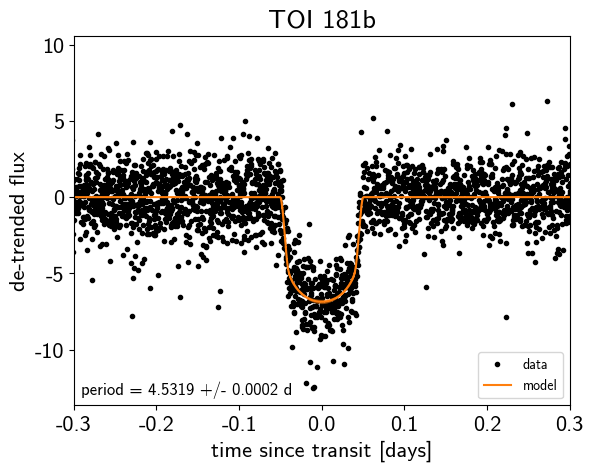

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

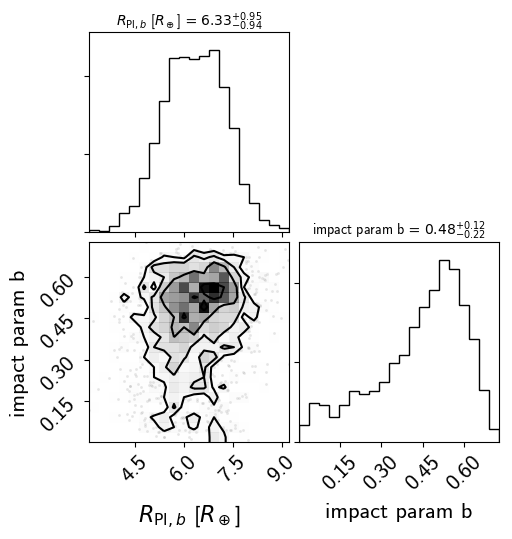

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

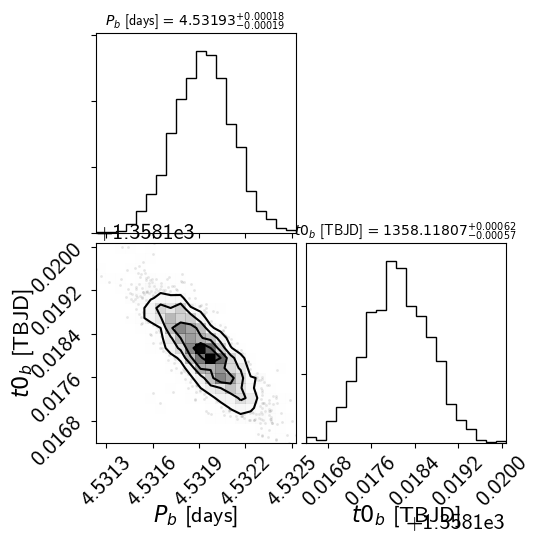

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

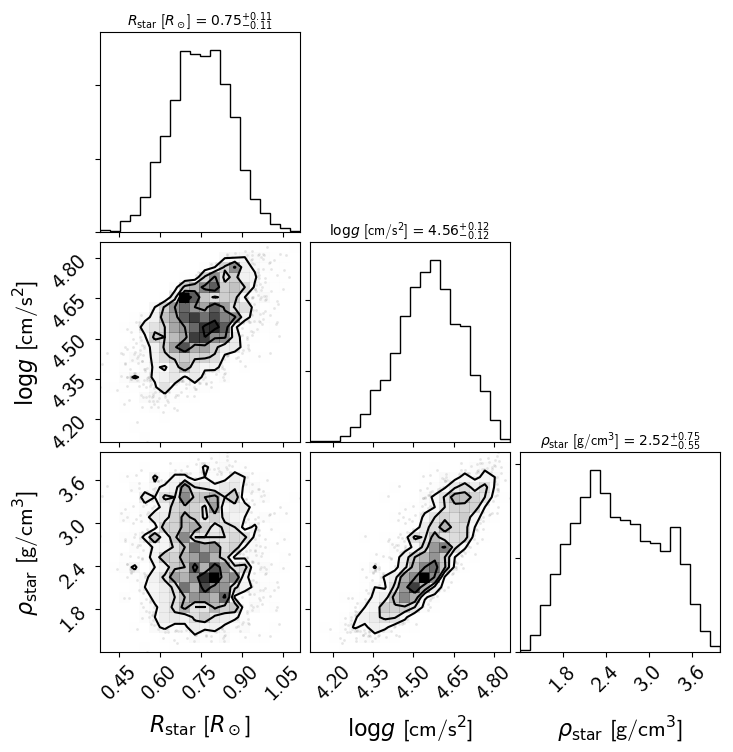

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3